# Surface Event Pick Time

This is a modified version of the surface-event location+directivity analysis that Francesca Skene ( fskene@uw.edu), originally created by her in 7/22/22, who started as an undergraduate student at UW. This is marine denolle's version. It includes:
* Waveform download for each event on each volcano given the PNSN pick times of "su" events.
* Data pre-processing to trim the data within 2-12 Hz and remove outliers.
* phase picking using transfer-learned model (Ni et al, 2023)
* event location using 1D grid search
* directivity measurements (velocity and direction) using Doppler effects.
* gathering of the data into a CSV data frame.

Updated 04/25/2024
Marine Denolle
(mdenolle@uw.edu)

Import Modules

In [2]:
# import sys
# sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client

import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from datetime import datetime
from utils import *
from mbf_elep_func import *
import torch
plt.rcParams.update({'font.size': 10})


import seisbench.models as sbm
device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
# from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

from joblib import Parallel, delayed
from matplotlib.backends.backend_pdf import PdfPages
import pyproj

In [3]:
import math
# Calculate the azimuth between the stations and the source location
def calculate_azimuth(source_lat,source_lon,station_lat,station_lon):
    station_location = math.radians(station_lat), math.radians(station_lon)
    source_location = math.radians(source_lat), math.radians(source_lon)
    source_location_rad = (math.radians(source_location[0]), math.radians(source_location[1]))
    
    delta_lon = station_location[1] - source_location_rad[1]
    
    numerator = math.sin(delta_lon) * math.cos(station_location[0])
    denominator = math.cos(source_location_rad[0]) * math.sin(station_location[0]) - math.sin(source_location_rad[0]) * math.cos(station_location[0]) * math.cos(delta_lon)
    
    azimuth = math.atan2(numerator, denominator)
    azimuth = math.degrees(azimuth)
     
    # Convert azimuth to range [0, 360]
    # if azimuth < 0:
    #     azimuth += 360
    
    return azimuth# Assume source_location is a tuple (latitude, longitude)



What avalanche are we studying?

In [4]:
ava = 'Avalanche_05282023'

Parameters

In [5]:
# define clients to download the station data
# client = WaveformClient() # we ignore PNWdatastore for now
client2 = Client('IRIS') # IRIS client

t_before = 15 #number of seconds before pick time
# t_after = 15 #number of seconds after pick time
t_before_raw = 1200 #number of seconds before pick time before removing instrumental response
# t_after_raw = 1200 #number of seconds after pick time before removing instrumental response
fs = 40 #sampling rate that all waveforms are resampled to
window = 150 #window length of the signal (this will help with phase picking with EqT next). 
# Use 150 seconds @ 40 Hz gives 6001 points. 
pr = 98 #percentile
thr = 7 #SNR threshold
station_distance_threshold = 25
pi = np.pi
vs = 2800 #shear wave velocity at the surface

# range of dates that we are looking at
t_beginning = UTCDateTime(2001,1,1,0,0,0) 
t_end = UTCDateTime(2024,1,1,23,59)

smooth_length = 20 # constant for smoothing the waveform envelopes
low_cut = 1 #low frequency threshold
high_cut = 15 #high frequency threshold
az_thr = 1000 #threshold of distance in meters from source location
step = 100 #step every 100 m
t_step = 1 #step every second
ratio = 5.6915196 #used to define the grid 
# colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3 # radius of the earth

## Volcano - Station Information

In [6]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('../data/station/Volcano_Metadata_50km.csv')

In [7]:

import rasterio
from matplotlib.colors import LightSource
from rasterio.warp import transform_bounds,  reproject, Resampling , calculate_default_transform
from rasterio.transform import array_bounds

In [8]:
associated_volcano = 'Mt_Rainier'
        
#get info for stations within 50km of volcano that event ocurred at
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()


In [9]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5]
#Find the lower left corner and grid size based on volcano elevation
# define grid origin in lat,lon and grid dimensions in m
lon_start = -121.9 #volc_lat_lon[associated_volcano][0]
lon_end = -121.65 #volc_lat_lon[associated_volcano][0]
lat_start = 46.6 #volc_lat_lon[associated_volcano][1]
lat_end = 47 #volc_lat_lon[associated_volcano][1]


# Create a light source
ls = LightSource(azdeg=315, altdeg=45)


# Load the DEM with rasterio
with rasterio.open('../data/geospatial/Mt_Rainier/Mt_Rainier.tif') as src:
    dem = src.read(1)  # read the first band
    transform = src.transform
    bounds = src.bounds
    crs=src.crs
    # dem = dem.astype('float64')
    dem[dem == -32767] = np.nan #gets rid of edge effects
    # dem = np.nan_to_num(dem,nan=1000)


# Define the target CRS
epsg_code = 32600 + 10
# dst_crs = 'EPSG:4326'  # EPSG:4326 is the code for WGS84 lat/lon
dst_crs = 'epsg:{}'.format(epsg_code) #pyproj.Proj(init=)
# Calculate the transform and dimensions for the reprojected DEM
transform_latlon, width, height = calculate_default_transform(crs, dst_crs, dem.shape[1], dem.shape[0], *bounds)


# Create an empty array for the reprojected DEM
dem_latlon = np.empty(shape=(height, width))

# Reproject the DEM
reproject(
    source=dem,
    destination=dem_latlon,
    src_transform=transform,
    src_crs=crs,
    dst_transform=transform_latlon,
    dst_crs=dst_crs,
    resampling=Resampling.nearest)

# Transform the bounds to the target CRS
left, bottom, right, top = transform_bounds(crs, dst_crs, *bounds)

# Calculate the illumination intensity
illumination = ls.hillshade(dem_latlon)
# new bounds
left, bottom, right, top = array_bounds(height, width, transform_latlon)

In [10]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5]
#Find the lower left corner and grid size based on volcano elevation
# define grid origin in lat,lon and grid dimensions in m
lon_start = -122 #volc_lat_lon[associated_volcano][0]
lon_end = -121.5 #volc_lat_lon[associated_volcano][0]
lat_start = 46.6 #volc_lat_lon[associated_volcano][1]
lat_end = 47 #volc_lat_lon[associated_volcano][1]


proj = pyproj.Proj(proj='utm', zone=10, ellps='WGS84')
if lon_start<0: 
    lon_start1 = lon_start+360
    lon_end1 = lon_end + 360
# Convert lat/long to Cartesian in meters
x_step=100
x1,y1=proj(lon_start,lat_start)
x2,y2=proj(lon_end,lat_end)
# Generate the x and y coordinates for the grid
x_coords = np.arange(x1, x2, x_step)
y_coords = np.arange(y1, y2, x_step)


cmap1 = plt.get_cmap('hot_r')
cmap2 = plt.get_cmap('hsv')


## PNSN SU Pick information

In [11]:
f1 = pd.read_csv("../data/events/su_picks.txt",sep="|")
f1.head()
print(f1.keys())

Index(['date', 'net', 'sta', 'location', 'seedchan', 'iphase', 'quality',
       'orid', 'etype', 'evid'],
      dtype='object')


In [12]:
# clean up the spaces in the file
format='%Y/%m/%d %H:%M:%S'
test=f1["date"].values.tolist()
start_time_temp = [  datetime.strptime(x.strip(),'%Y/%m/%d %H:%M:%S') for x in f1["date"].values.tolist()]
# # Ignore events prior to t_beginning
ik=np.where(np.array(start_time_temp)>datetime(2001,1,1))[0][0]

# select only net, sta, evid, startime for event past the start date.

start_time = start_time_temp[ik:]
net=[ x.strip() for x in f1["net"].values.tolist()][ik:]
sta=[ x.strip() for x in f1["sta"].values.tolist()][ik:]
evt_id=[ x for x in f1["orid"].values.tolist()][ik:]
all_stas=set(sta)

## ML Models

In [13]:
# import os
# os.makedirs("/Users/marinedenolle/.seisbench/models/v3/eqtransformer",exist_ok=True)

In [14]:
# !wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.pt.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.pt.v1
# !wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.json.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.json.v1

In [15]:
# download models
list_models_name = ["pnw","ethz","instance","scedc","stead","geofon"]
pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
# pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

list_models = [pn_pnw_model, pn_ethz_model, pn_instance_model, pn_scedc_model, pn_stead_model, pn_geofon_model]

pn_pnw_model.to(device);
pn_ethz_model.to(device);
pn_scedc_model.to(device);
# pn_neic_model.to(device);
pn_geofon_model.to(device);
pn_stead_model.to(device);
pn_instance_model.to(device);

In [16]:
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05

fqmin = low_cut
fqmax = high_cut
dt = 0.025; fs = 40
nfqs = 10
nt = 6000; nc = 3
fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

# Full stack:

* download waveforms
* phase pick onset
* estimate SNR
* measure centroid, max envelope, duration
* measure Fmax for doppler analysis


14630 0
14629 1
14628 2
14627 3
14626 4
14625 5
14624 6
14623 7
14622 8
14621 9
14620 10
14619 11
14618 12
14617 13
14616 14
14615 15
14614 16
14613 17
14612 18
14611 19
14610 20
14609 21
14608 22


/Users/marinedenolle/opt/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/marinedenolle/opt/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/marinedenolle/opt/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_38281/3421467149.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider

14607 23


/Users/marinedenolle/opt/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/marinedenolle/opt/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/marinedenolle/opt/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14606 24
14605 25
14604 26
14603 27
14602 28
14601 29
14600 30


/Users/marinedenolle/opt/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/marinedenolle/opt/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/marinedenolle/opt/miniconda3/envs/seismo_exo/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14599 31
14598 32
14597 33
14596 34
14595 35


TimeoutError: timed out

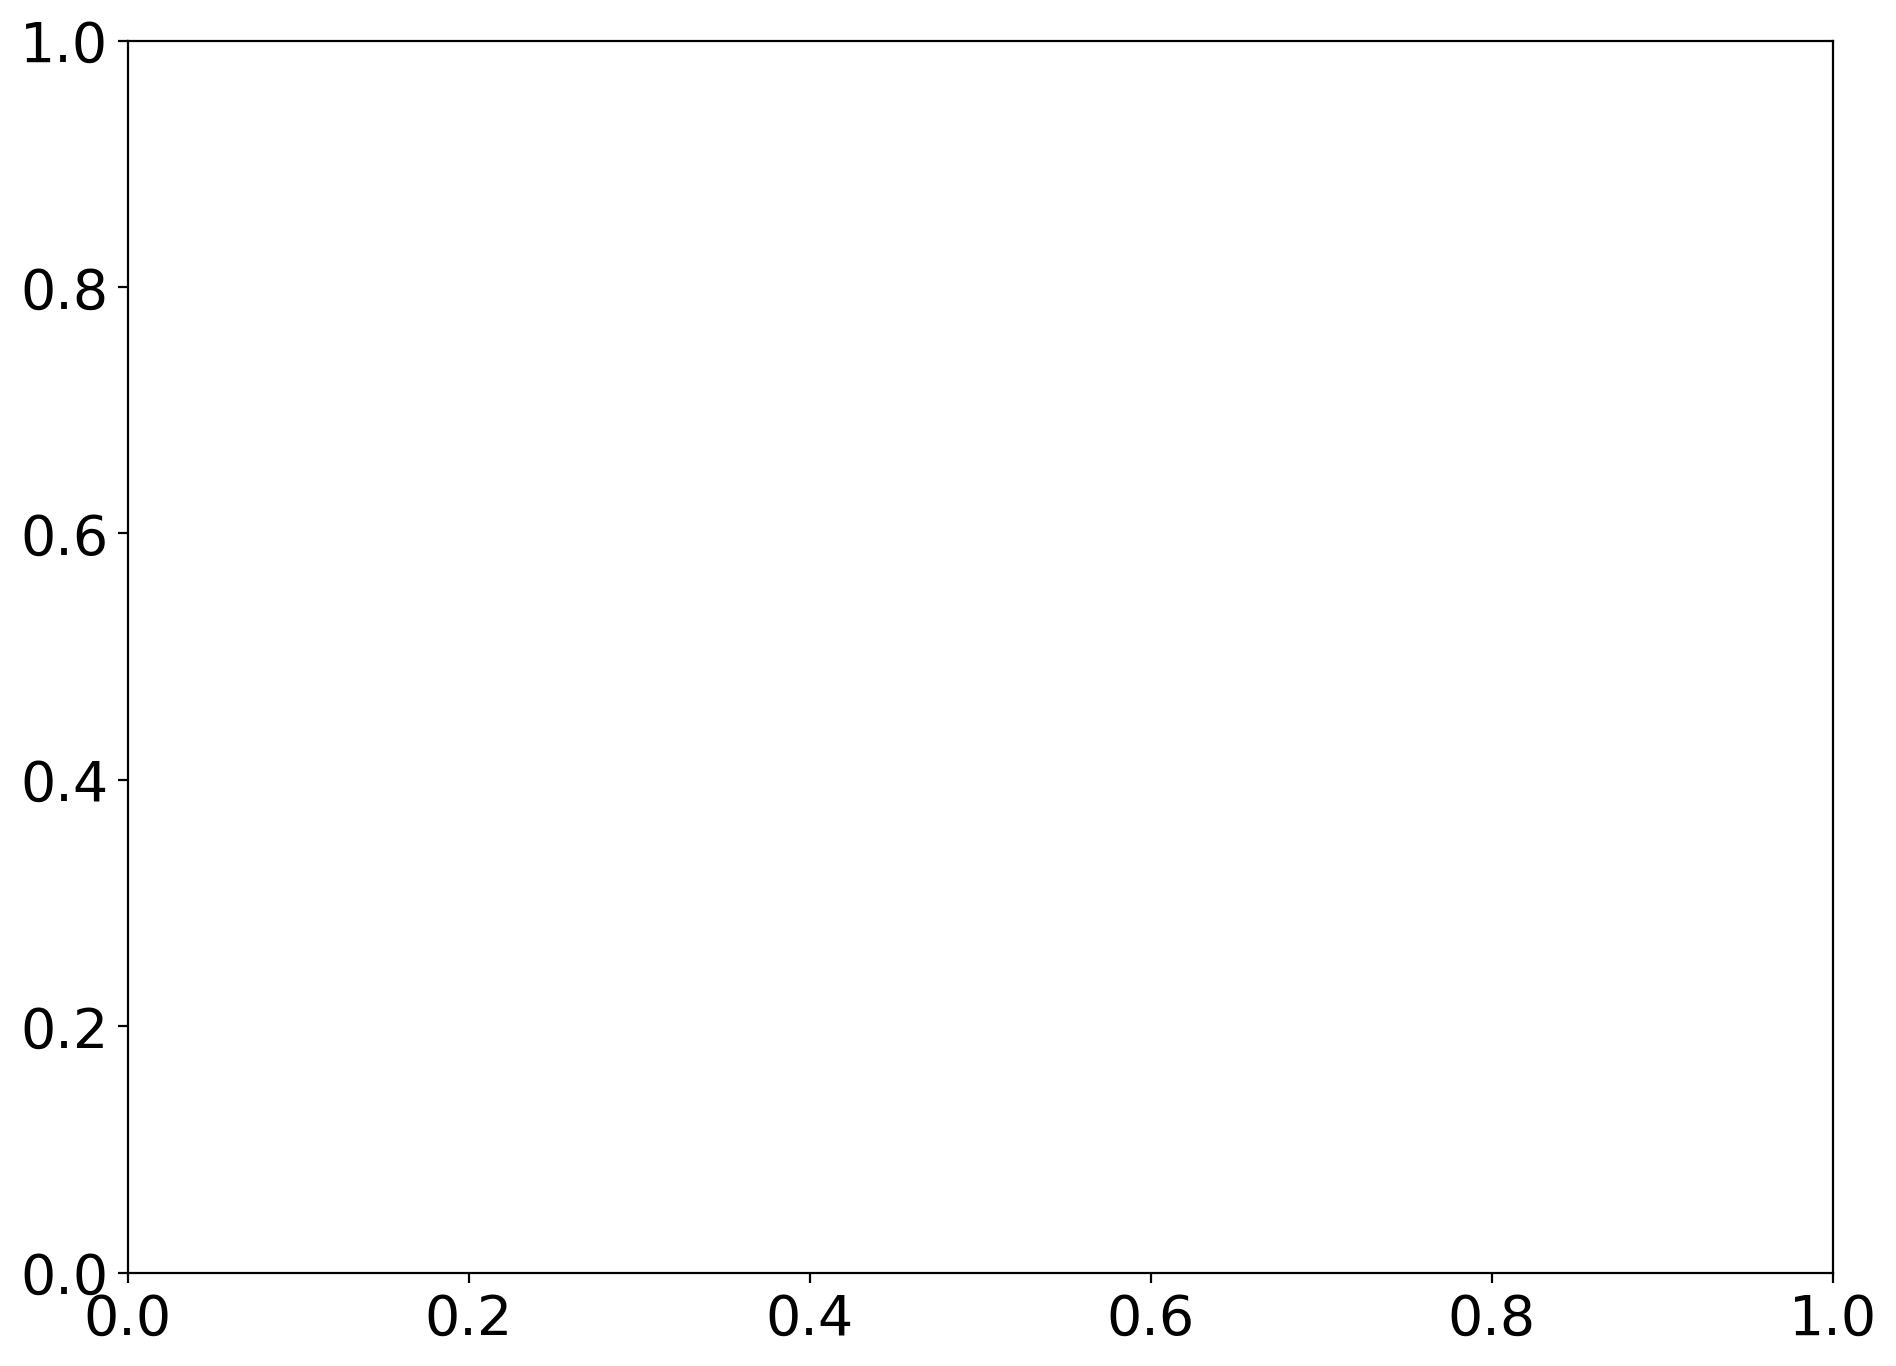

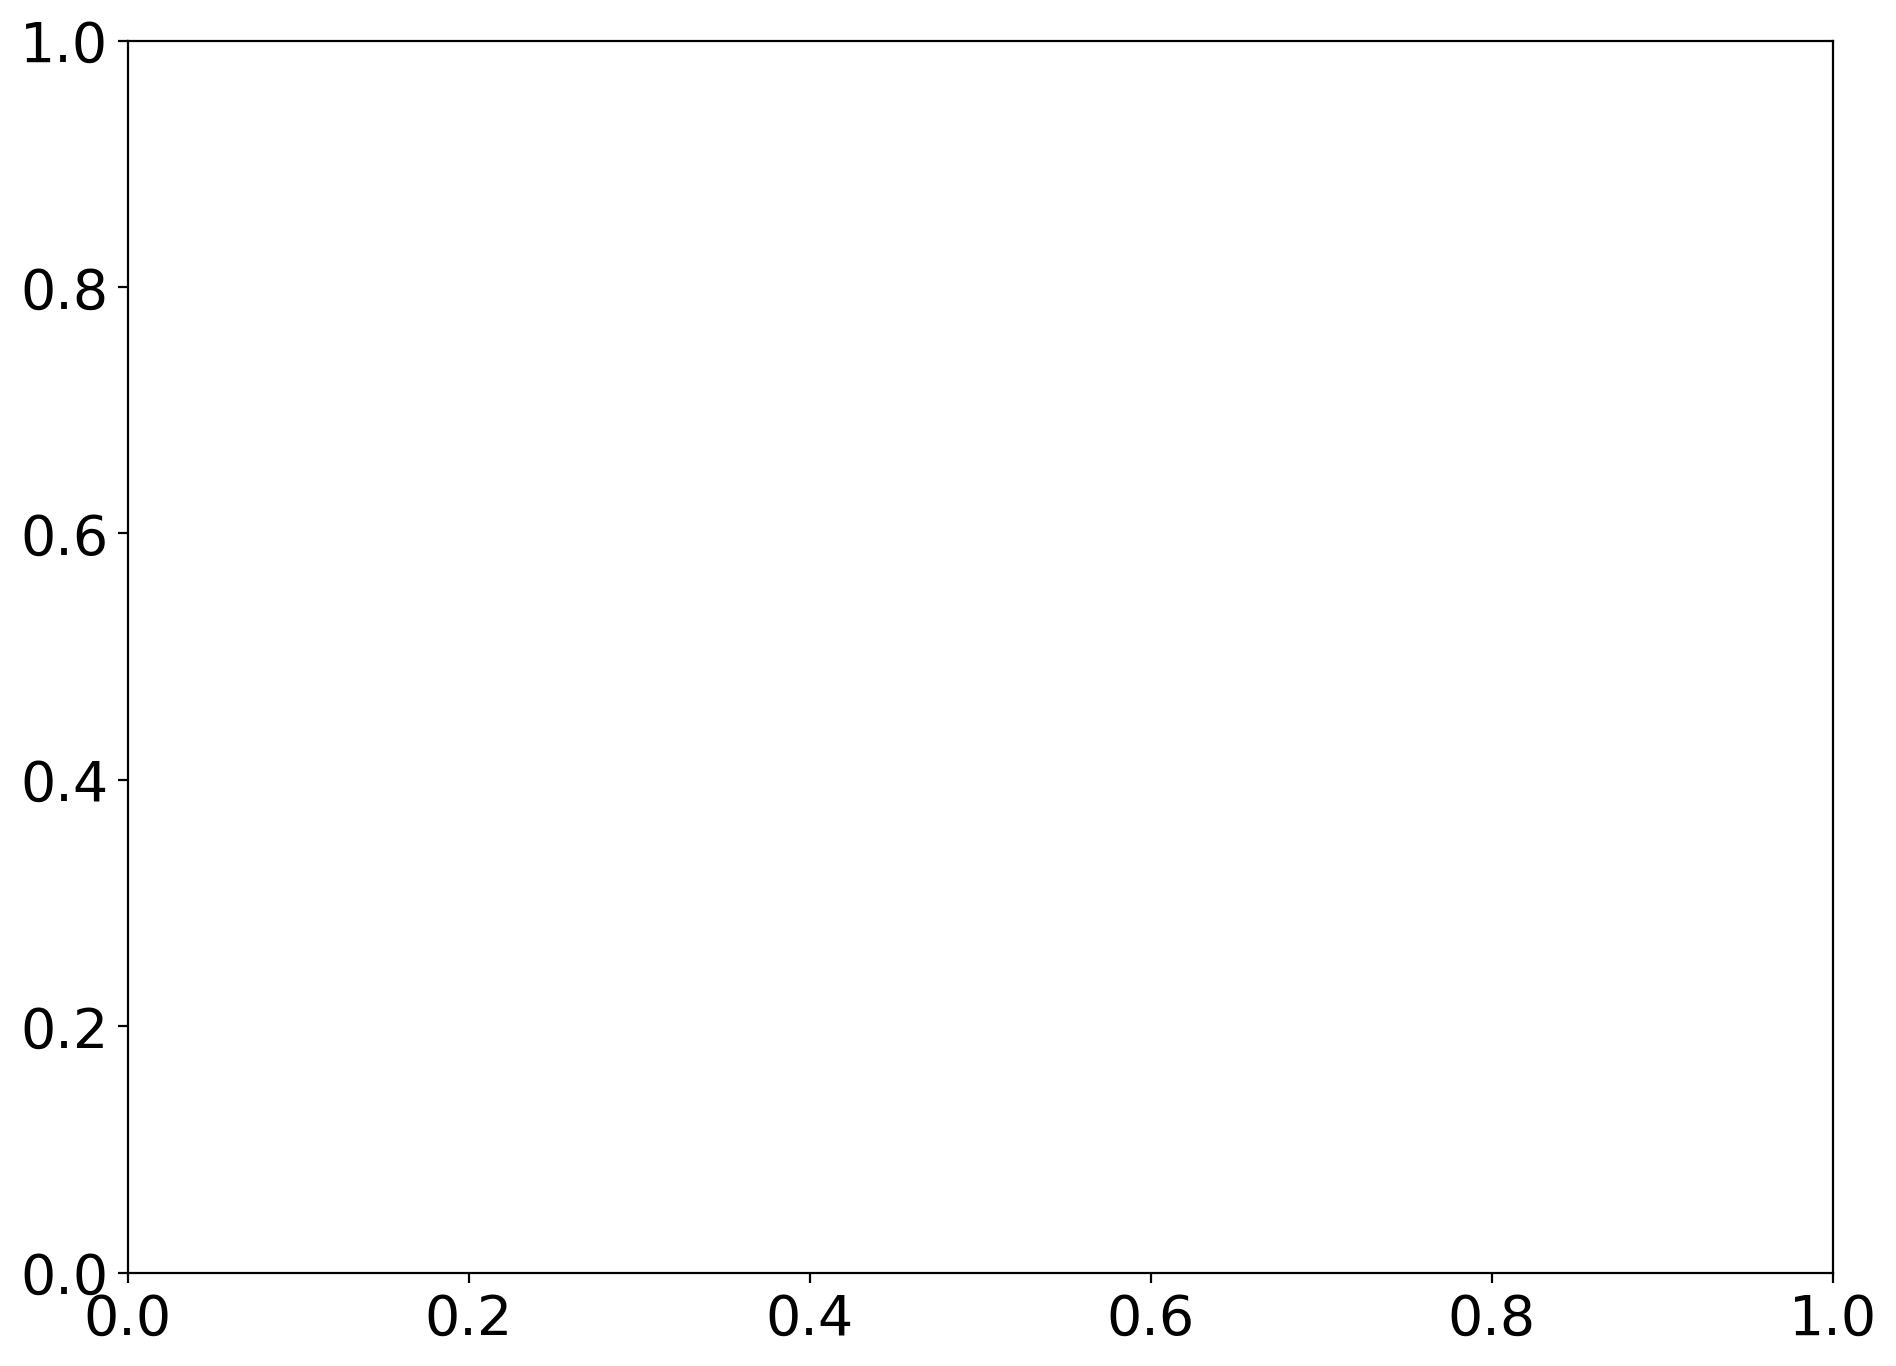

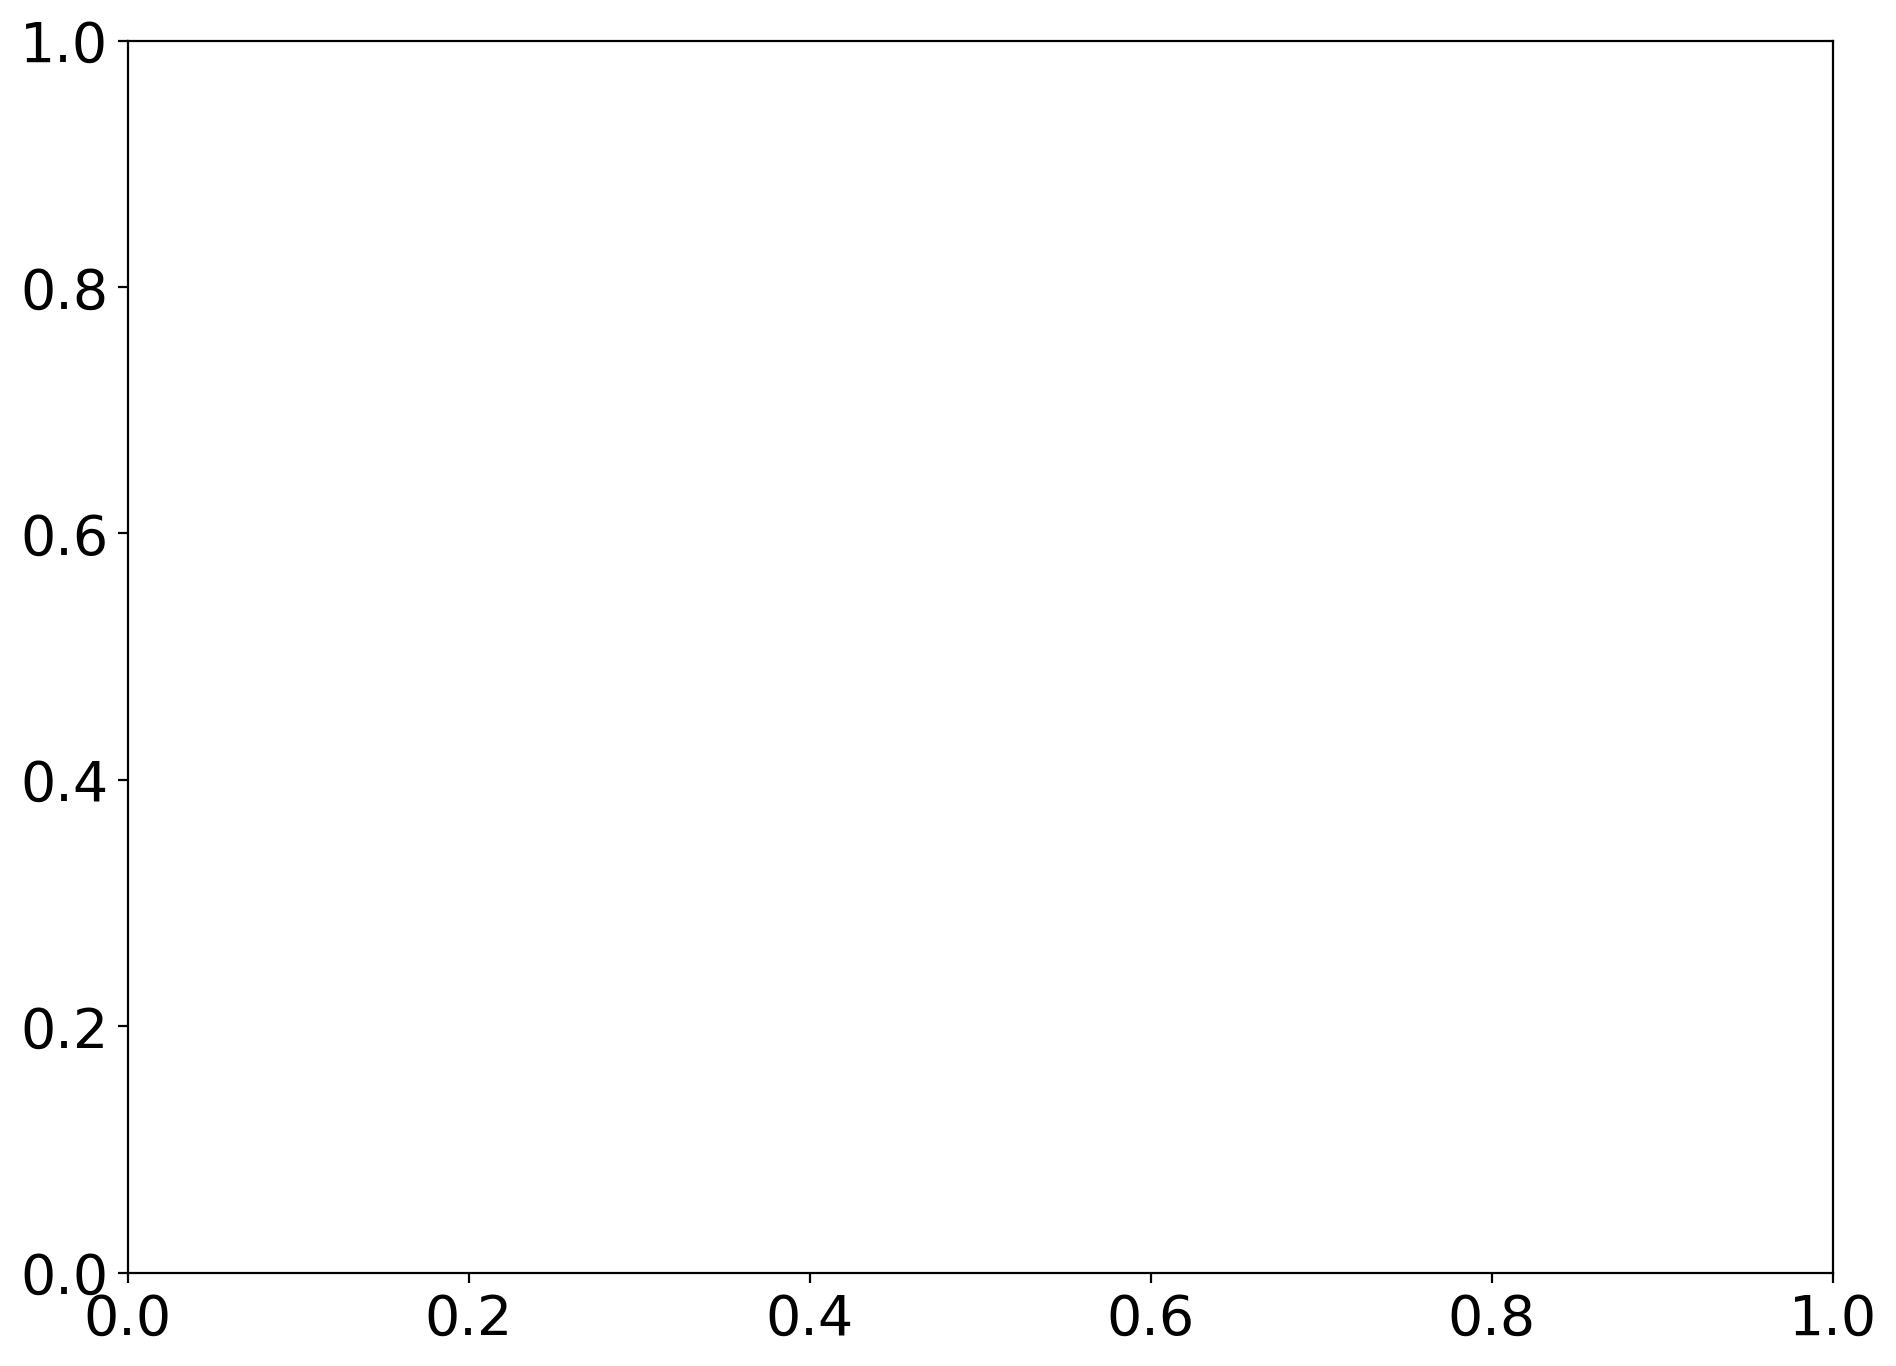

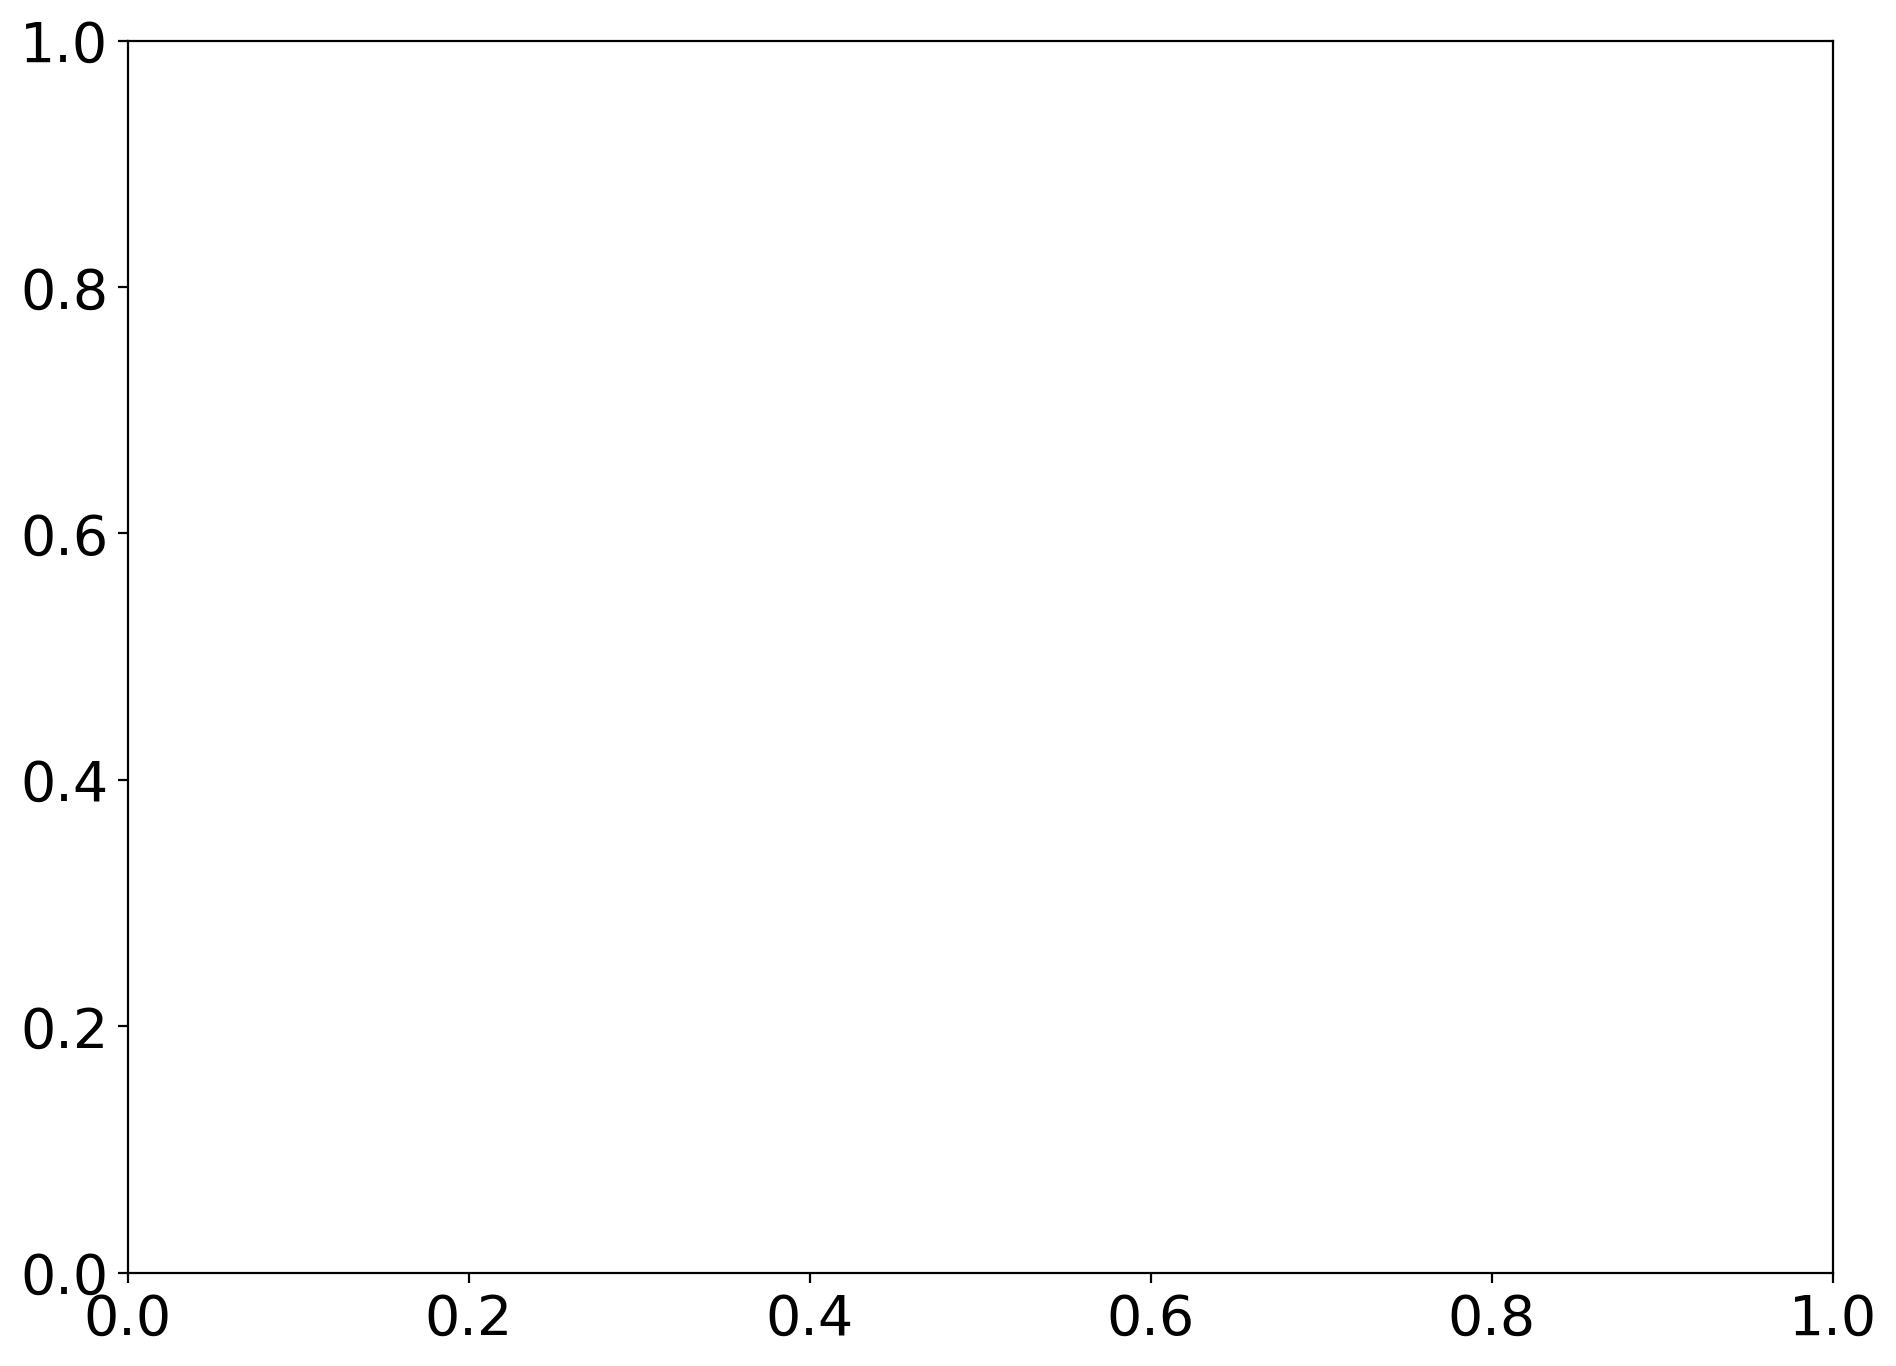

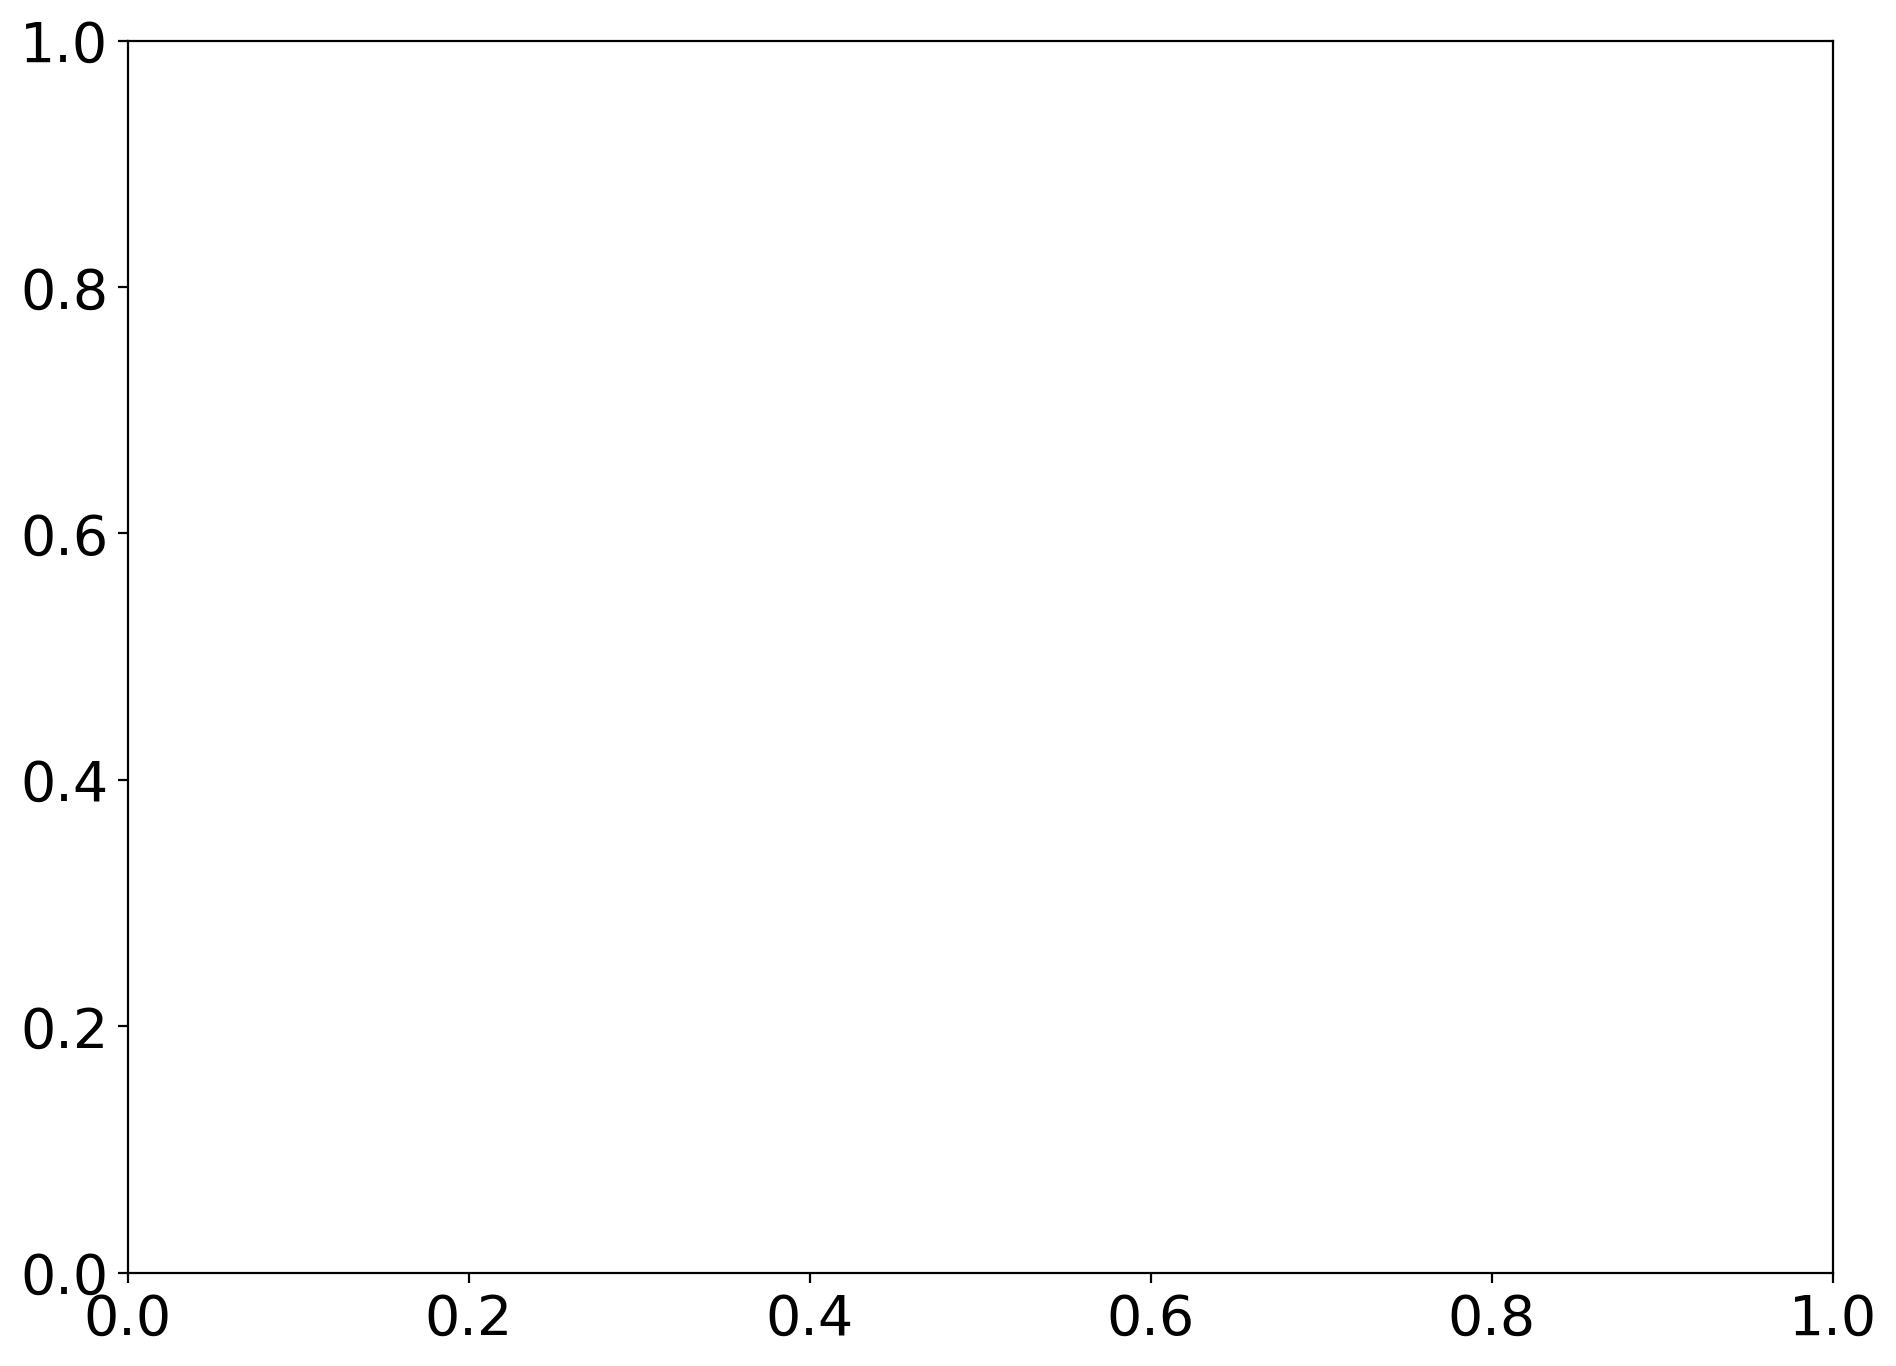

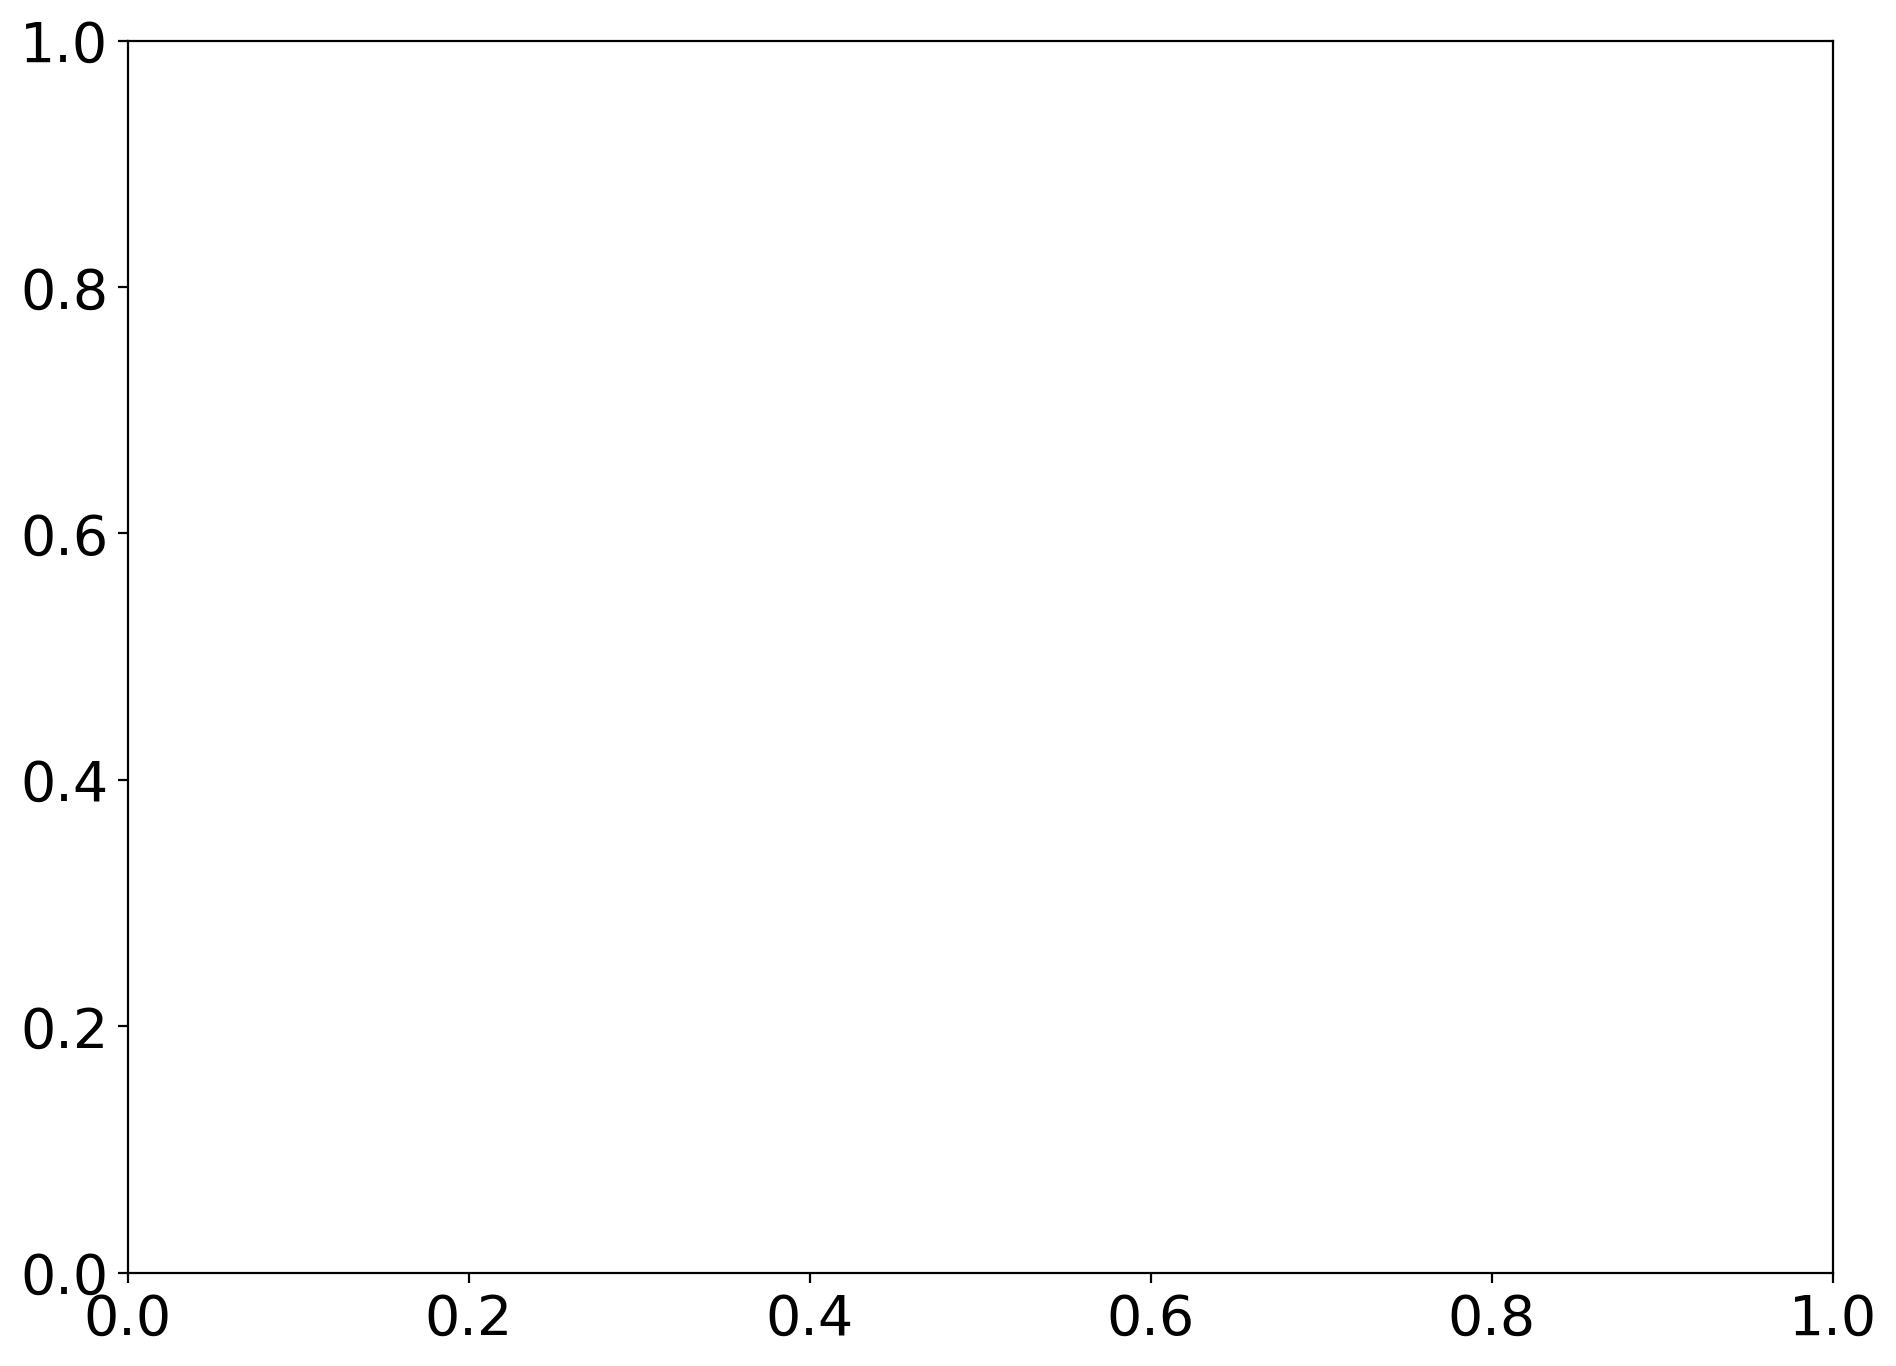

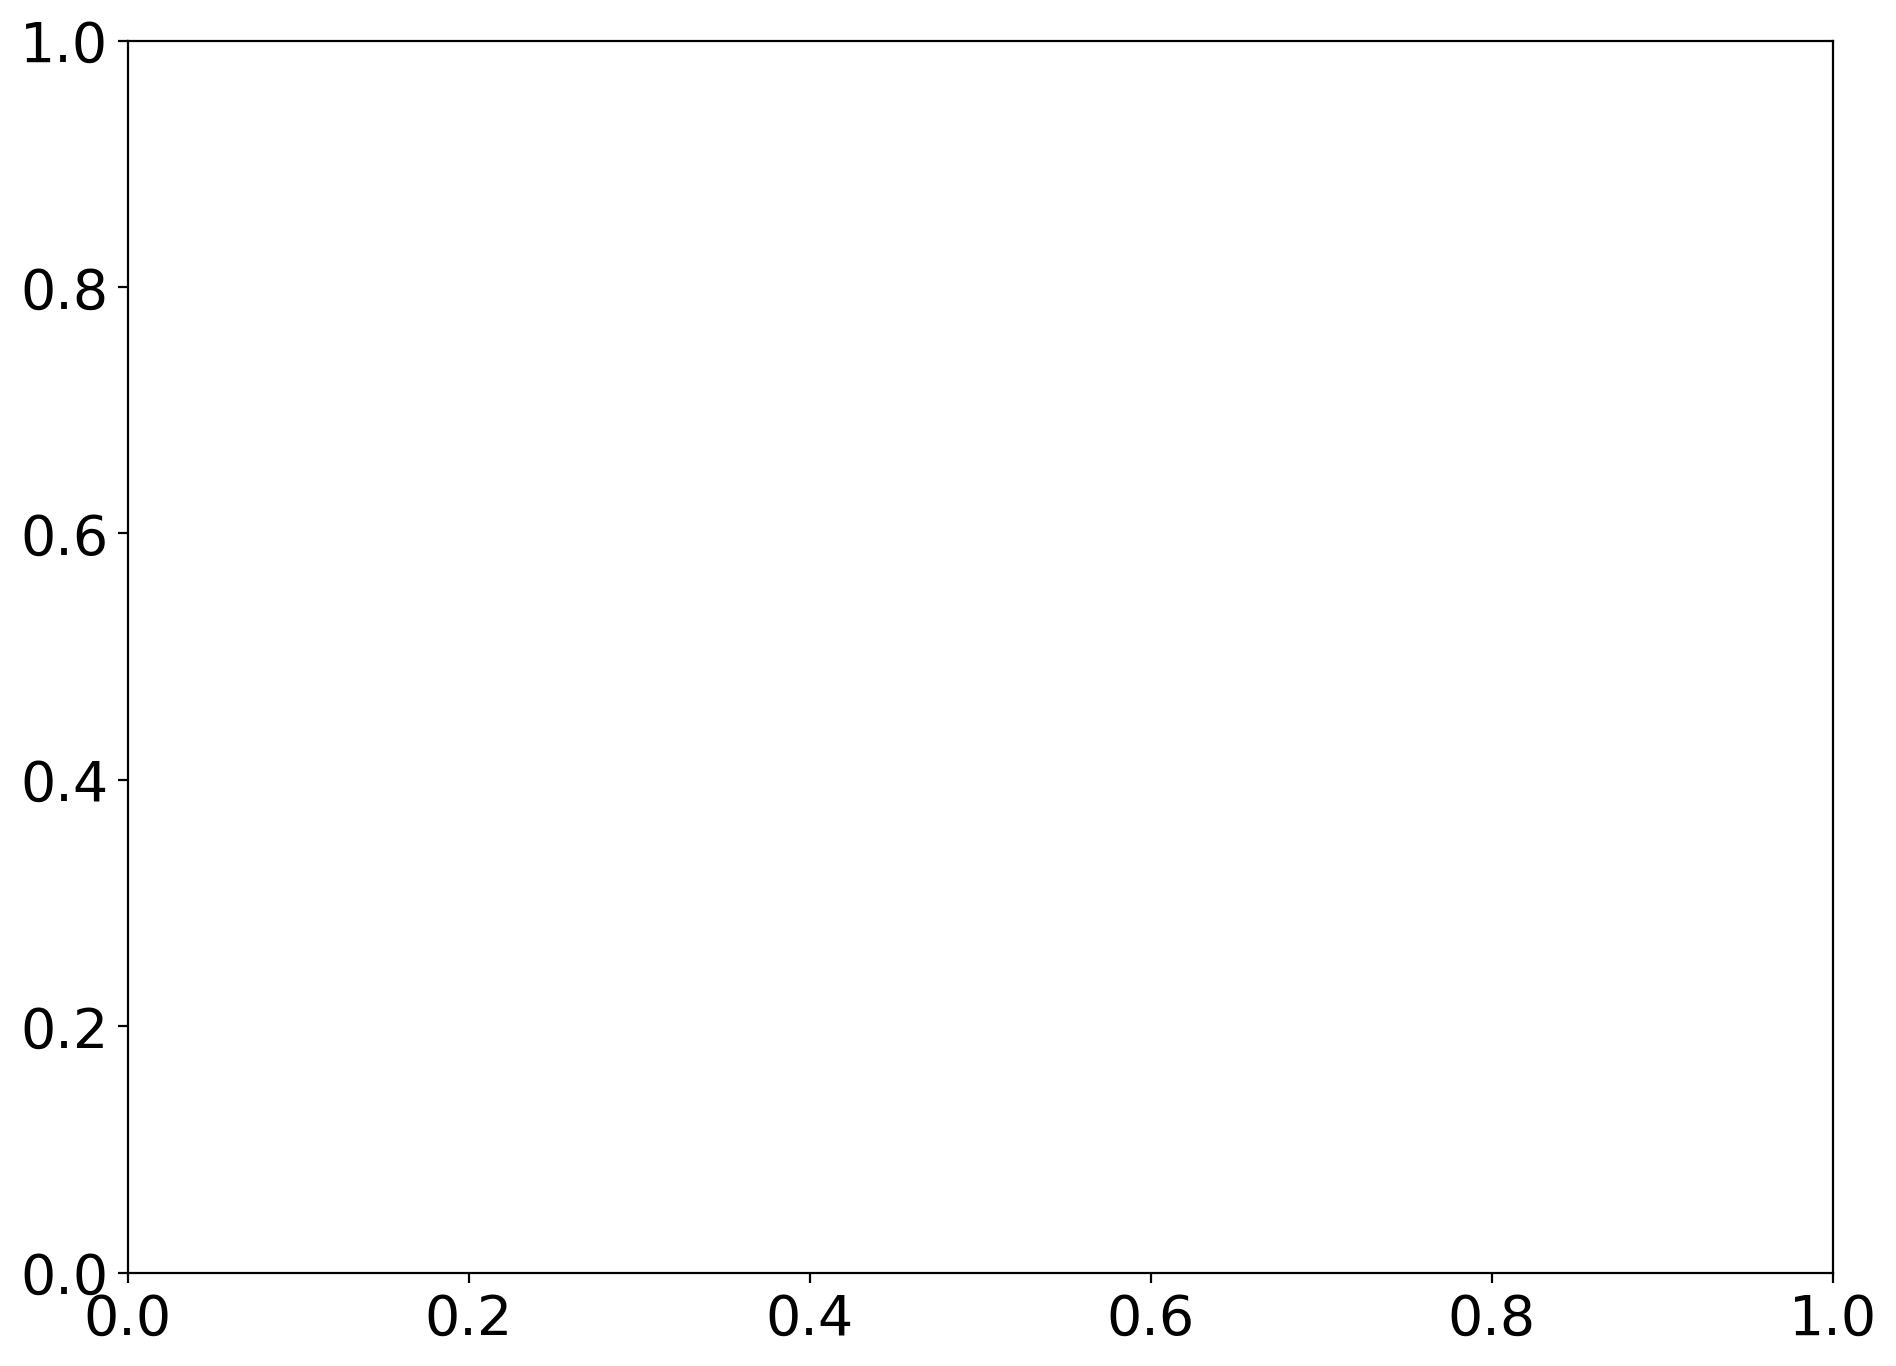

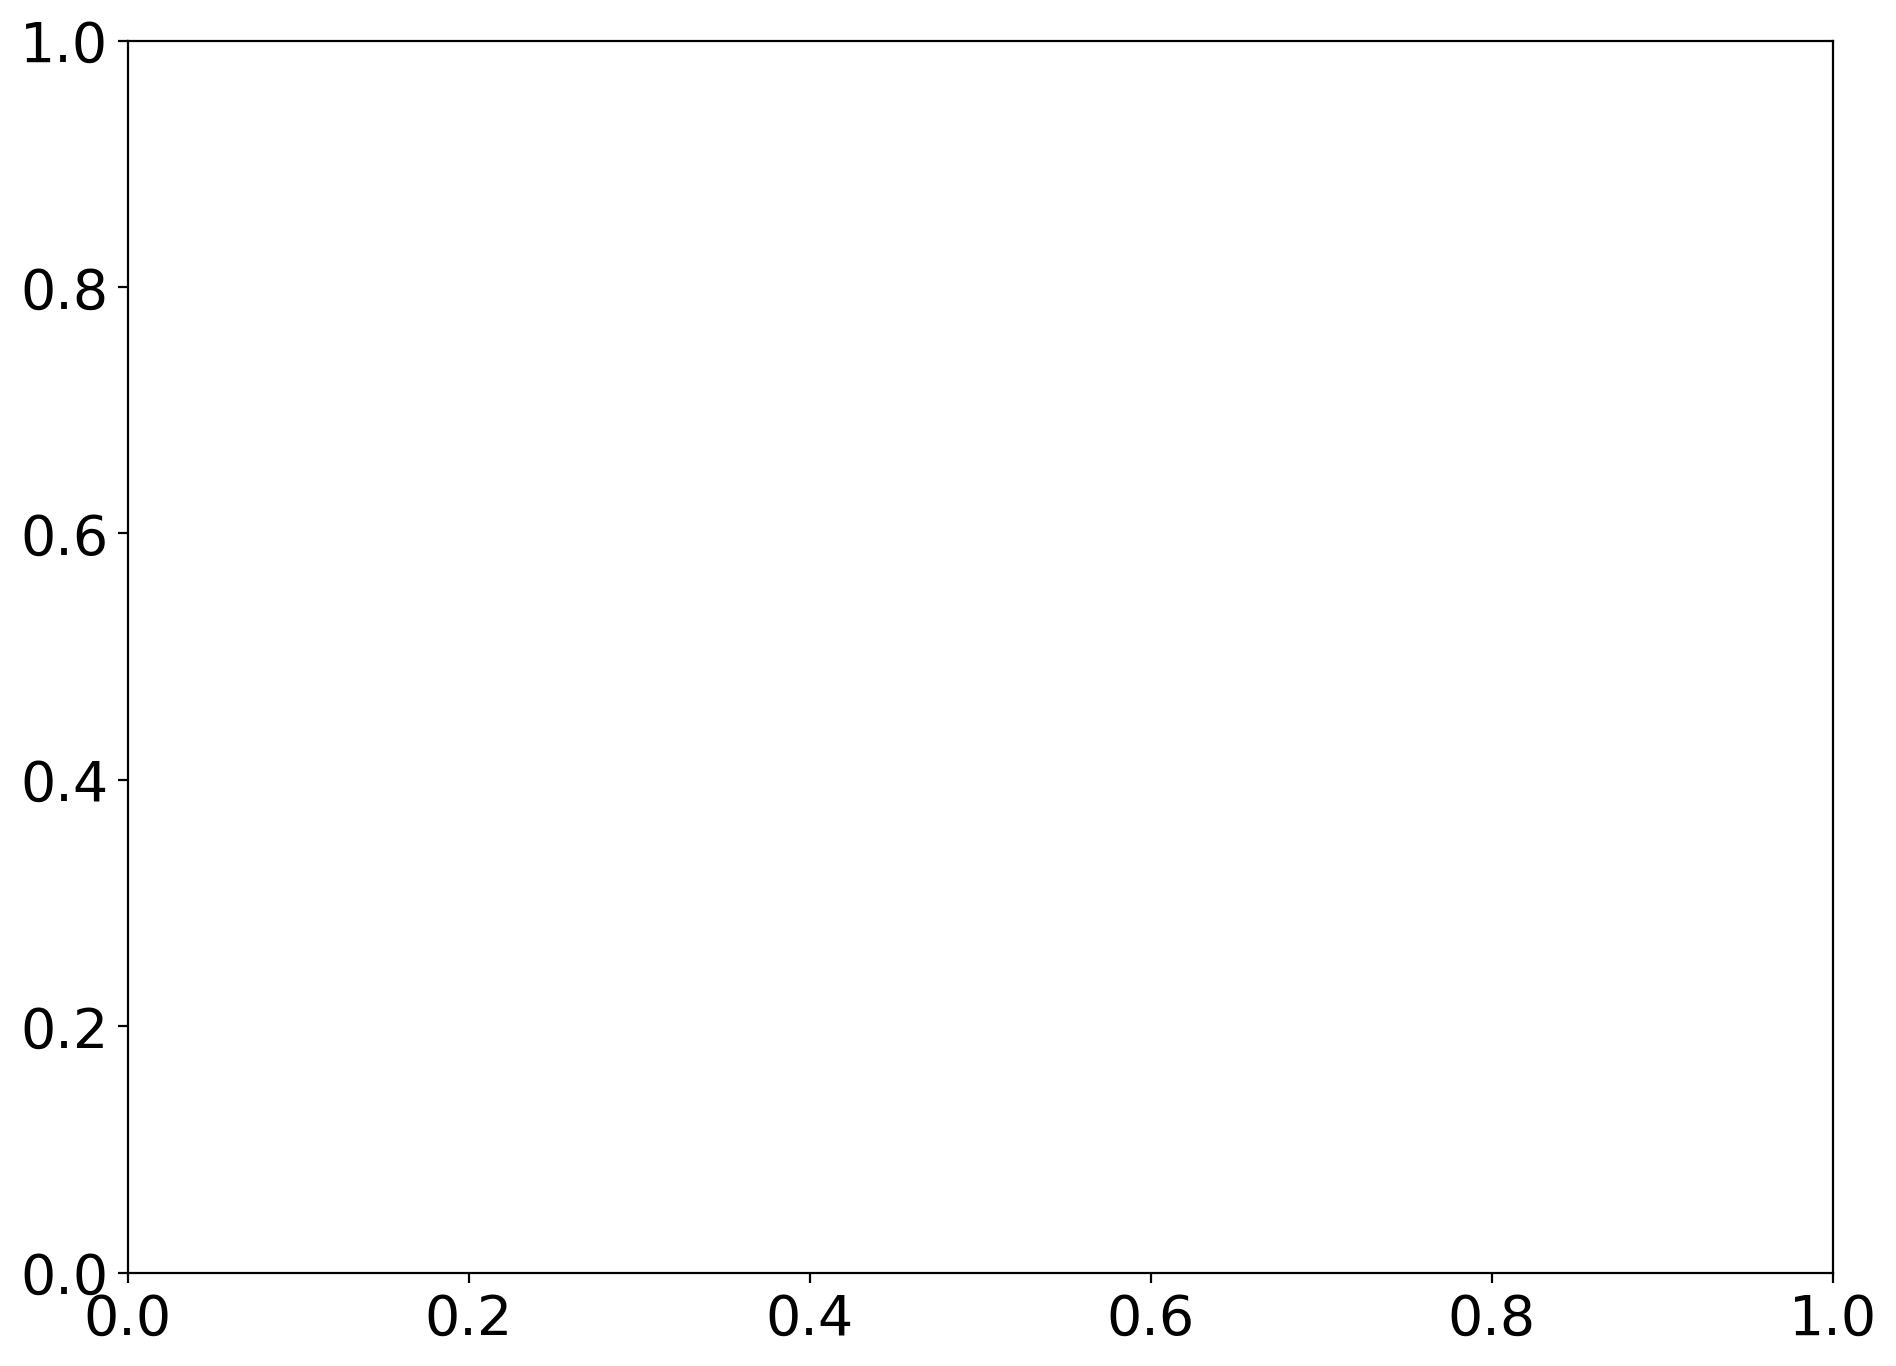

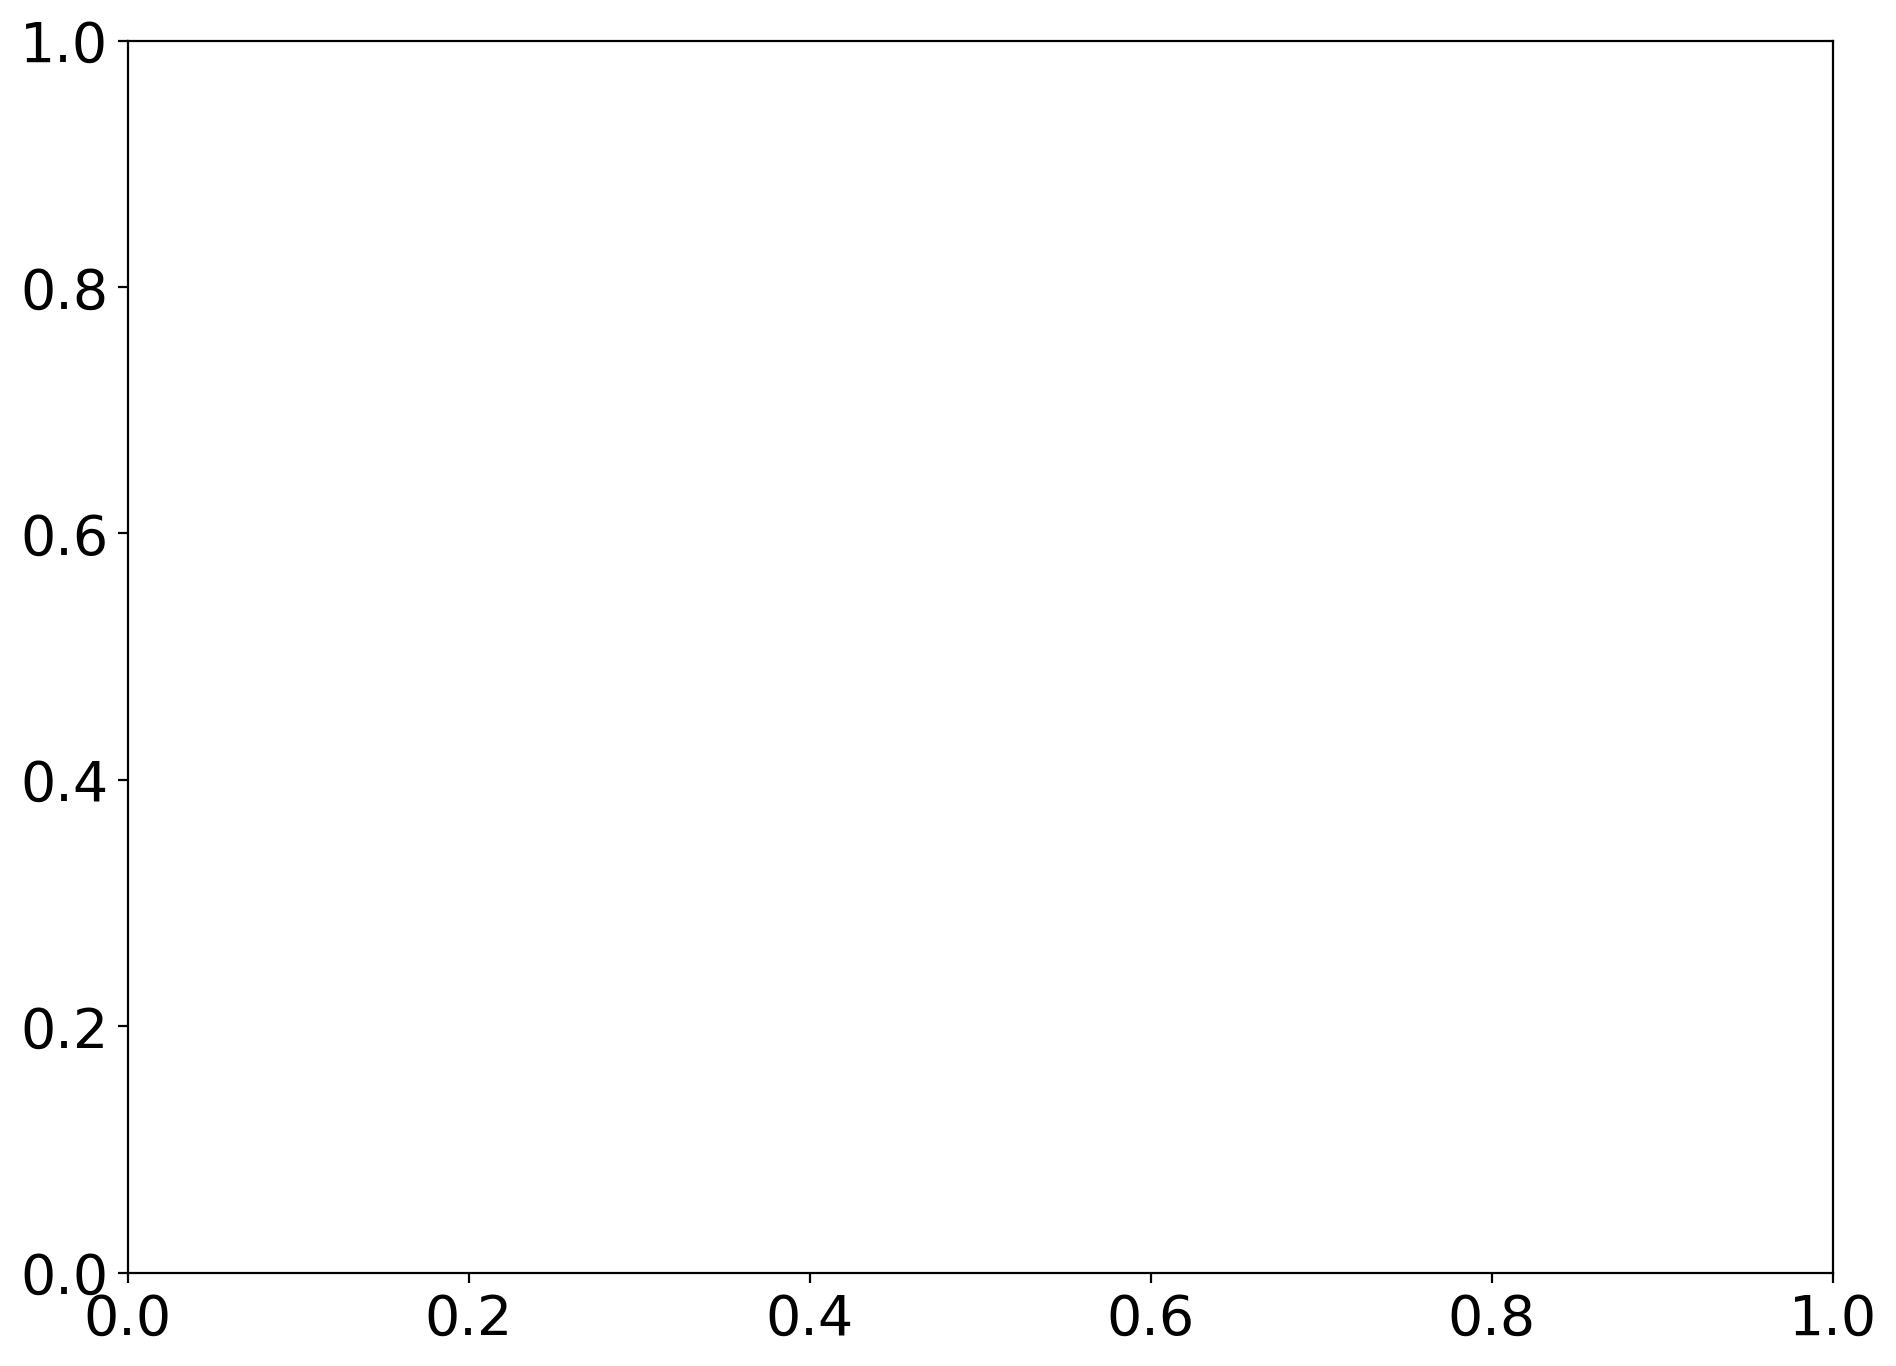

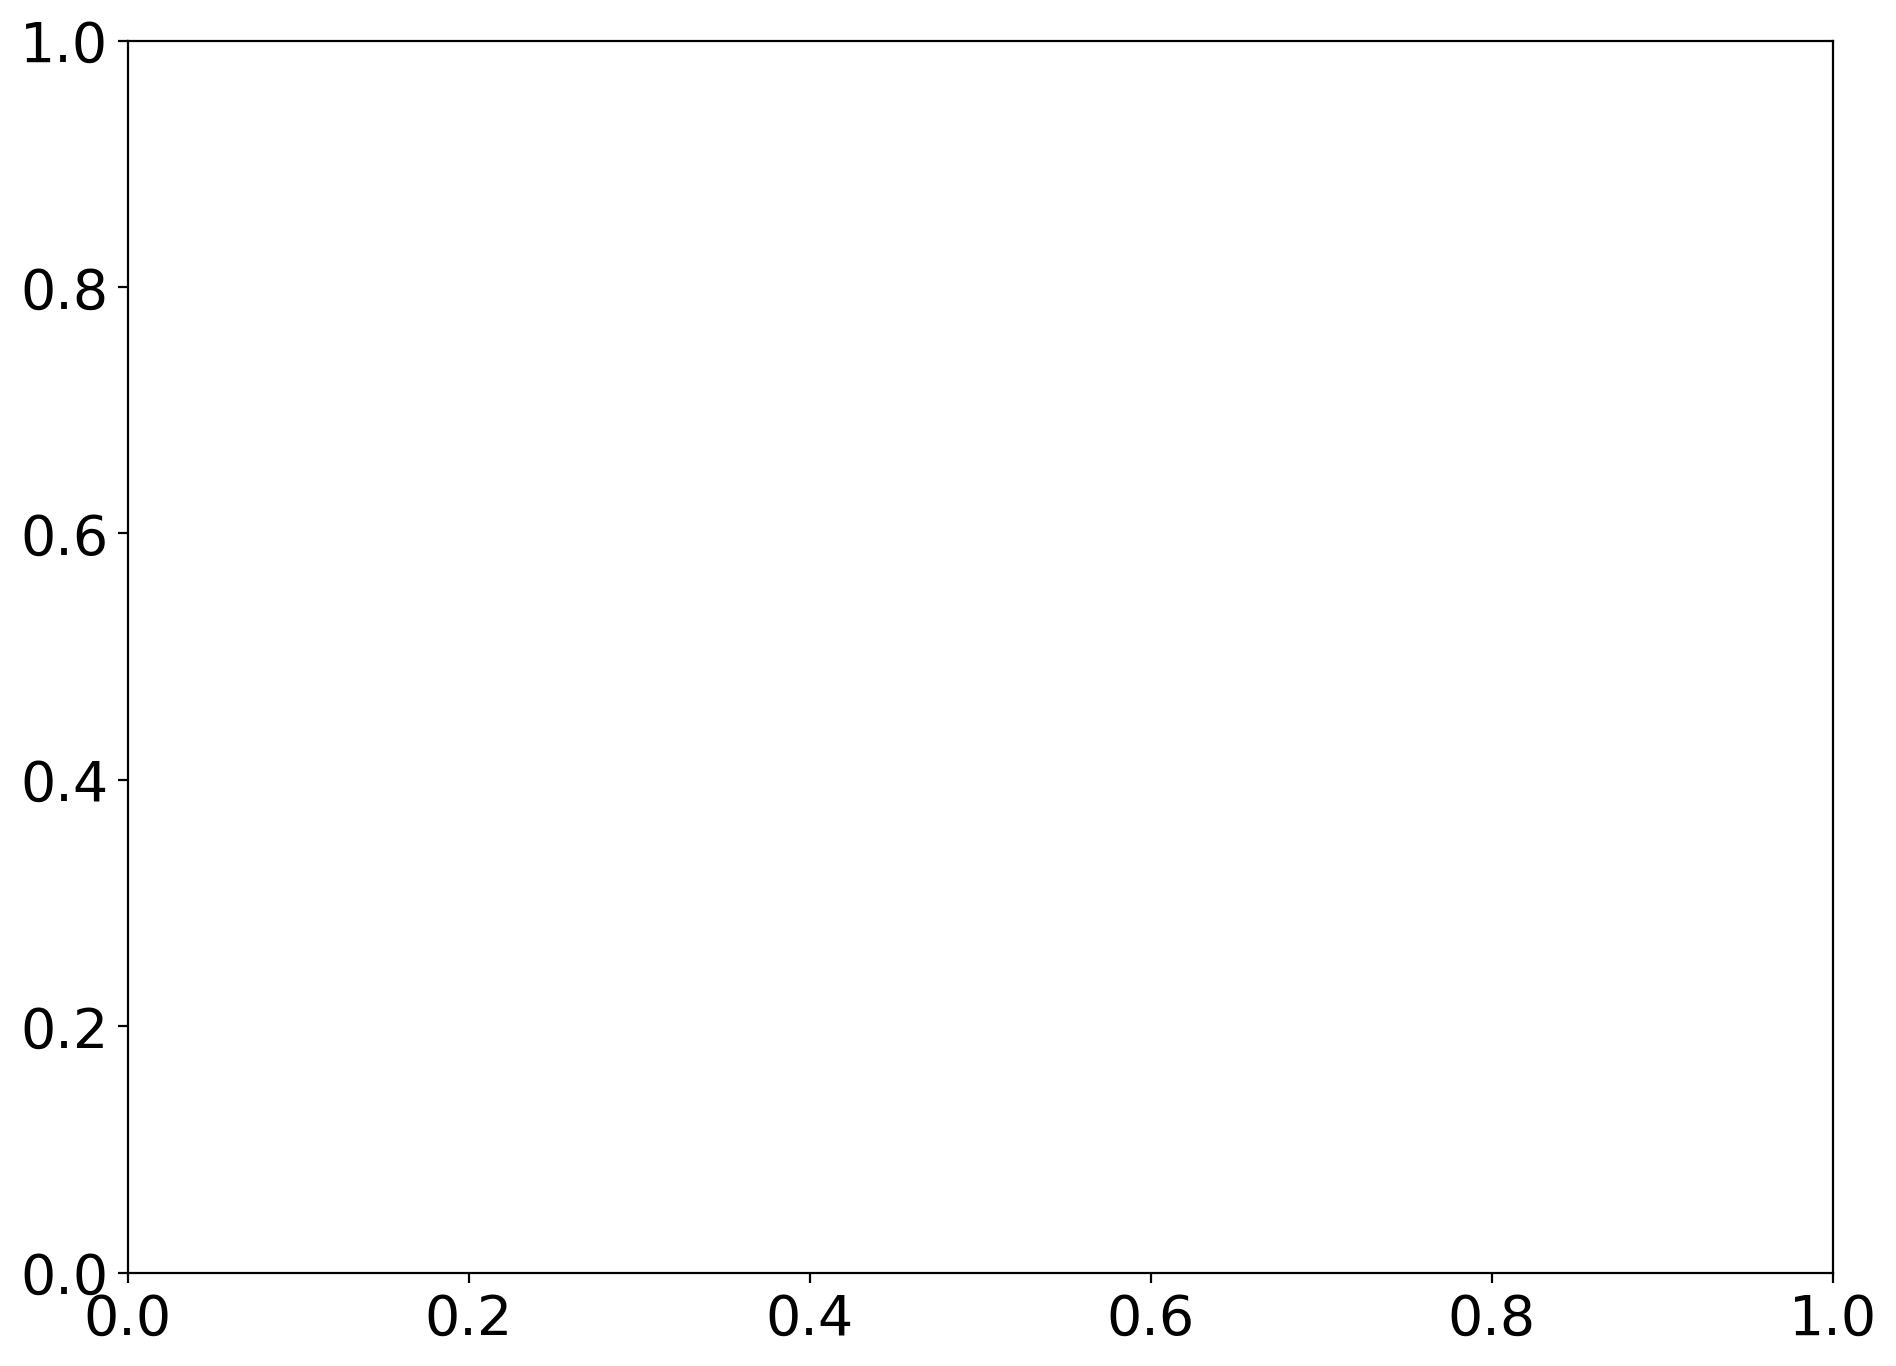

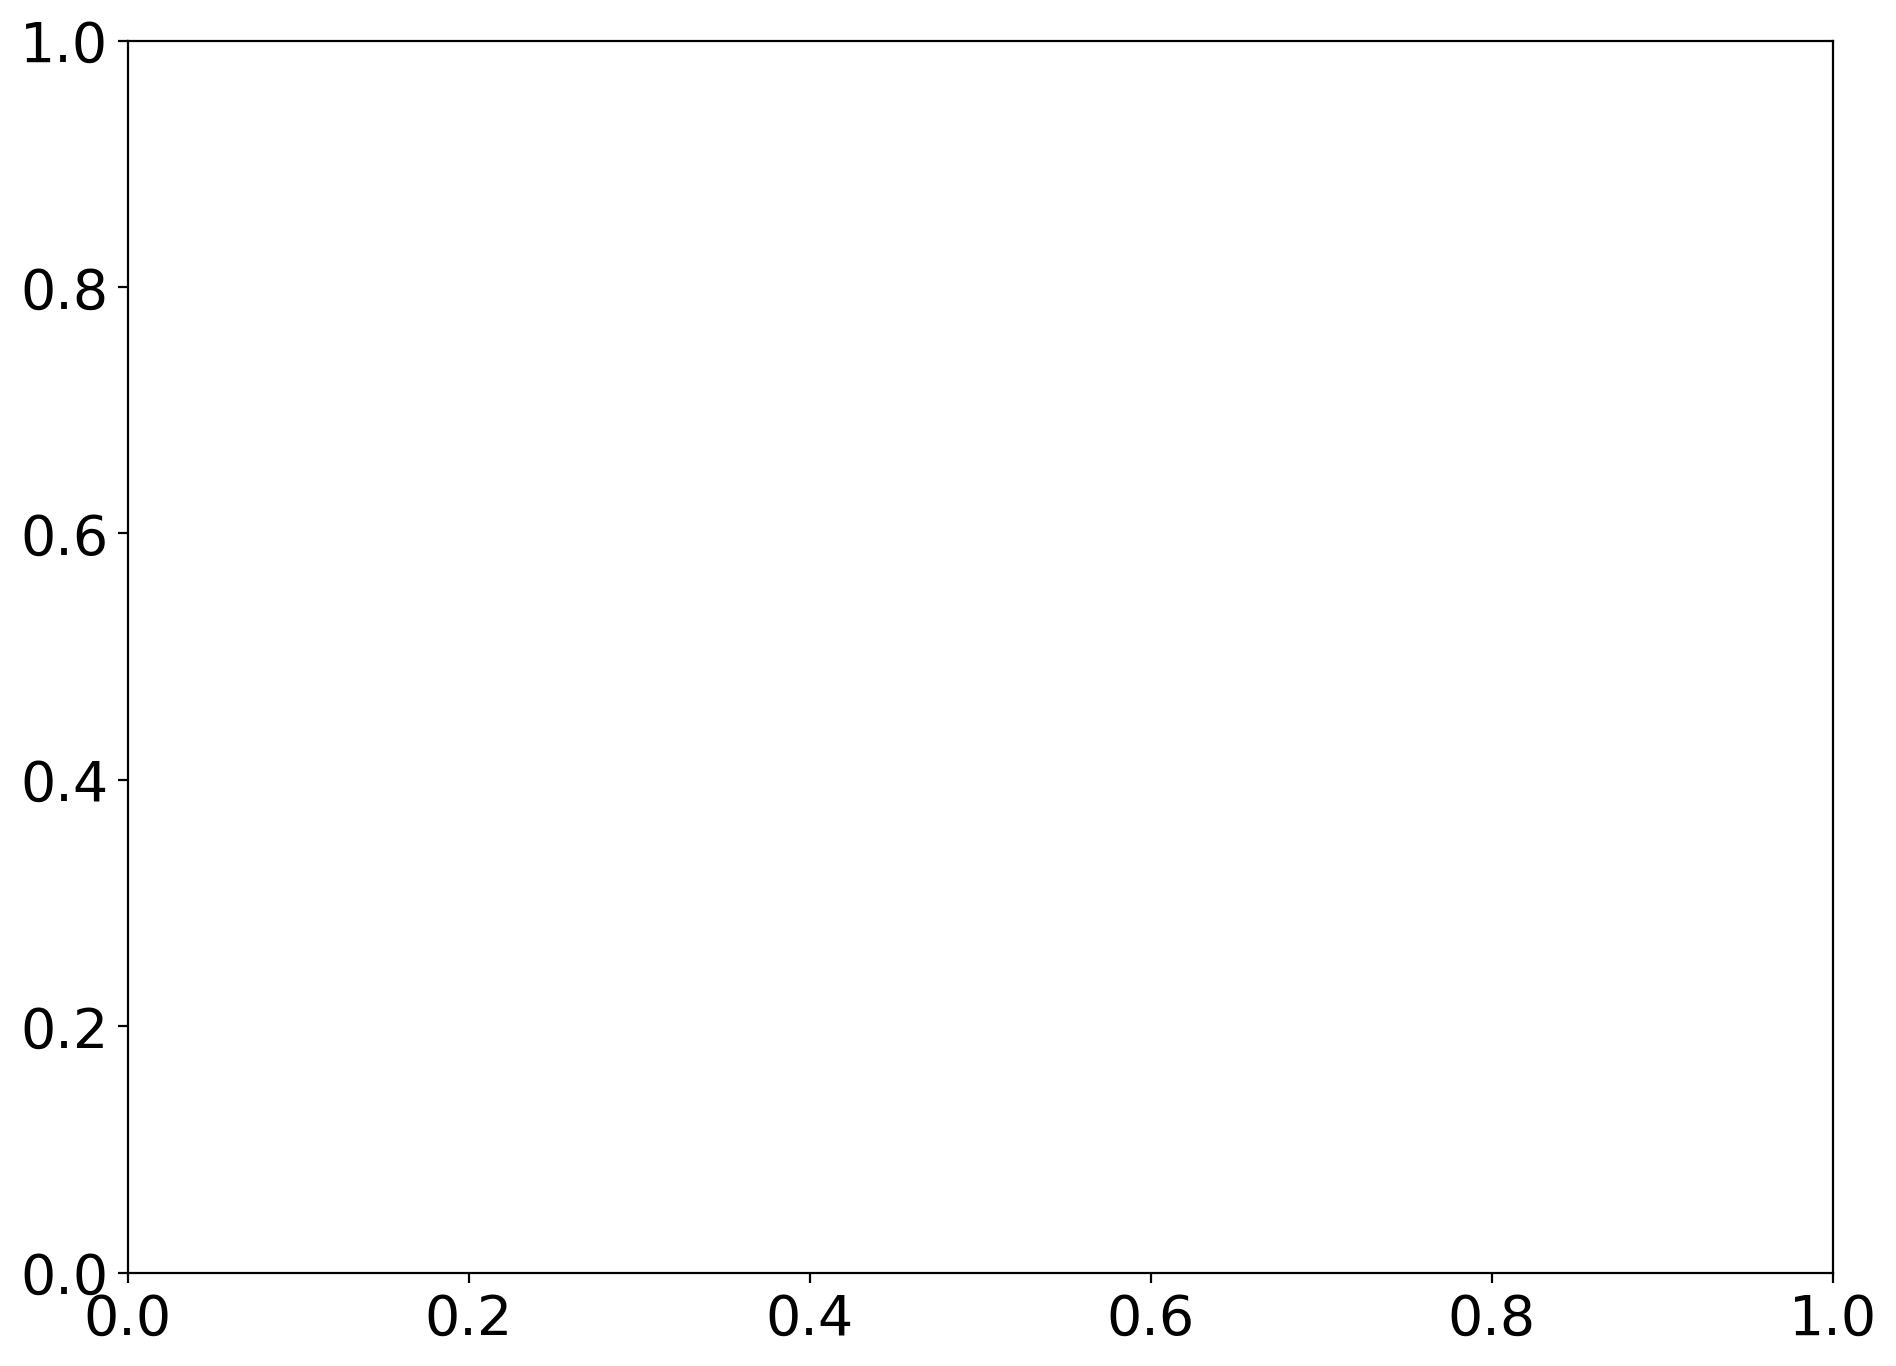

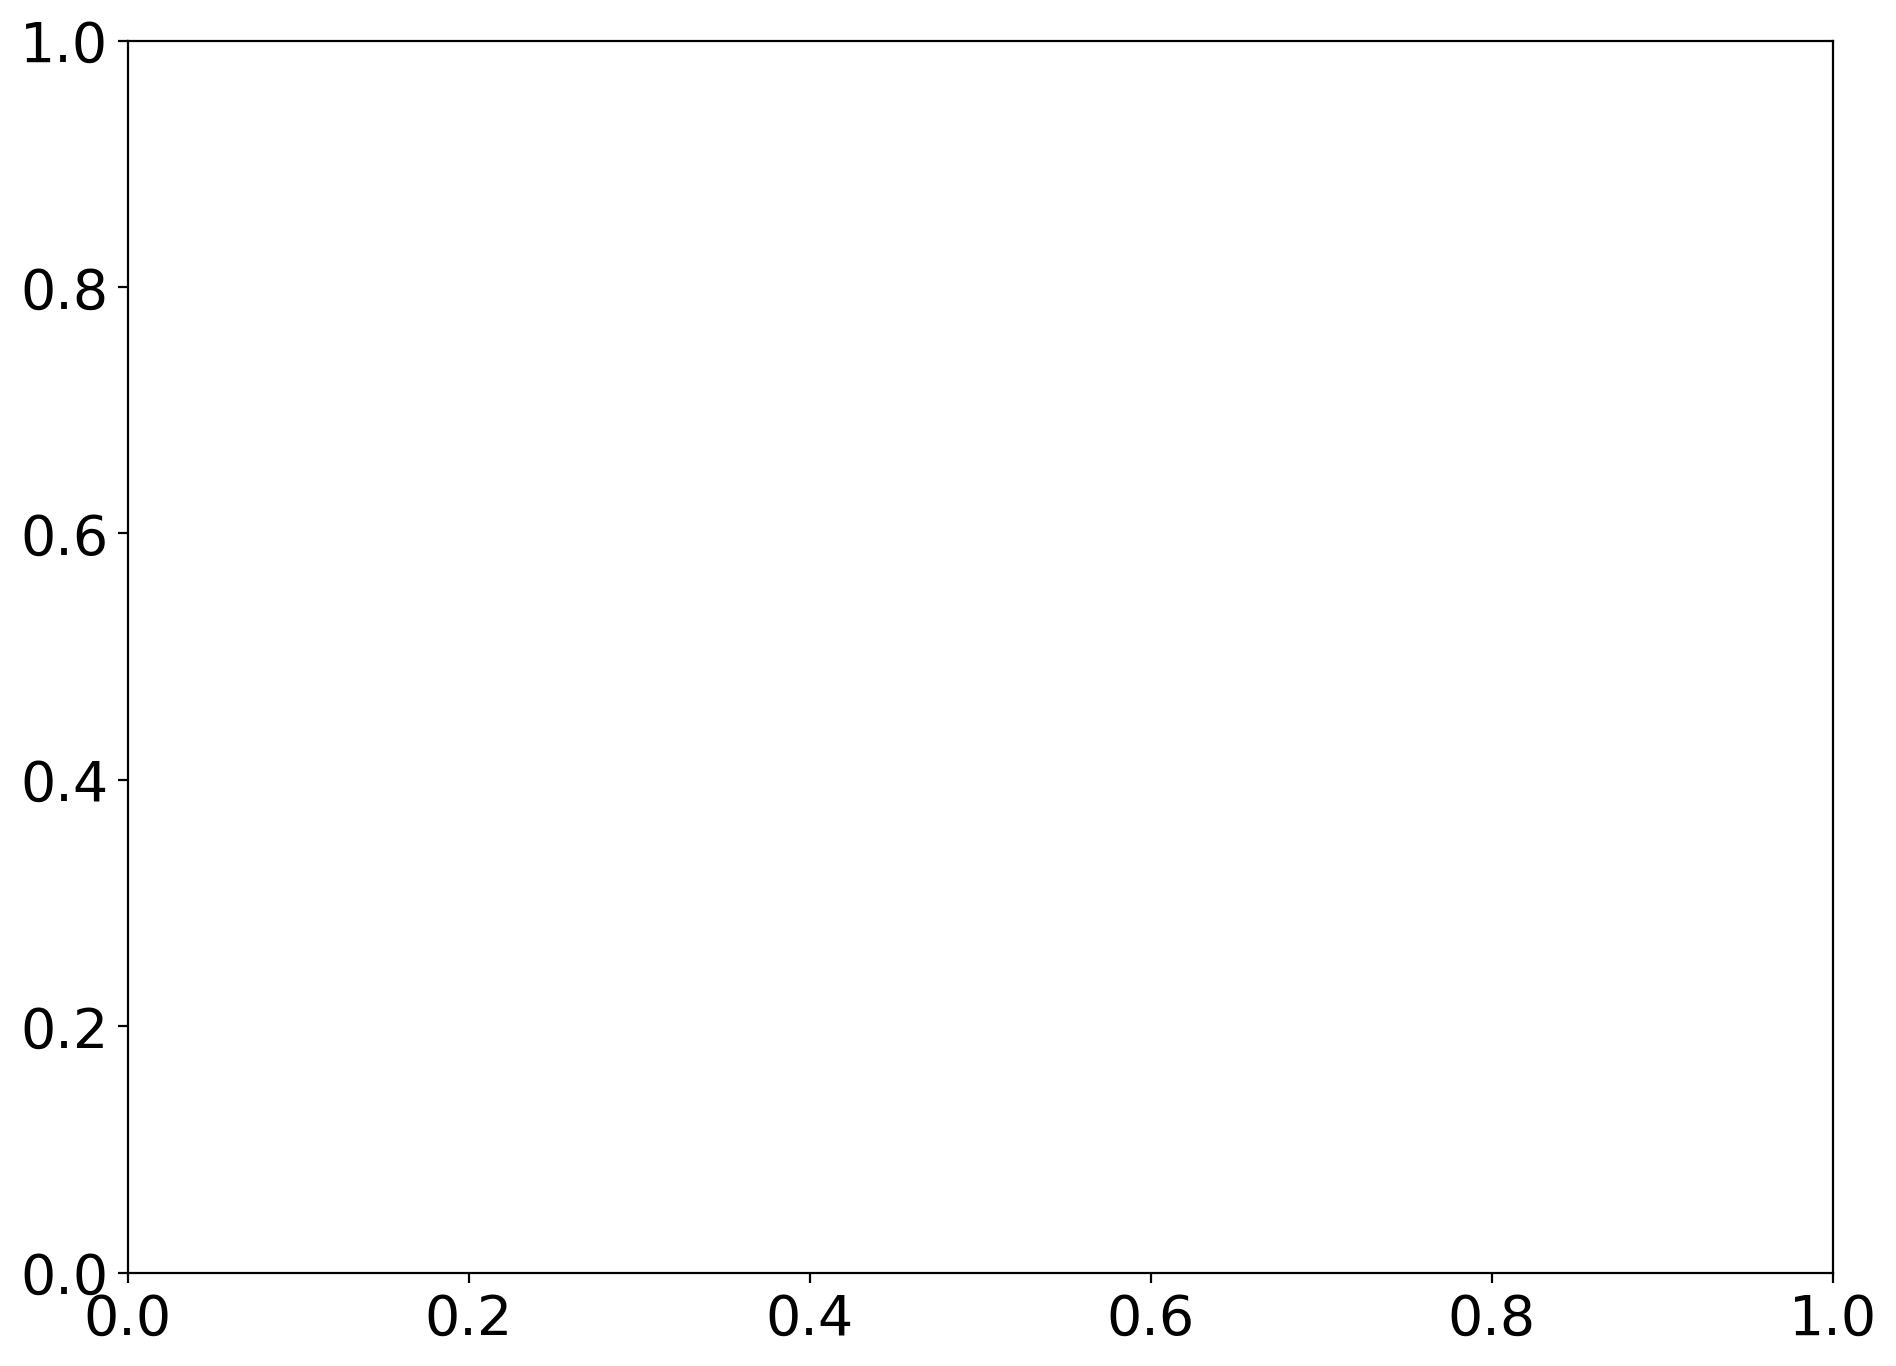

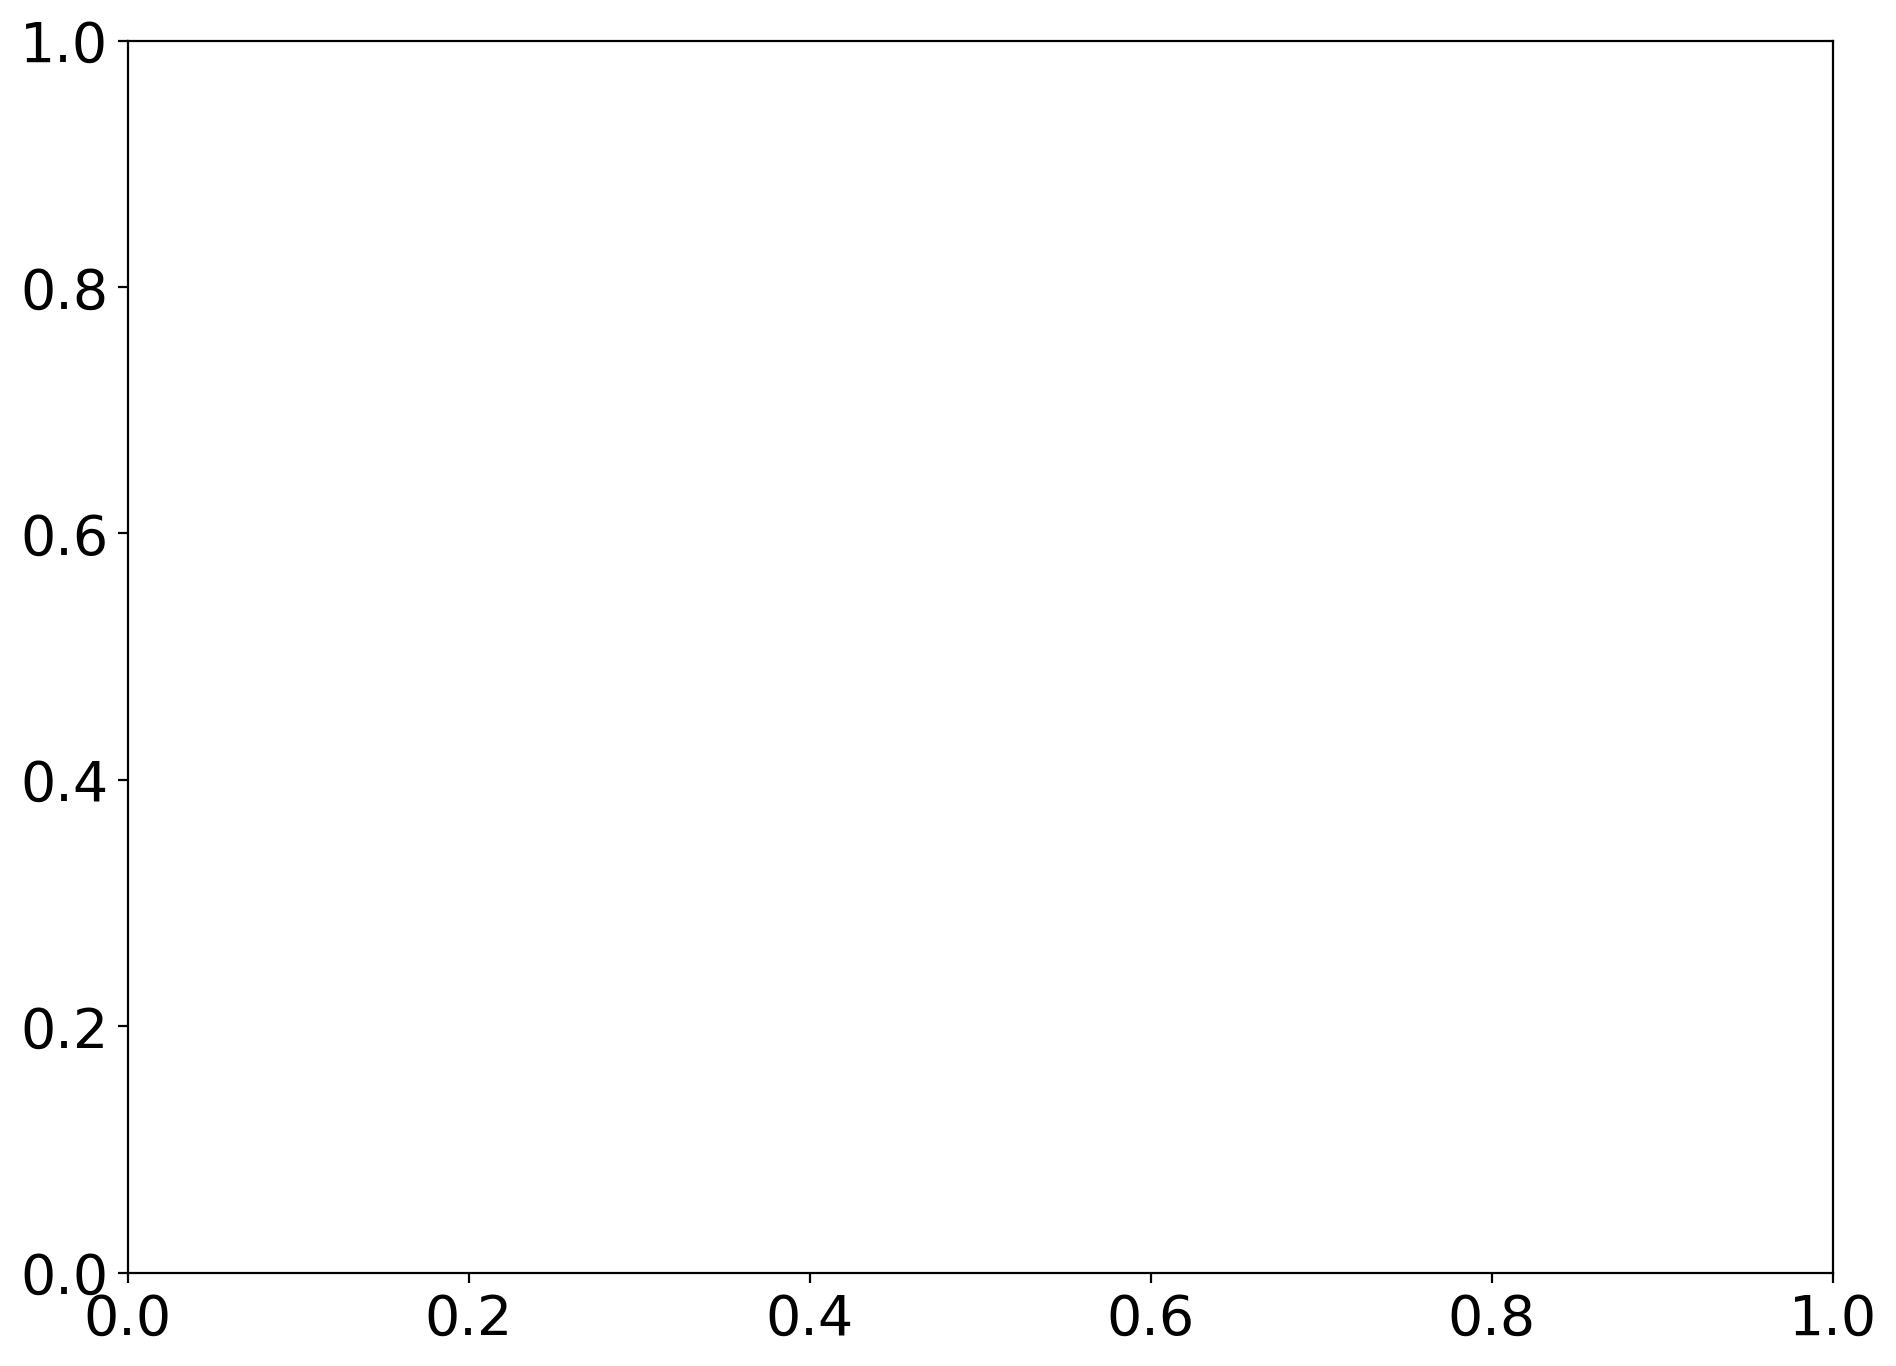

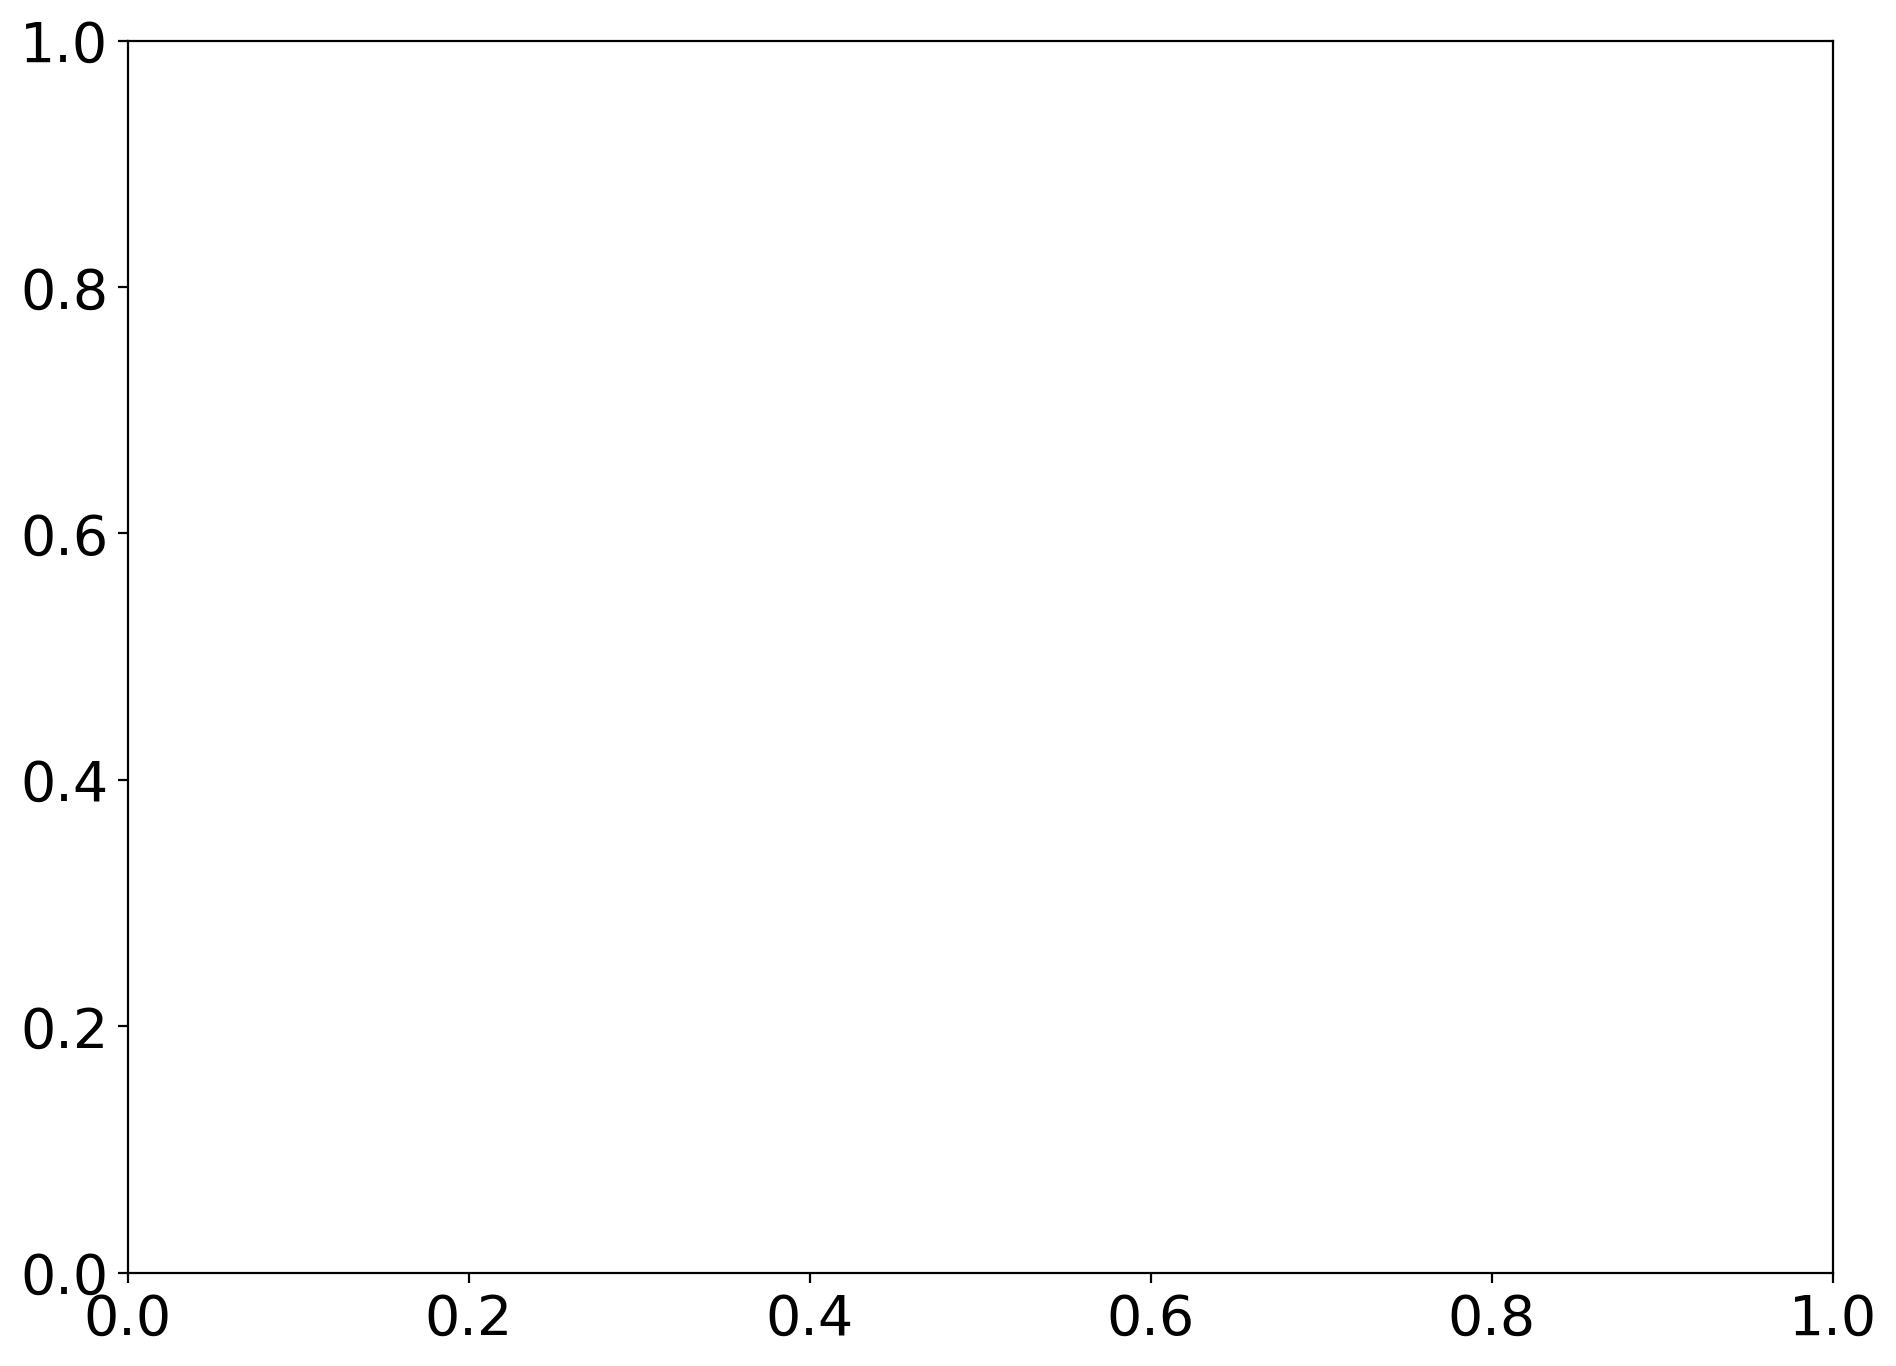

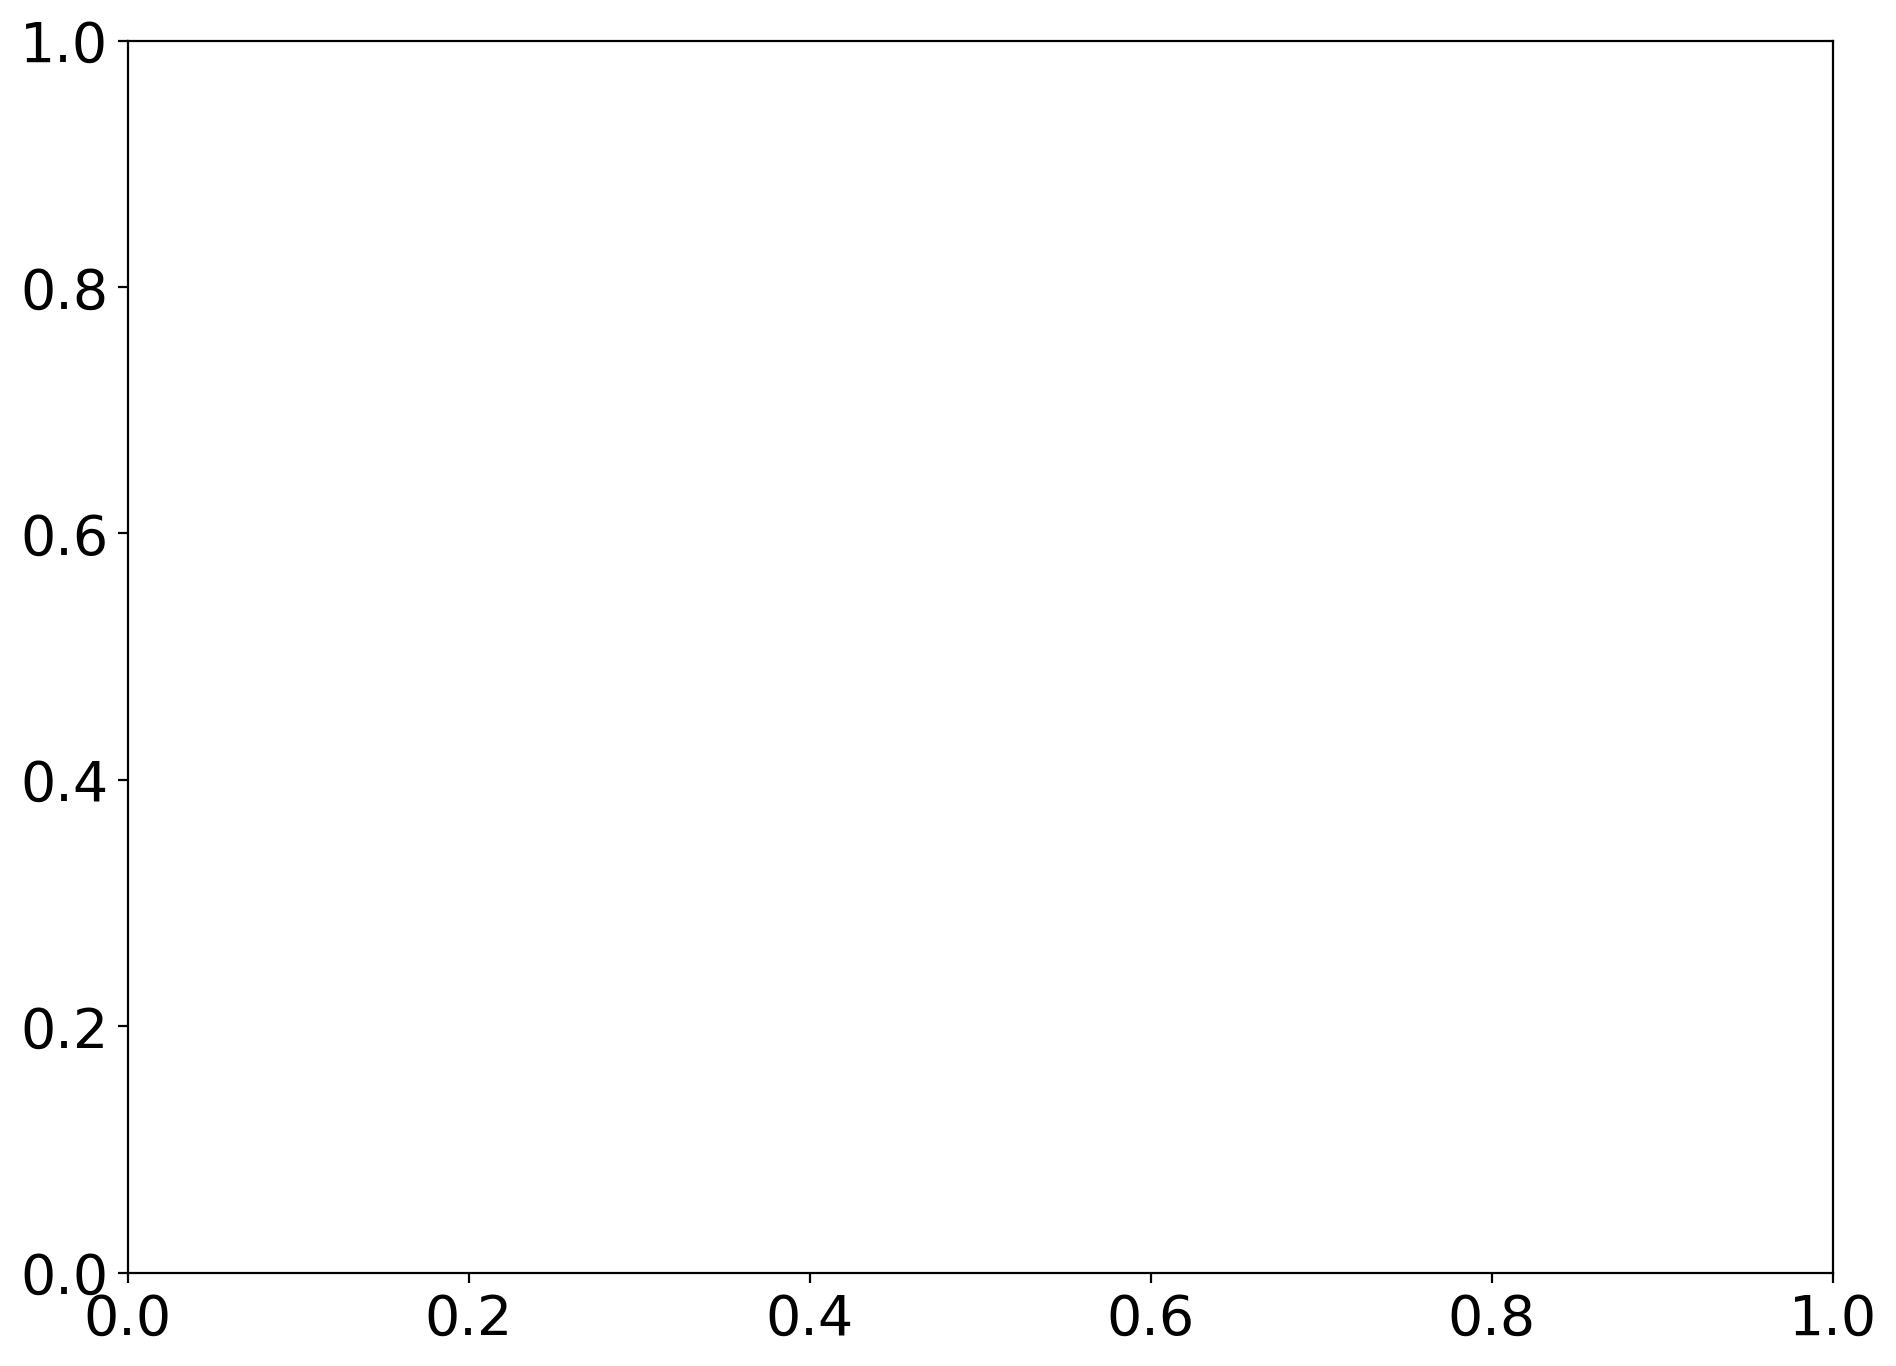

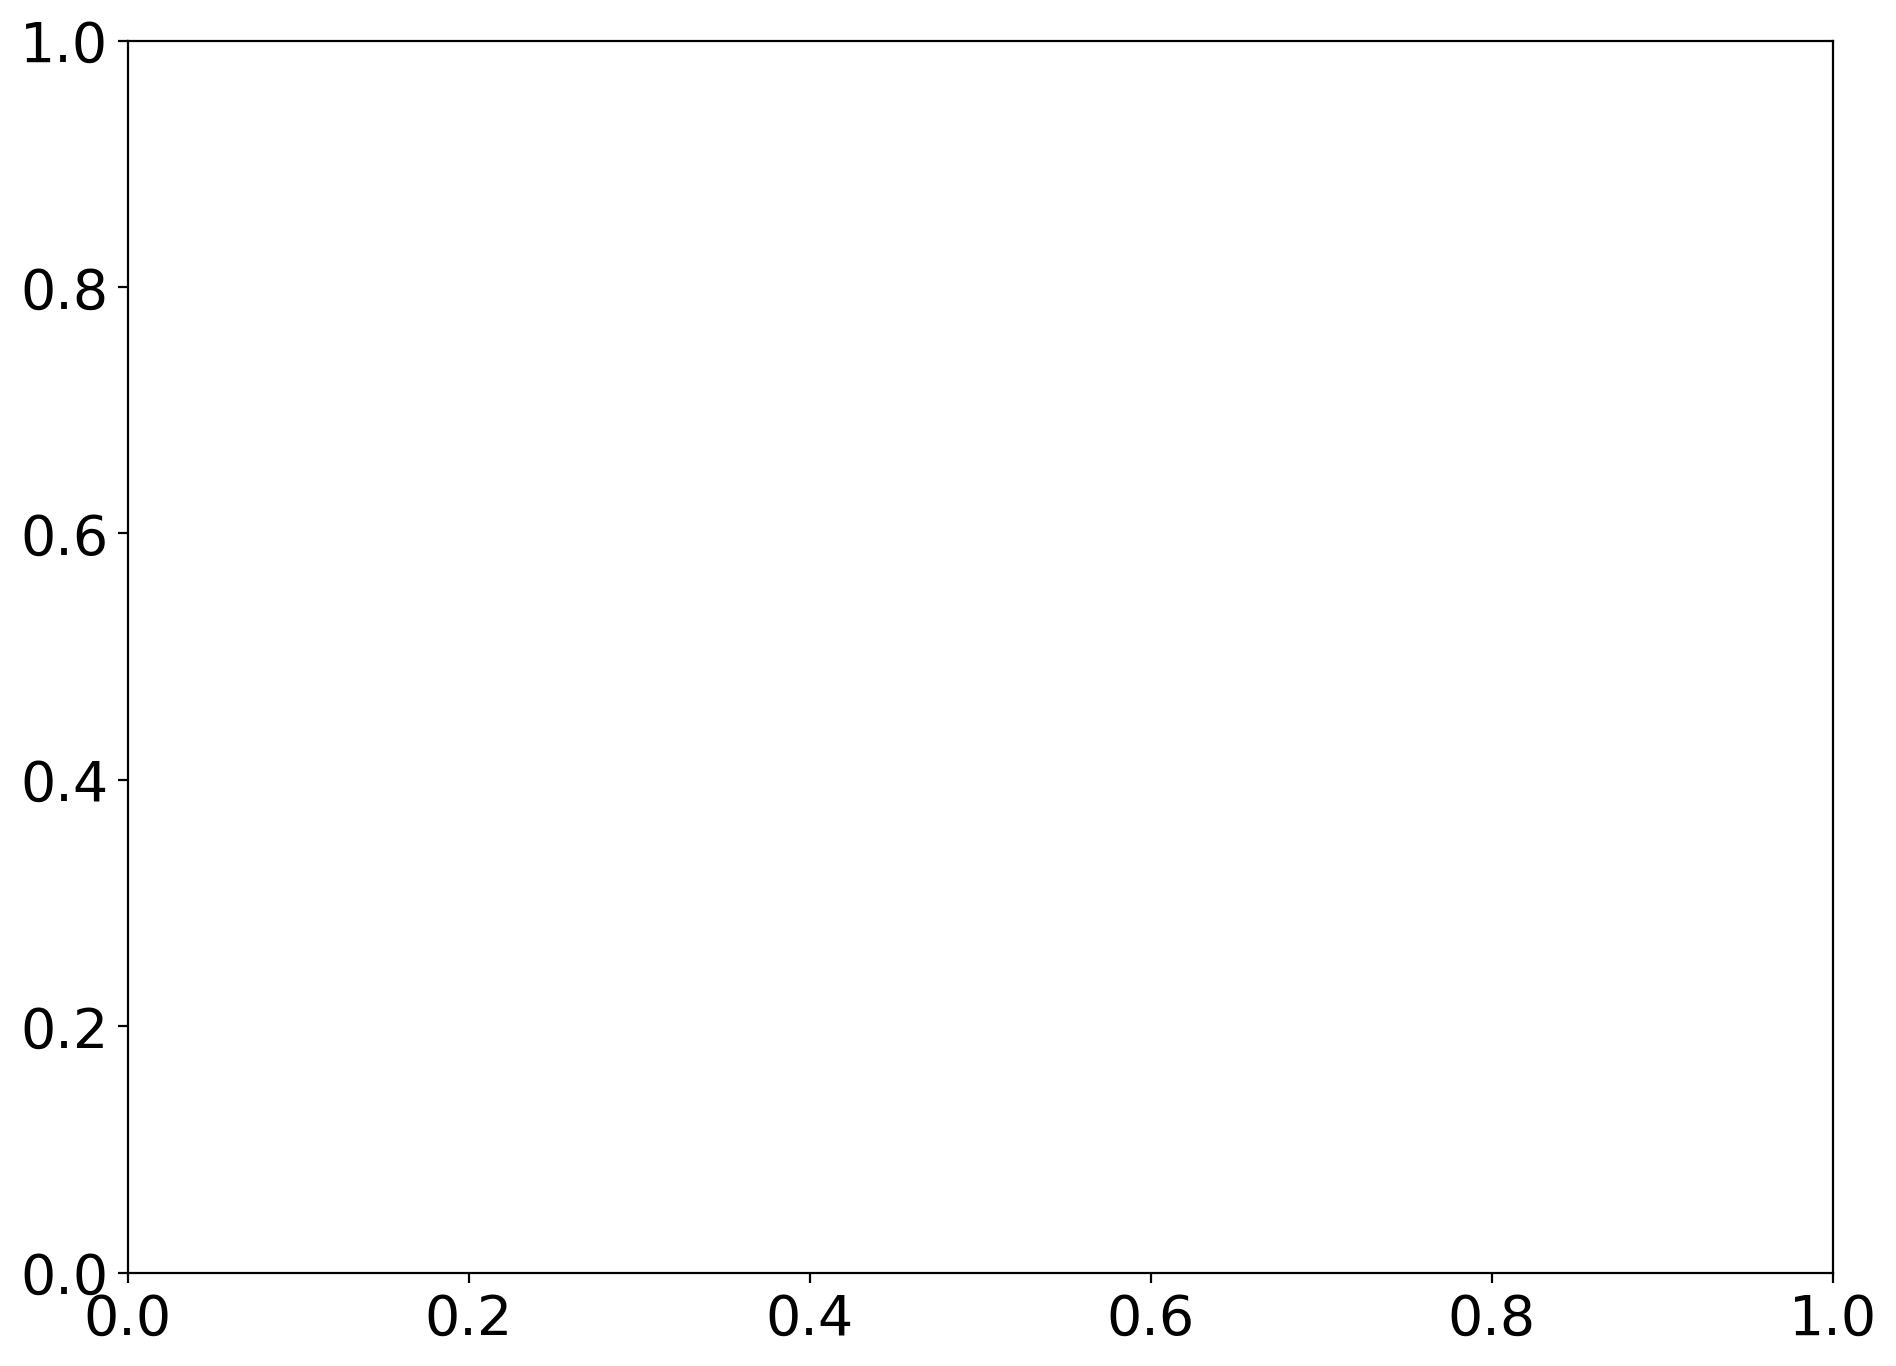

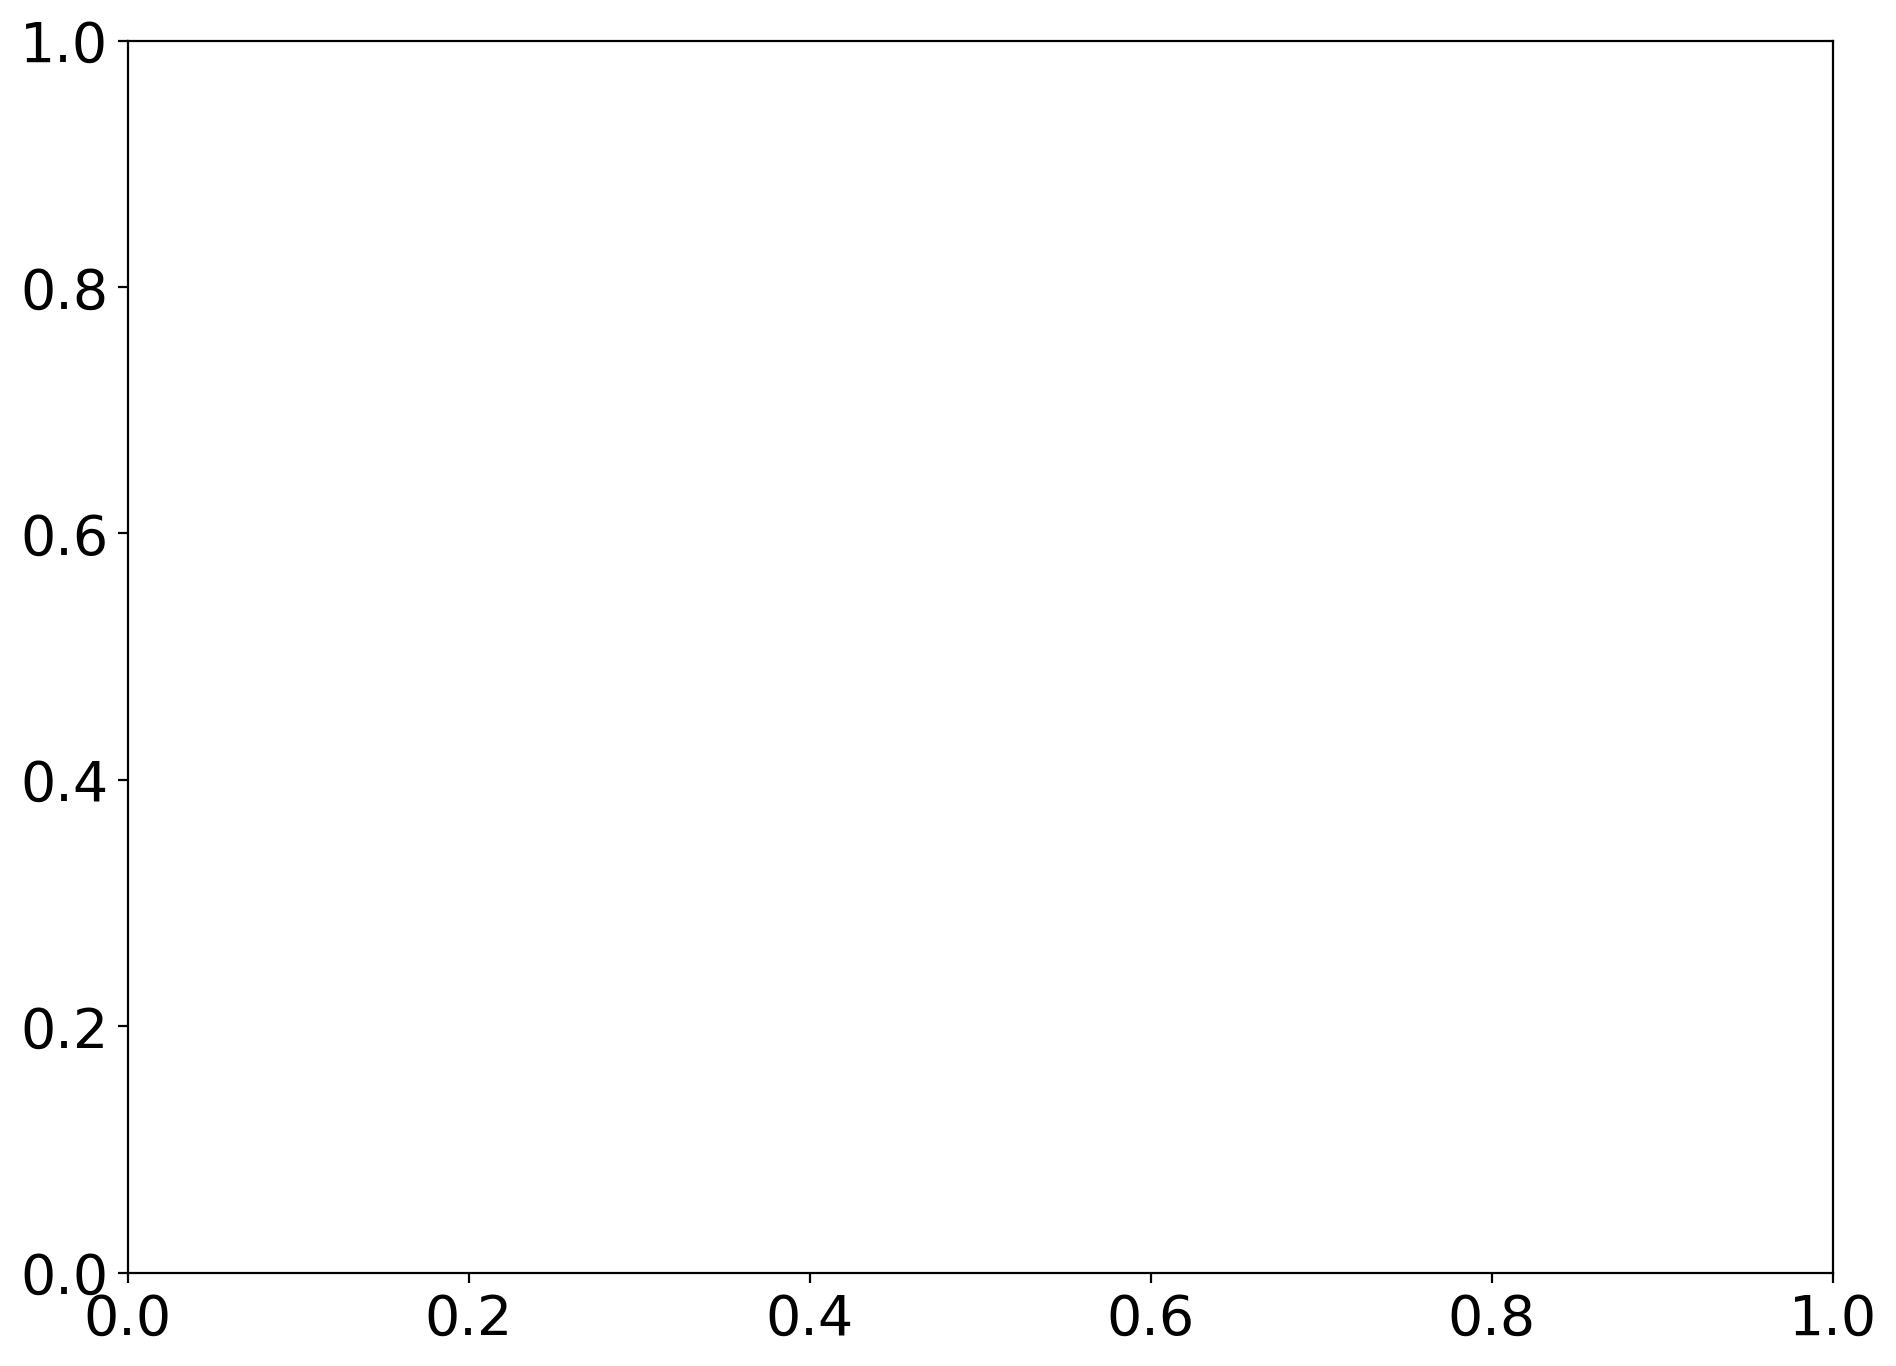

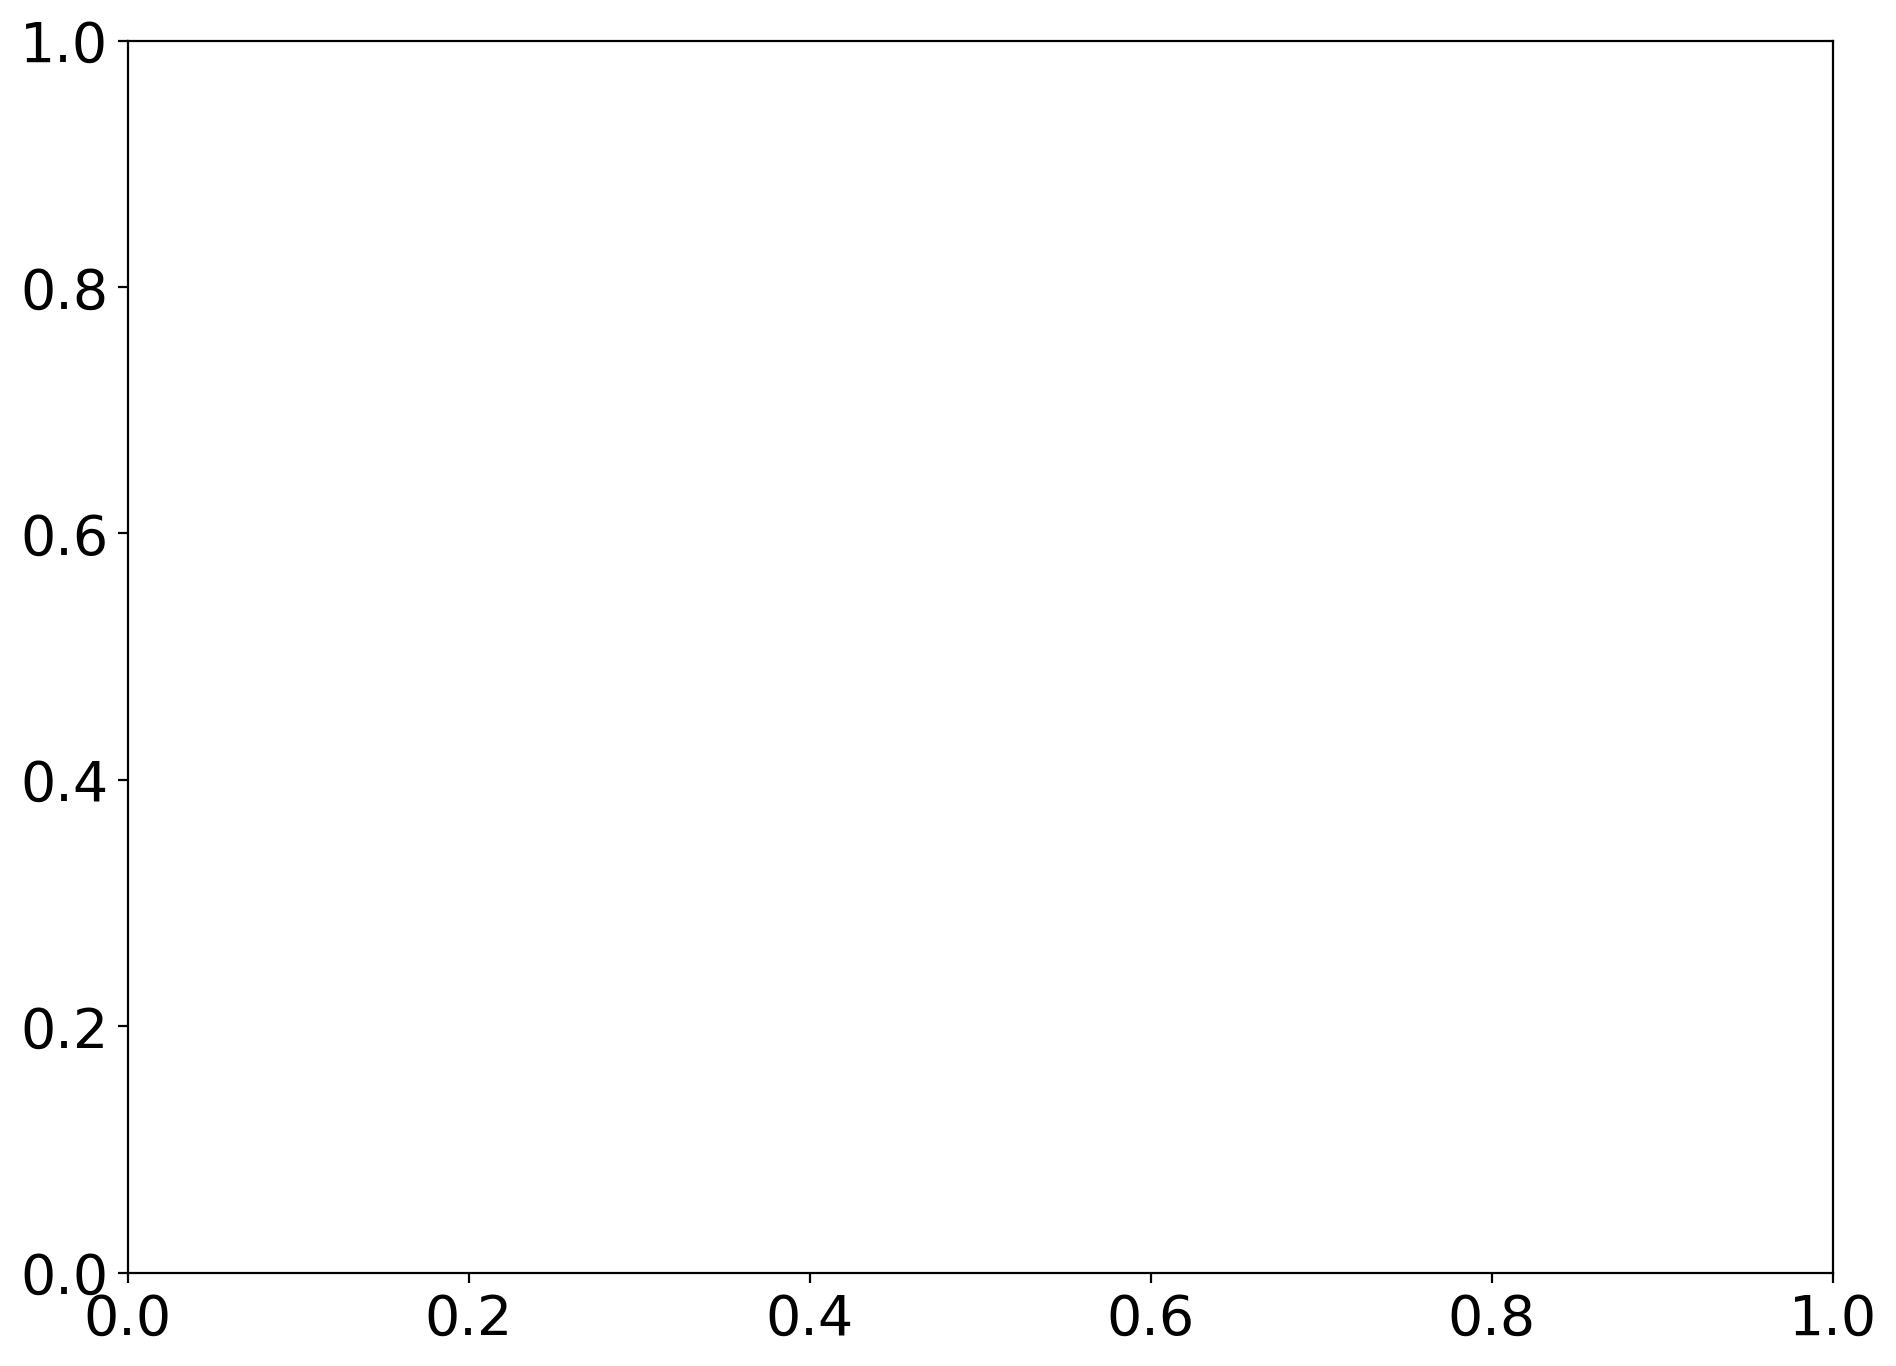

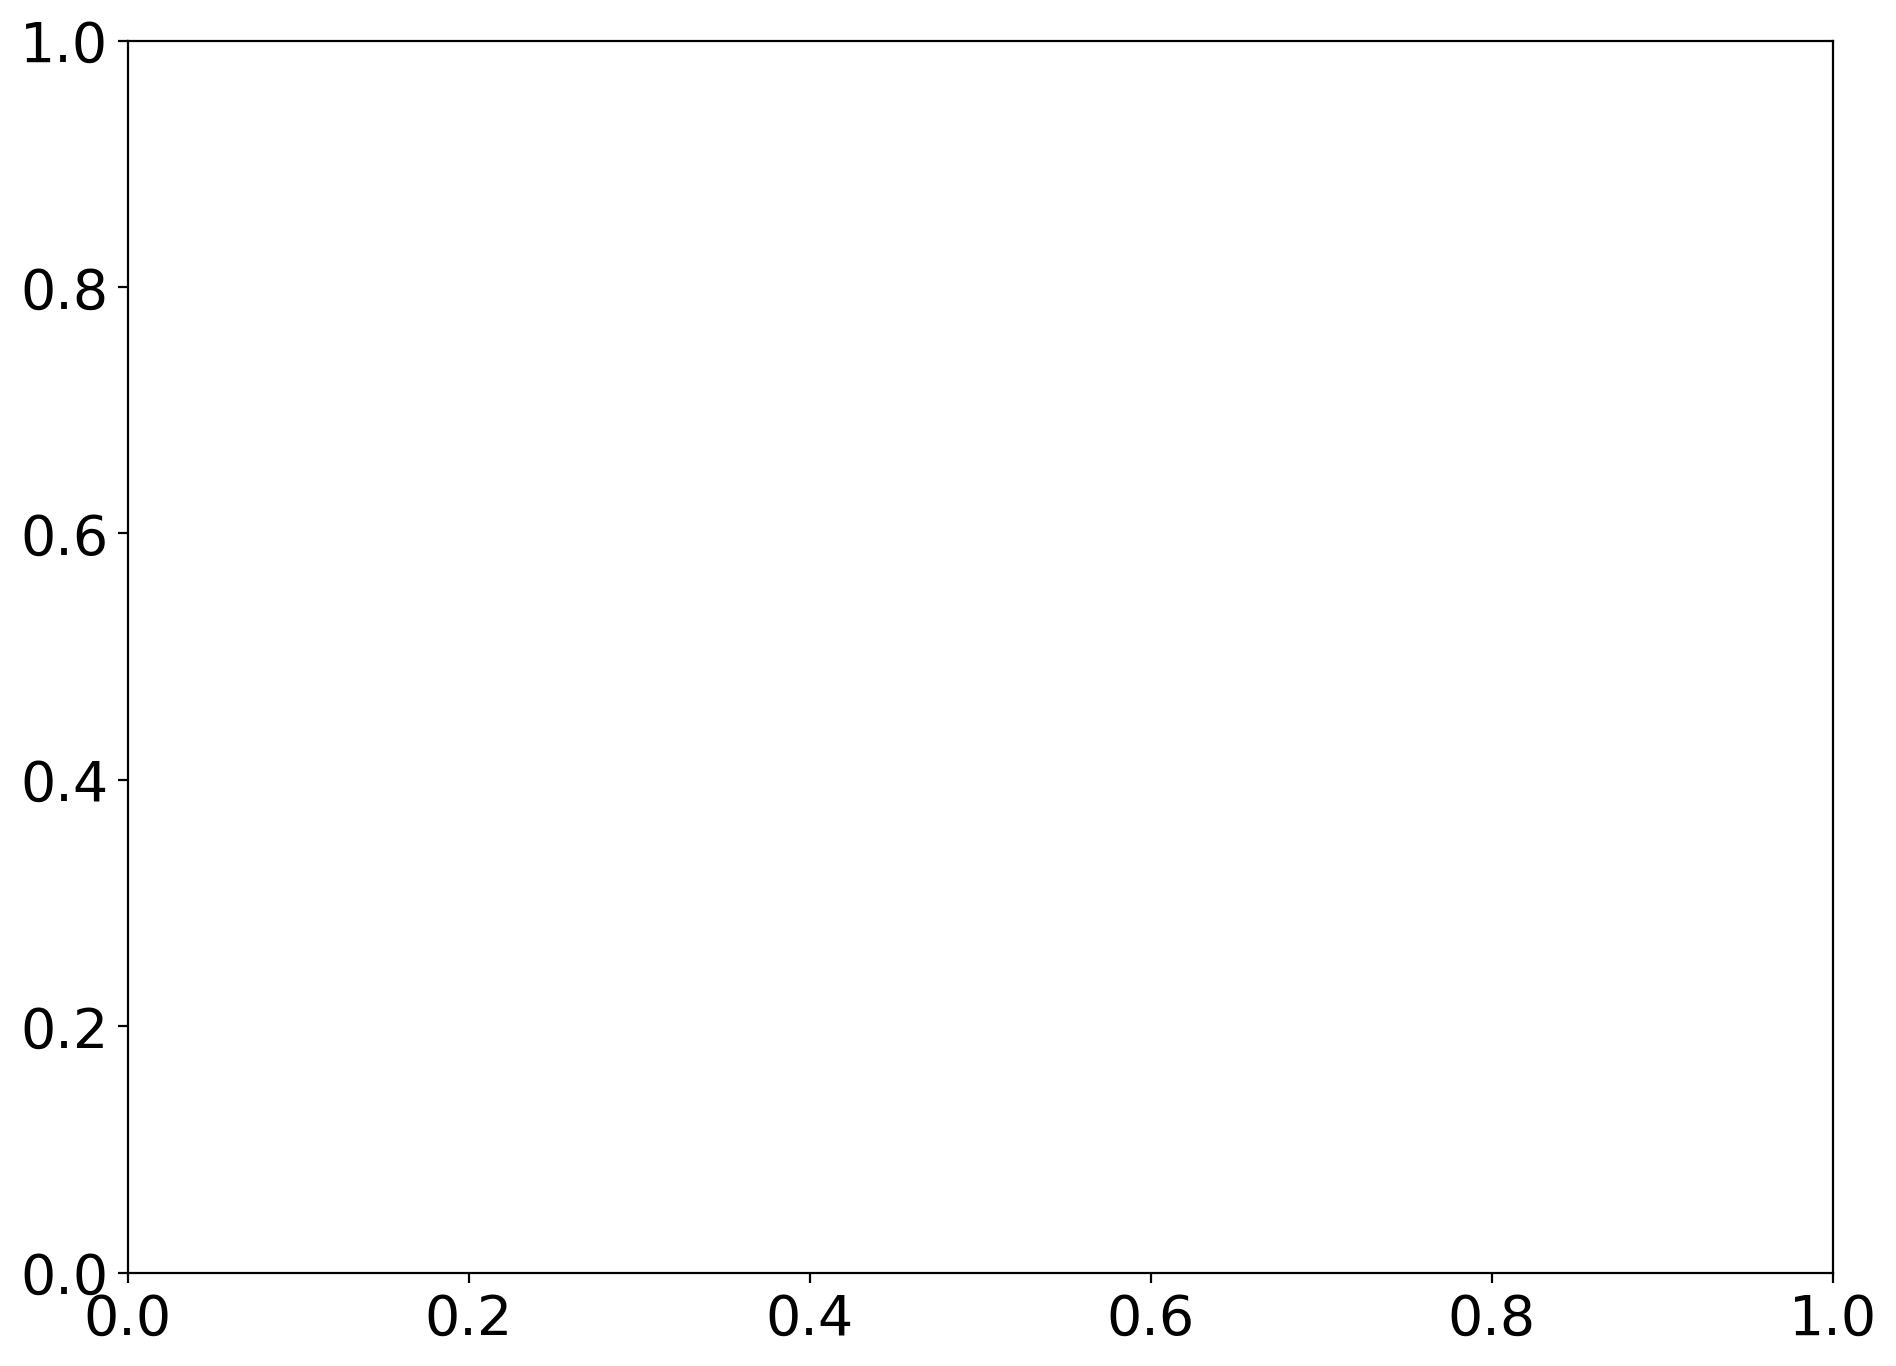

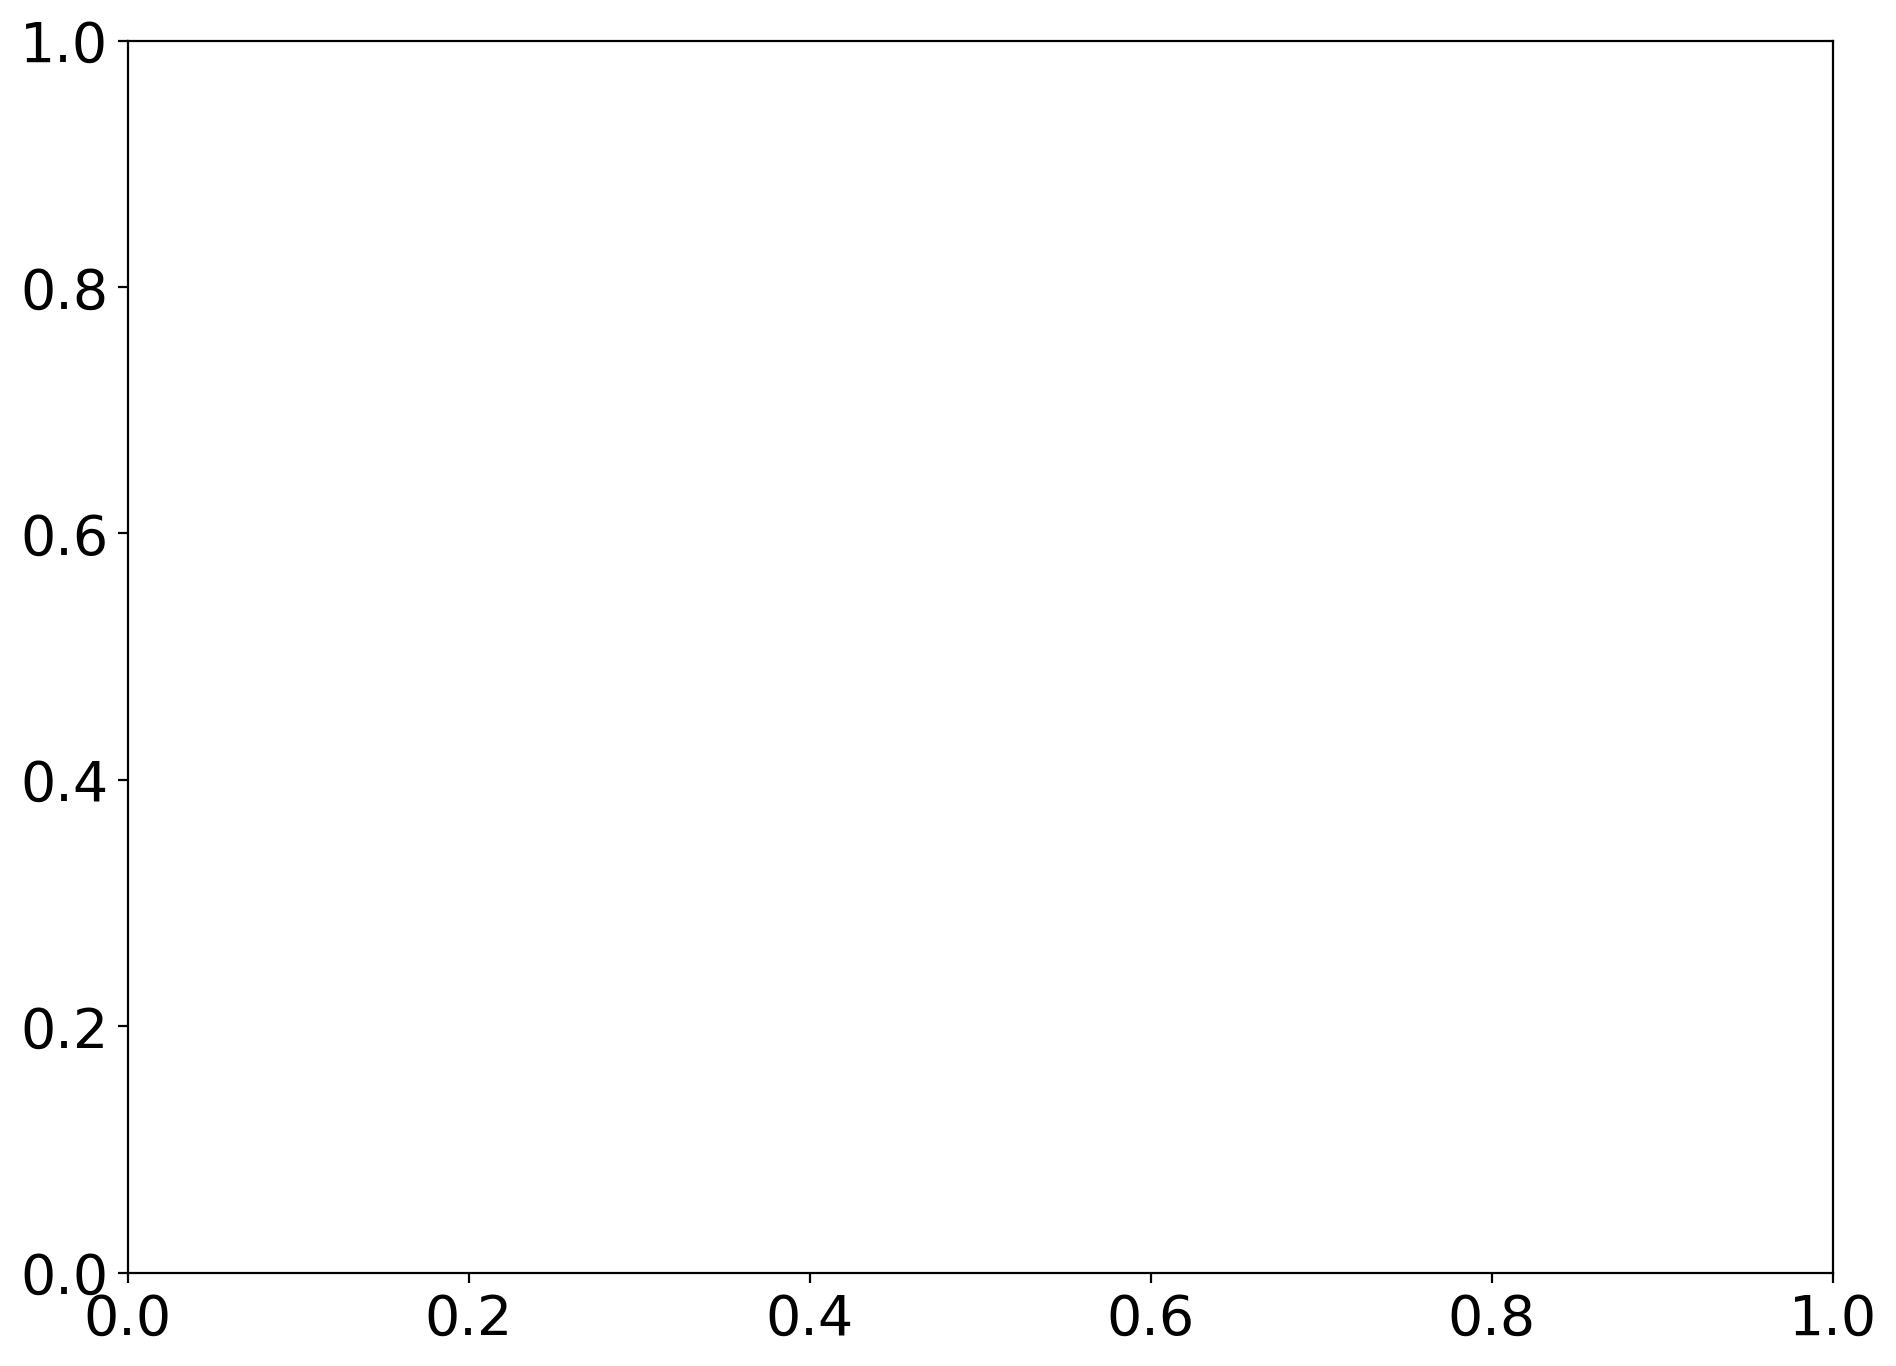

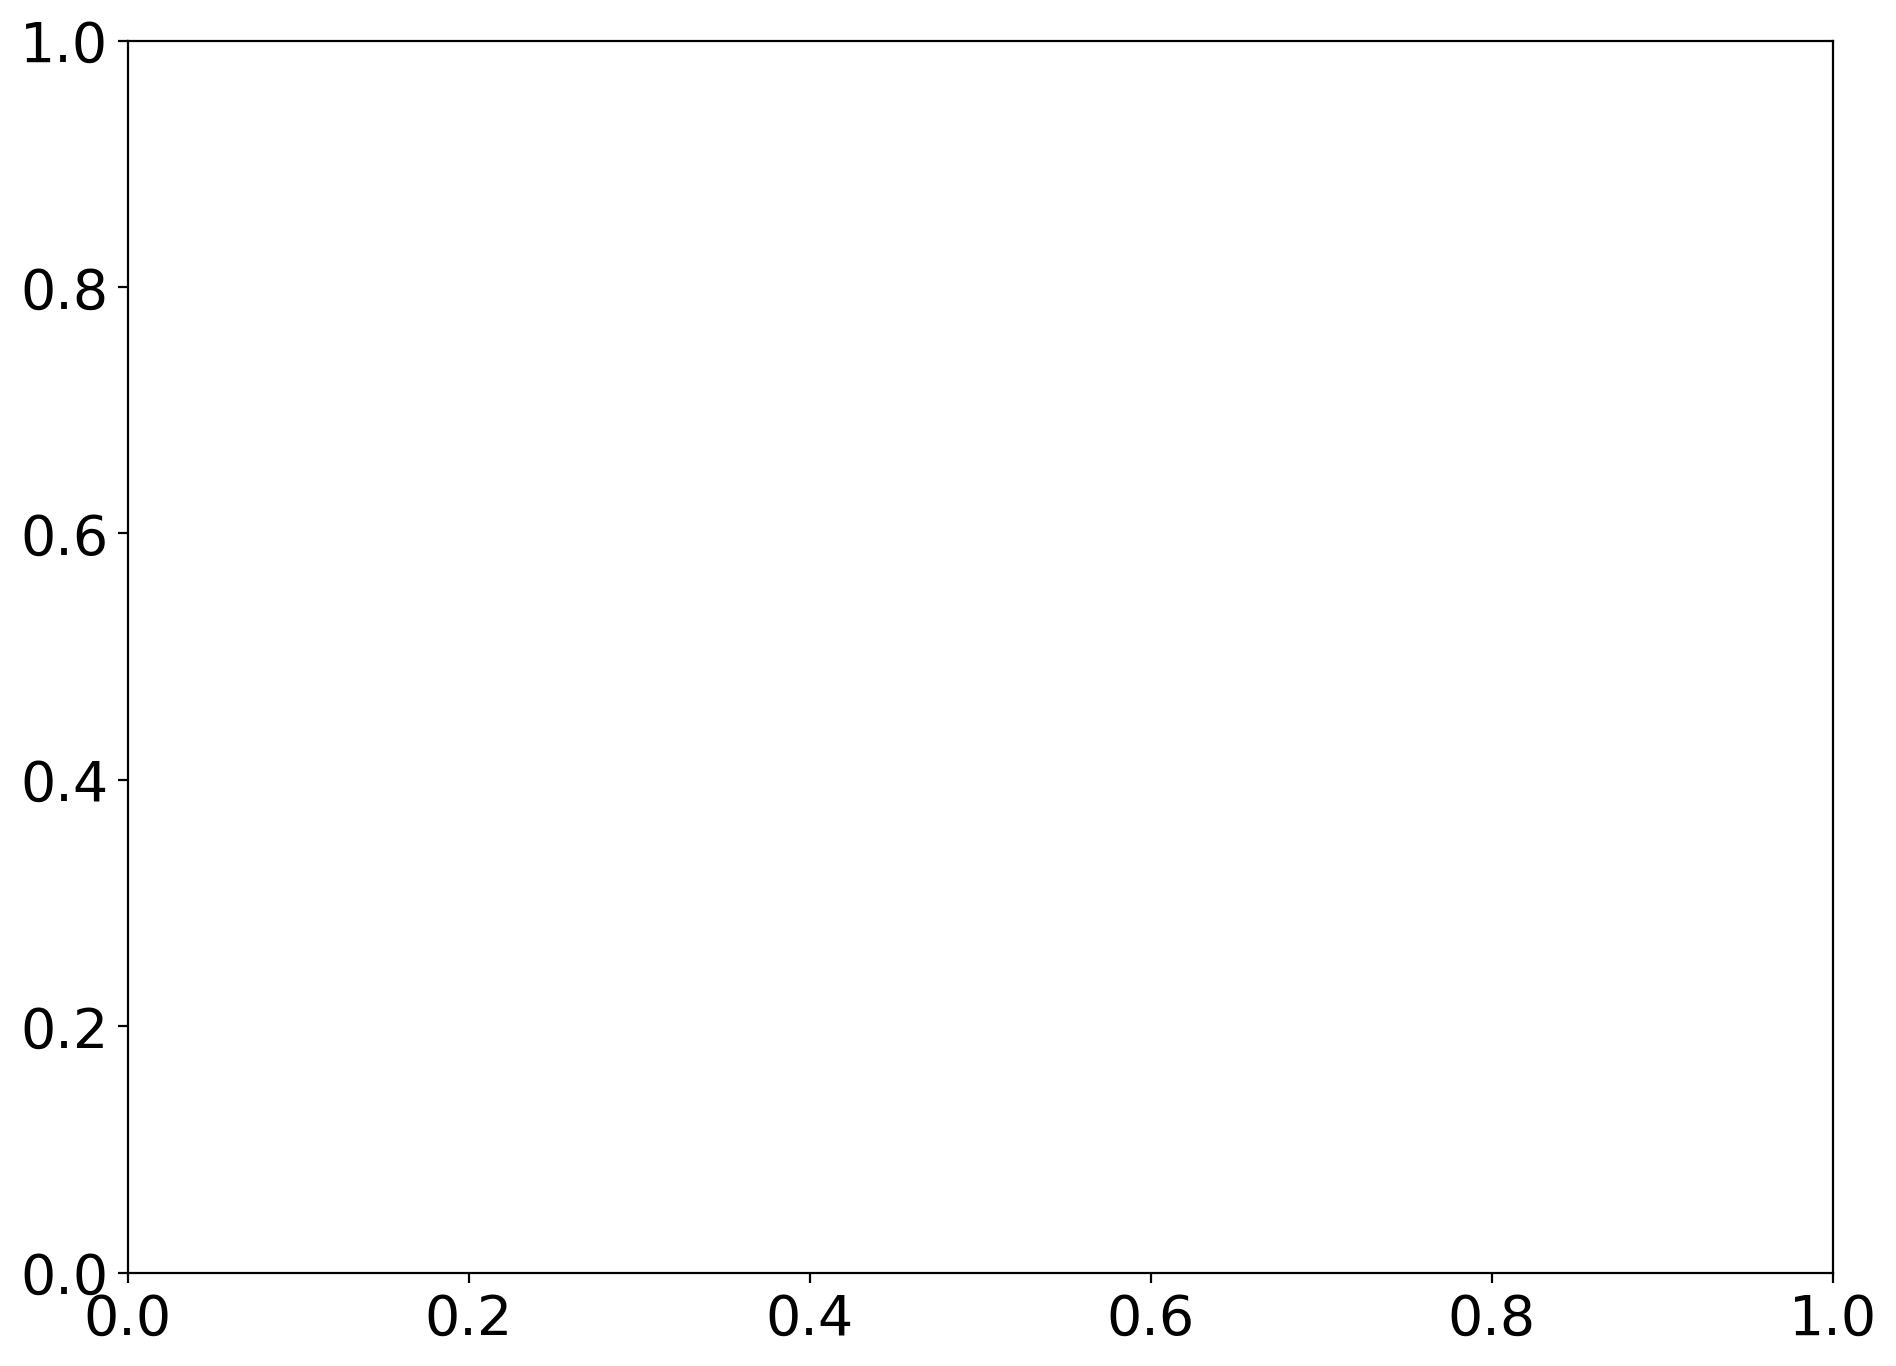

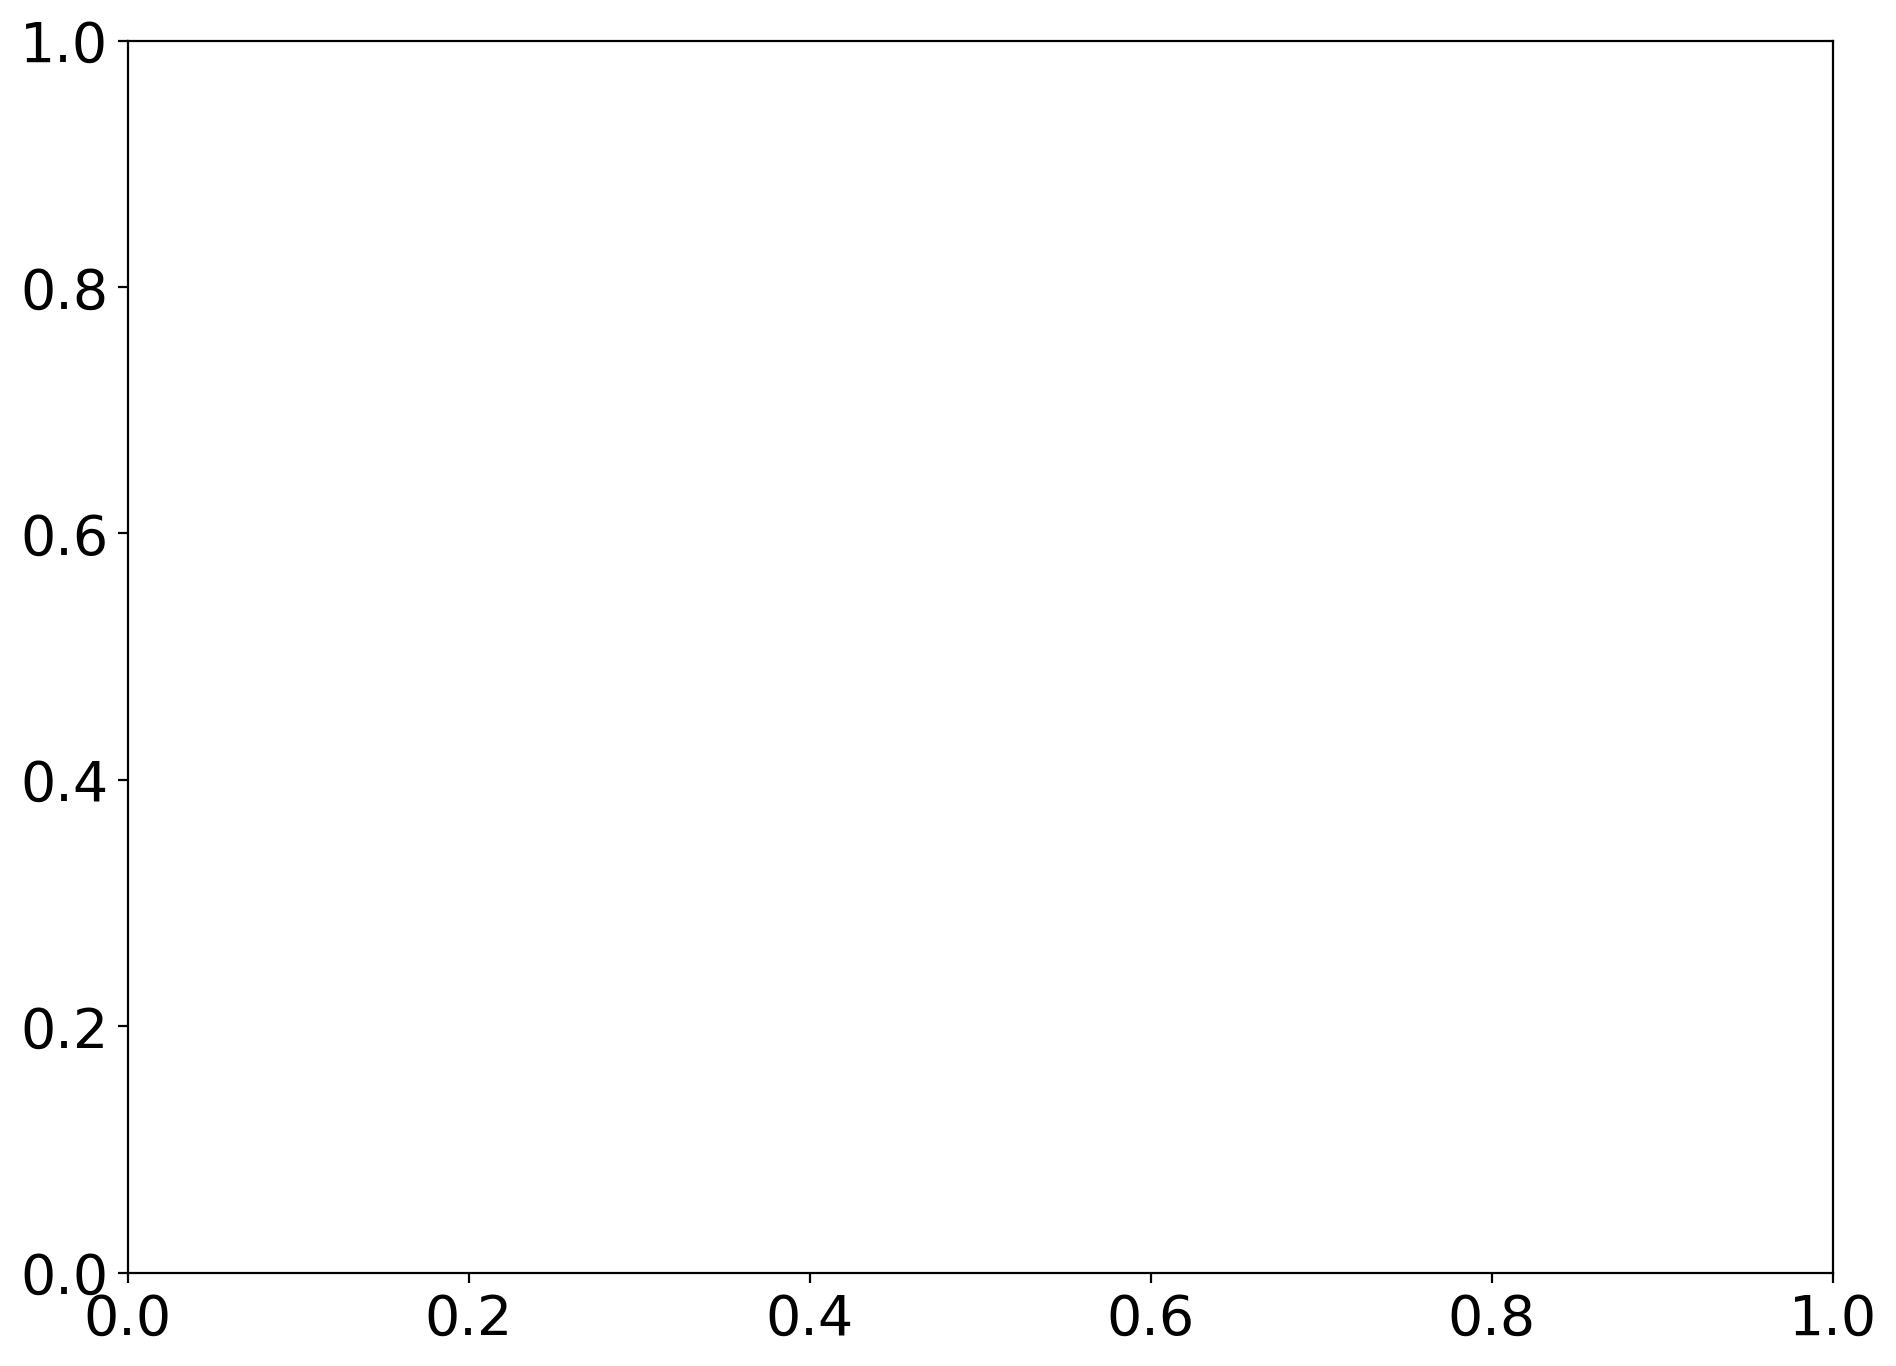

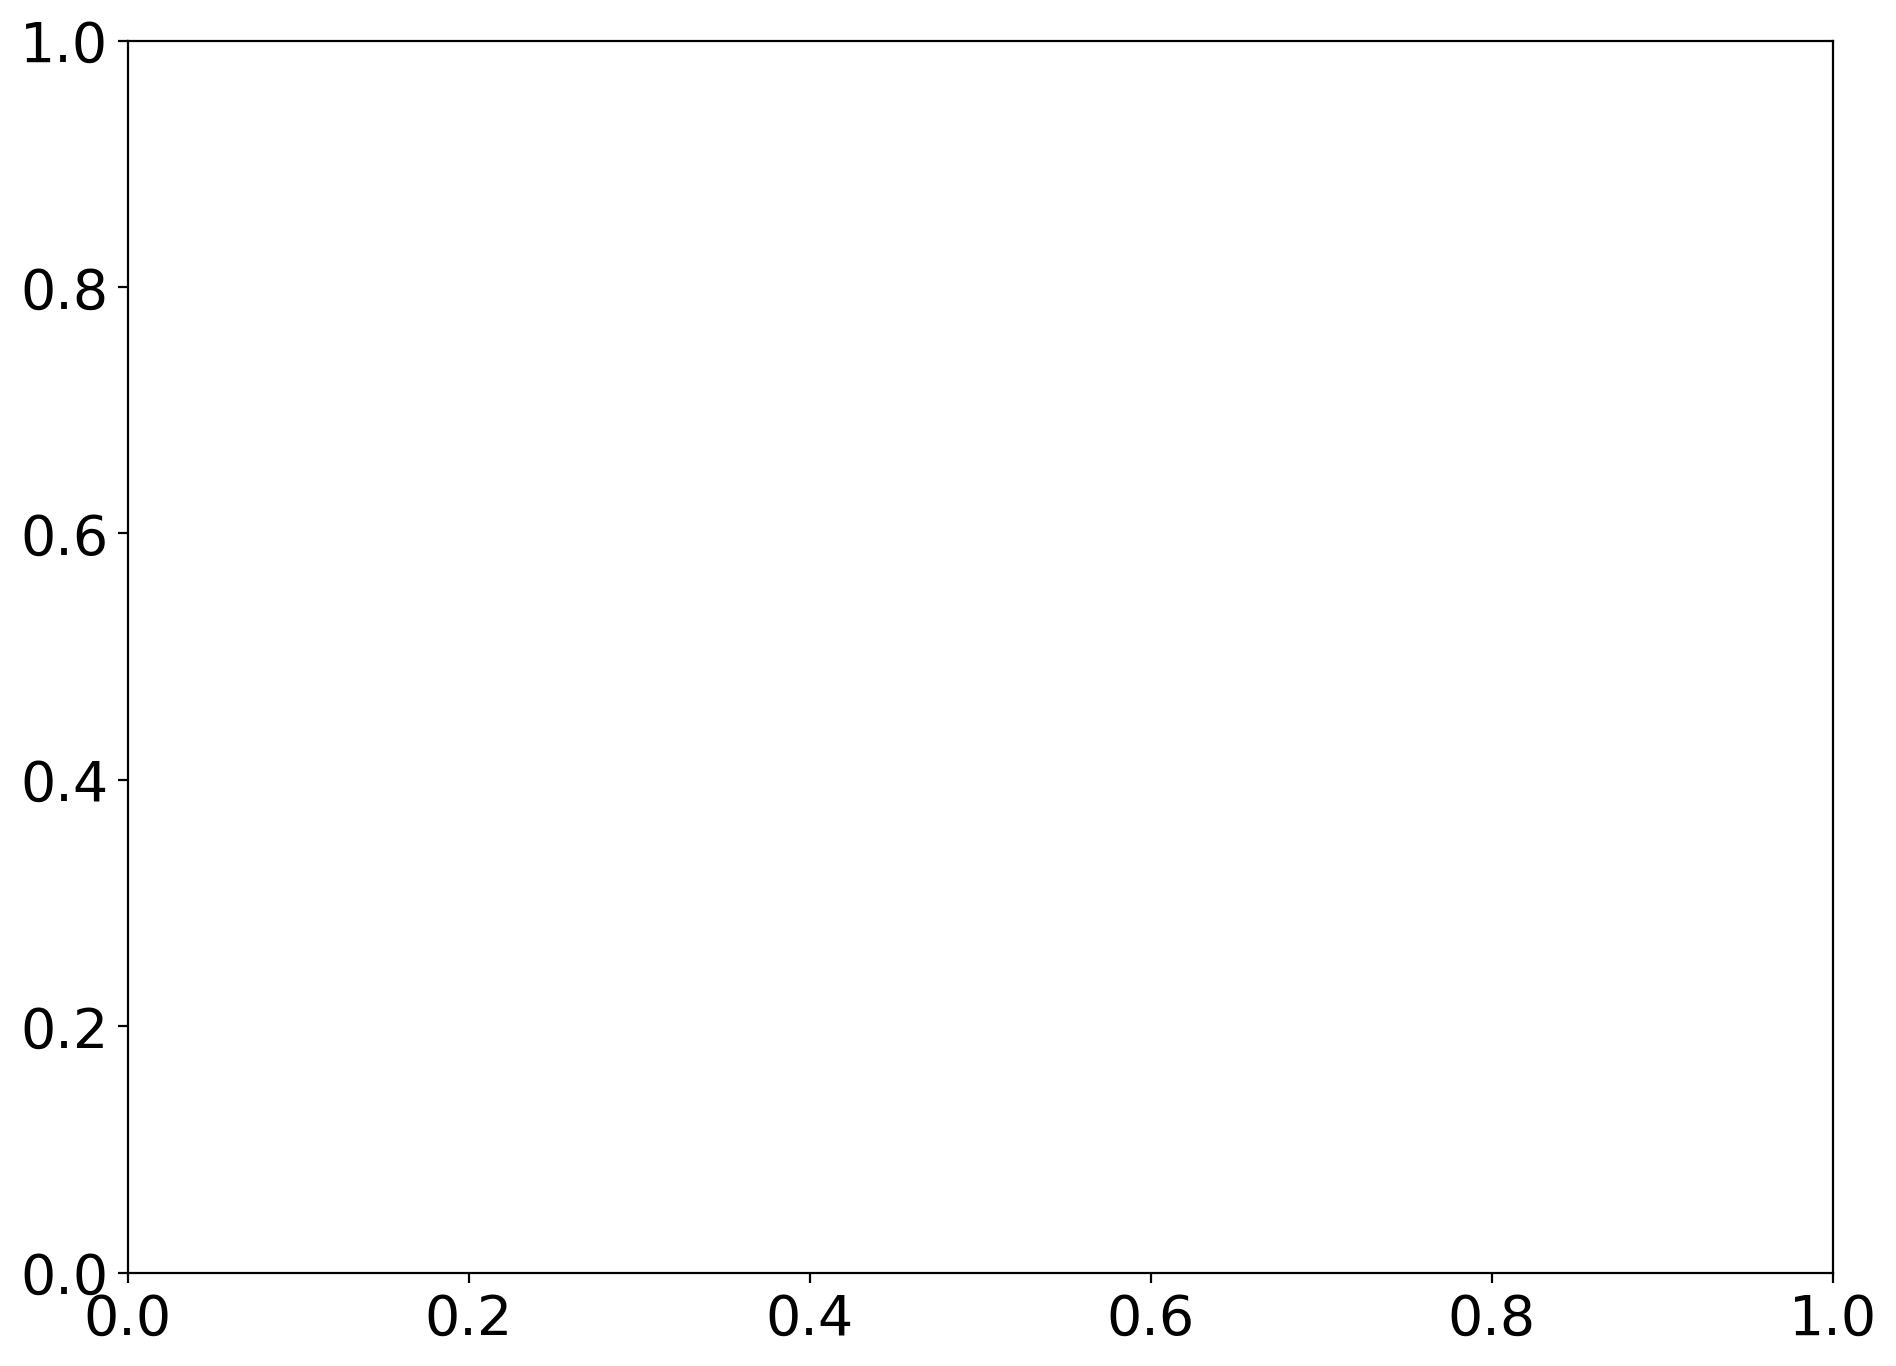

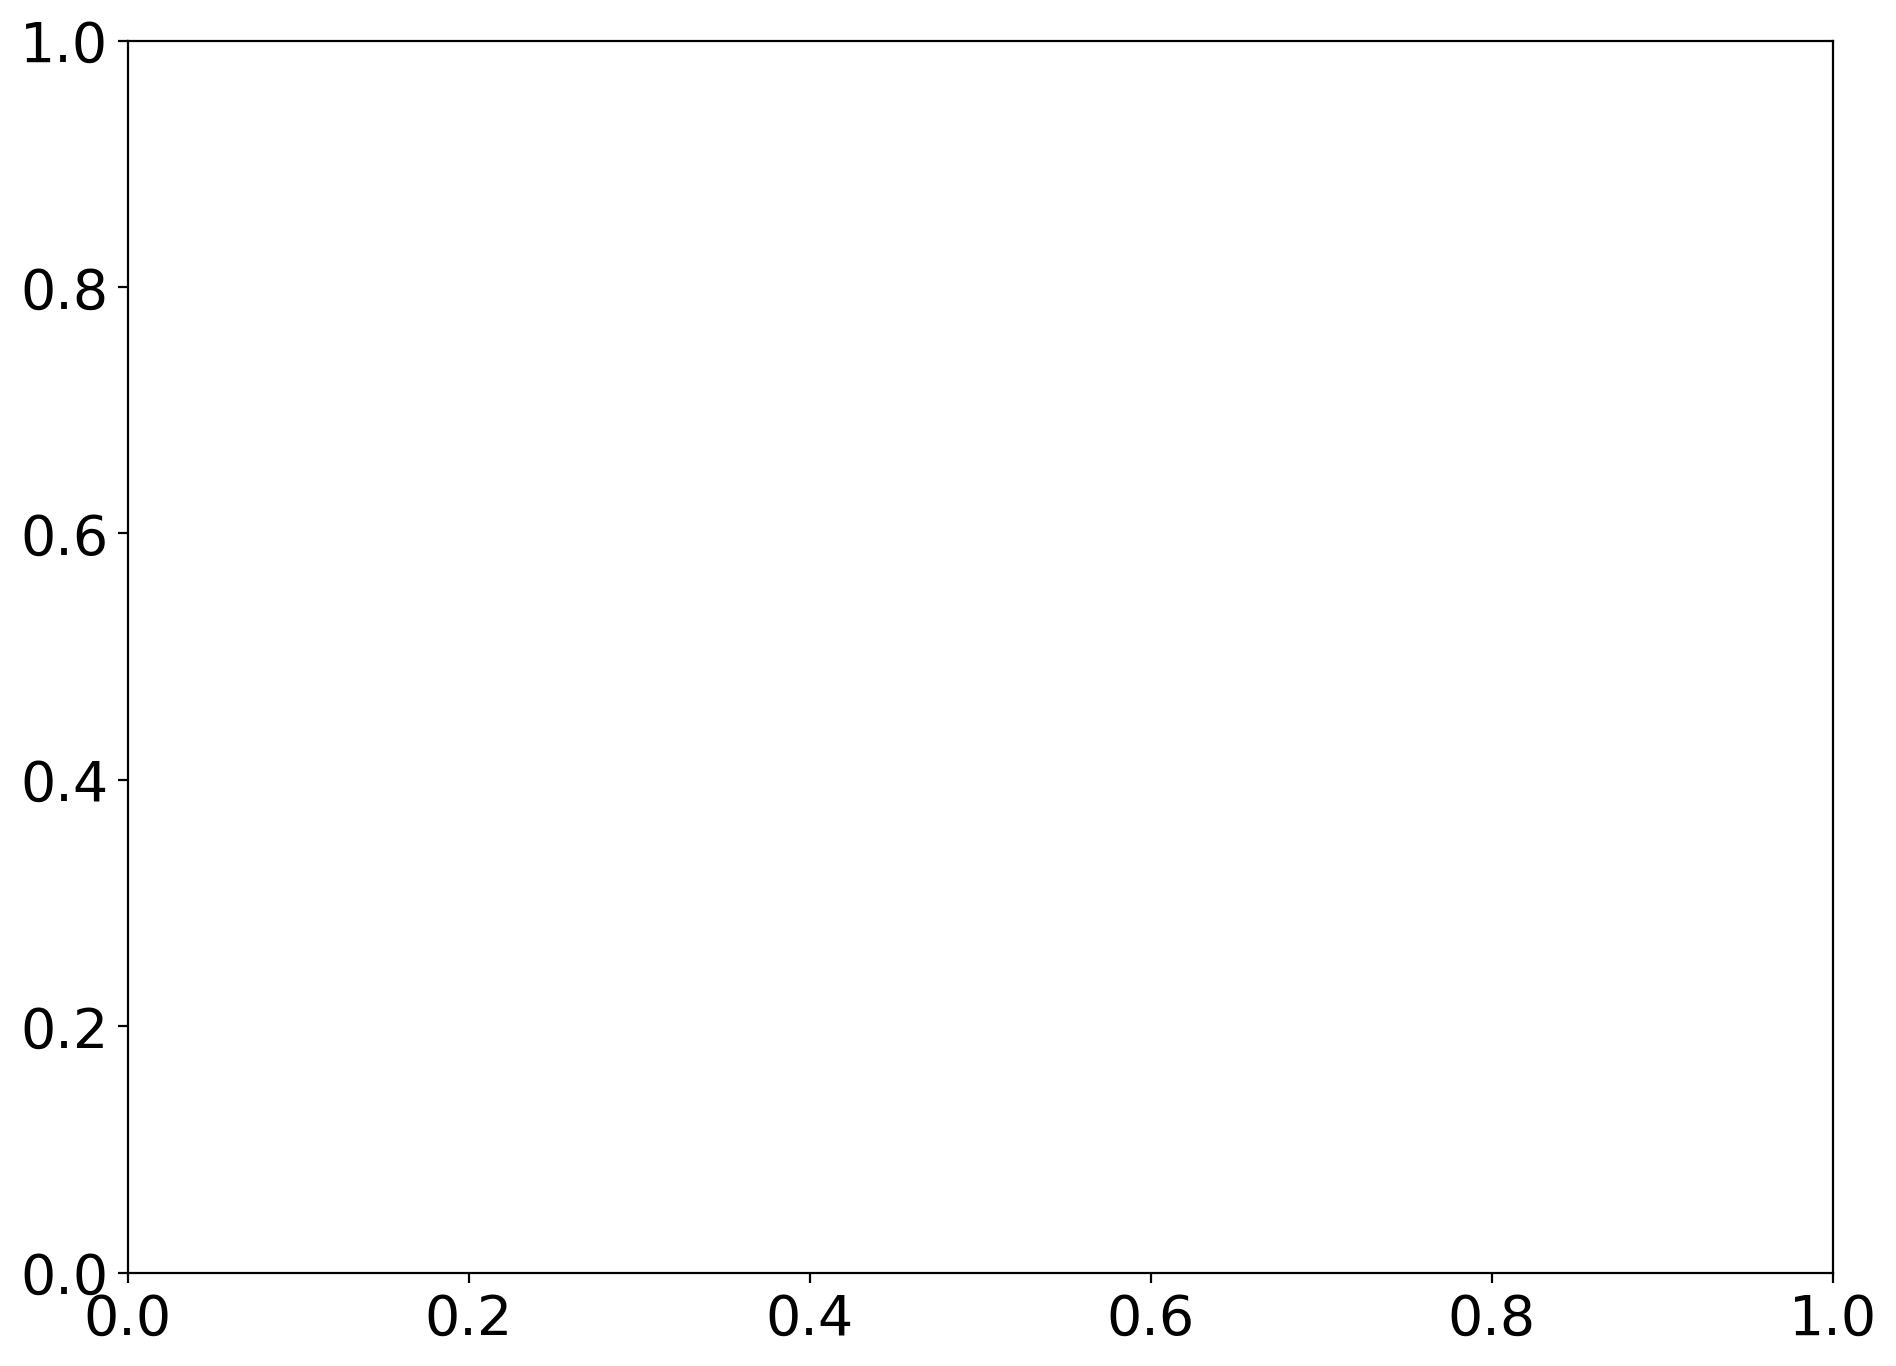

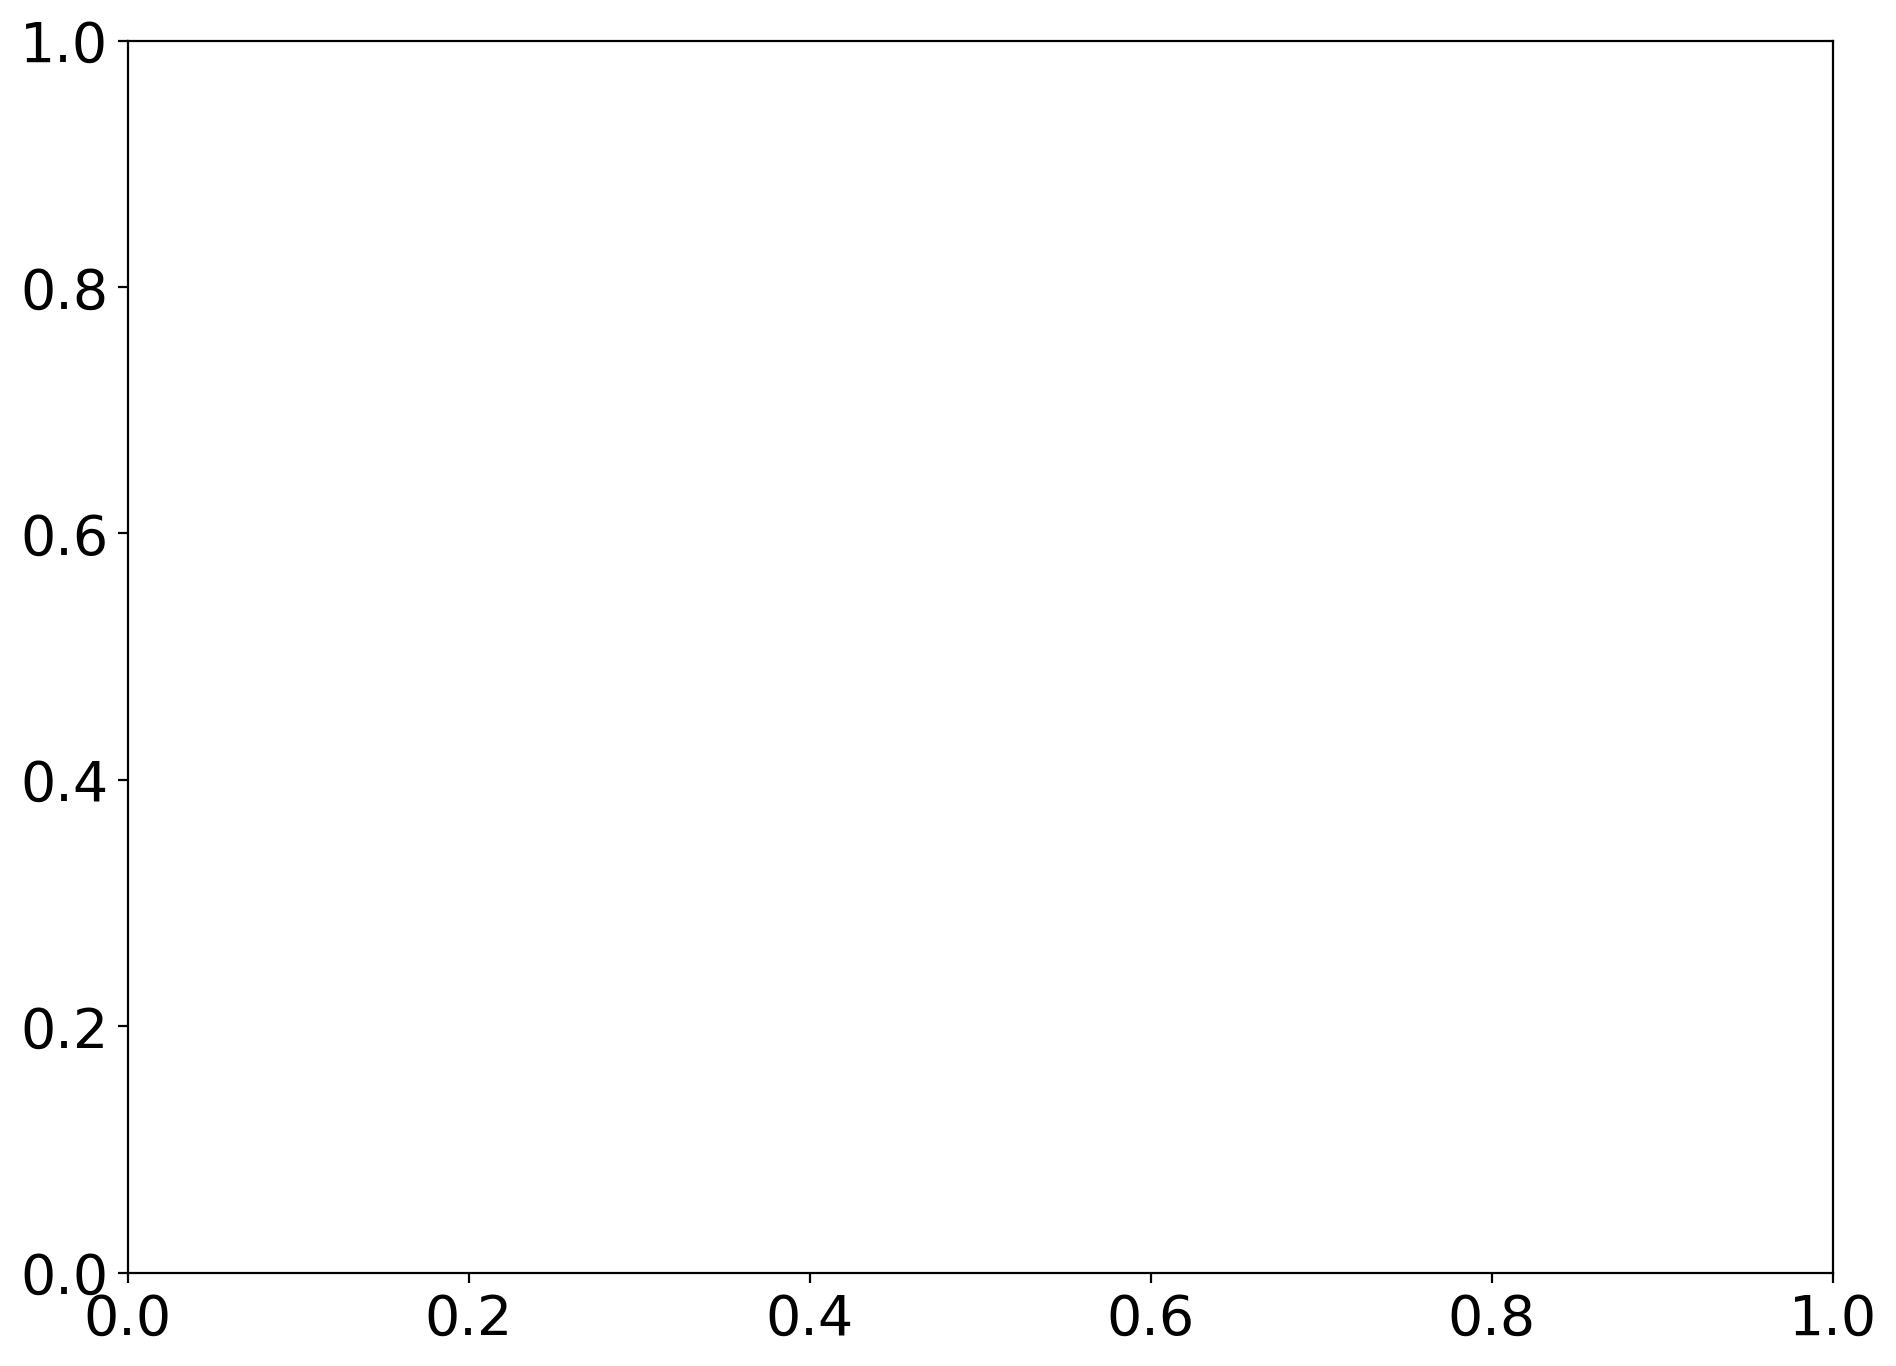

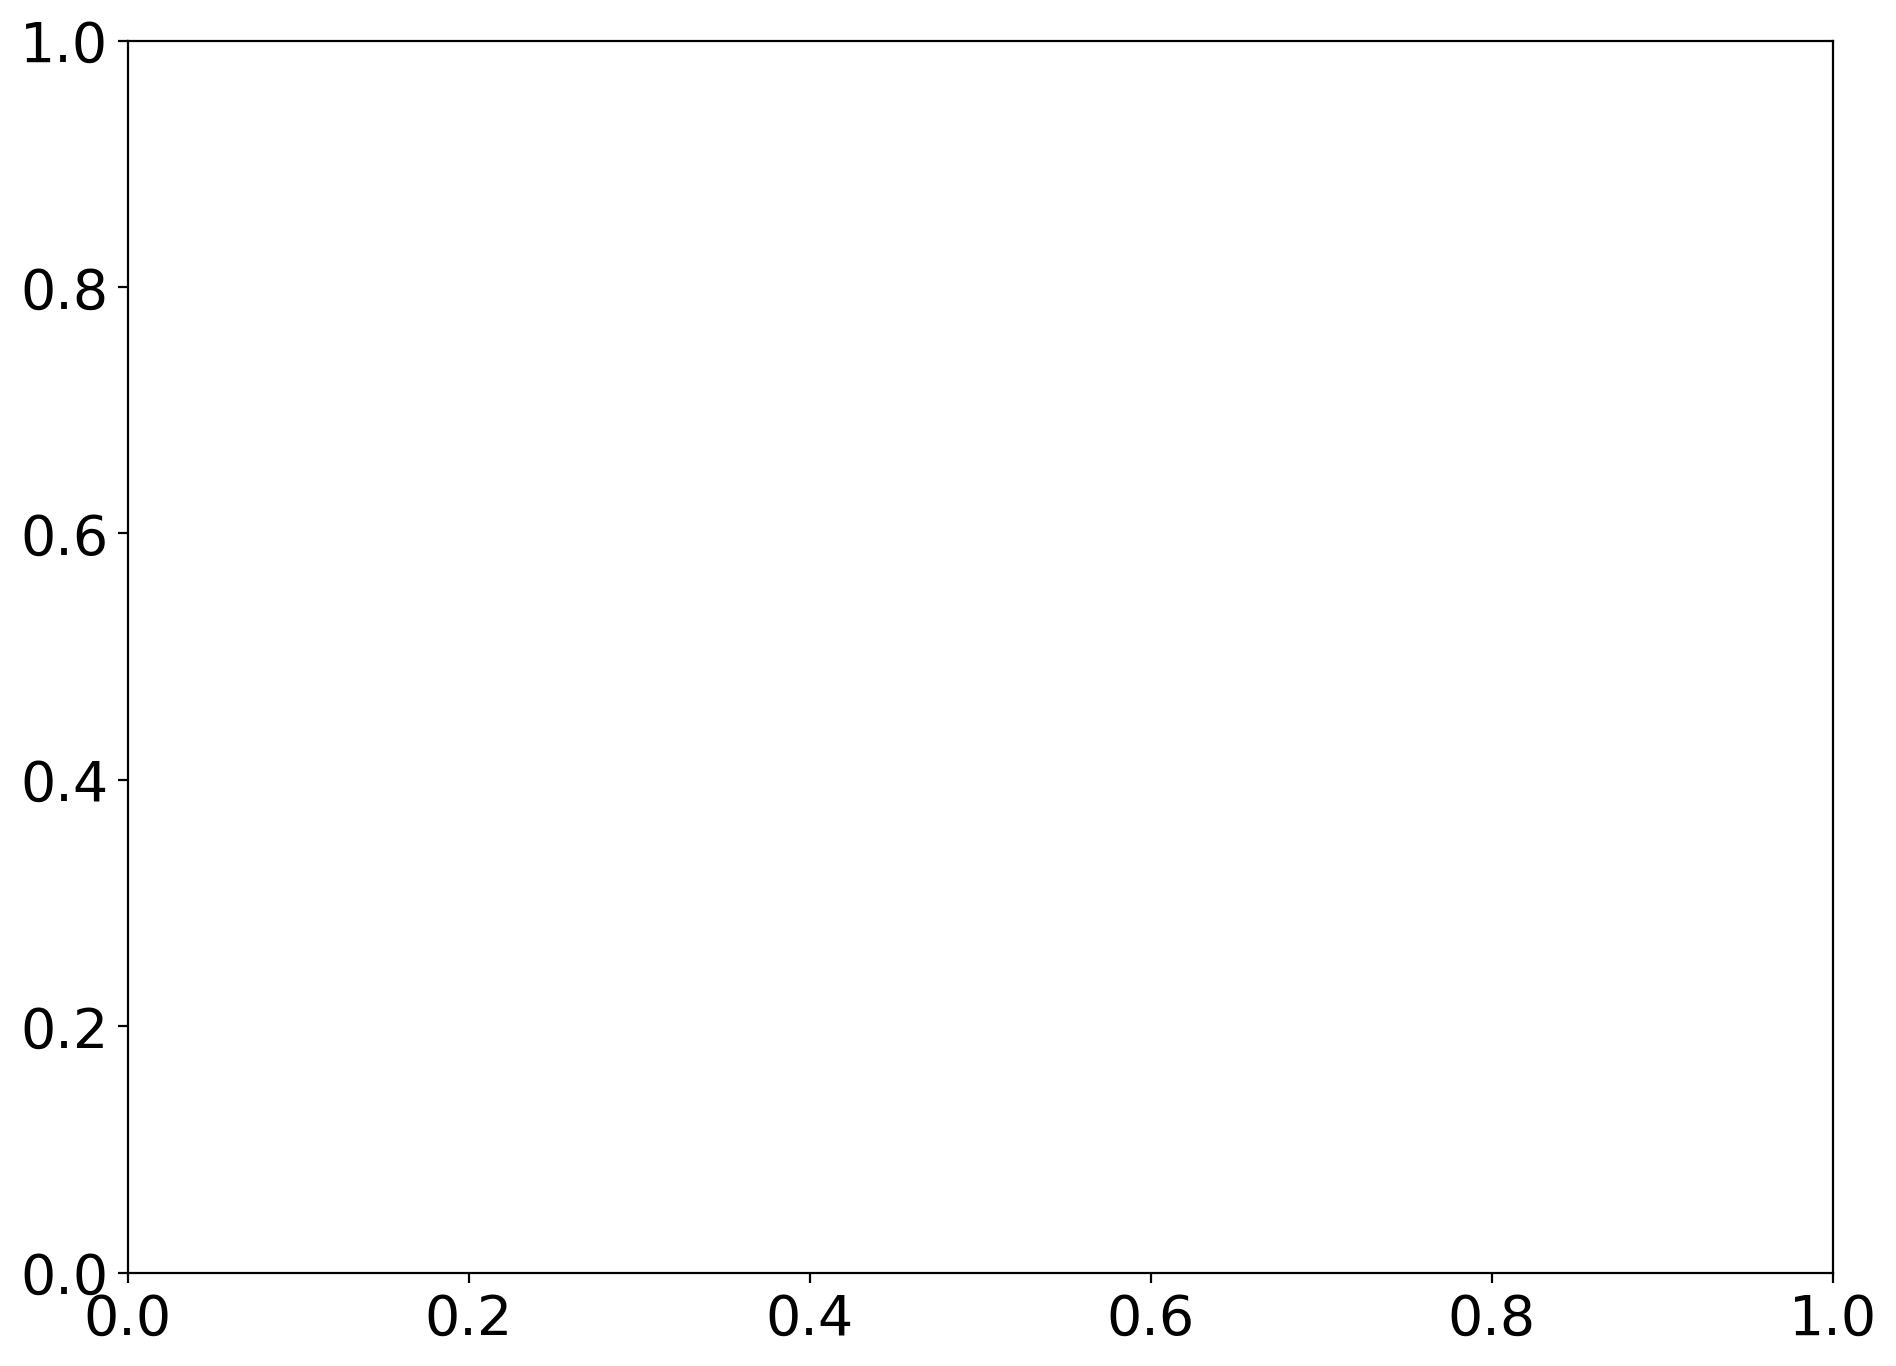

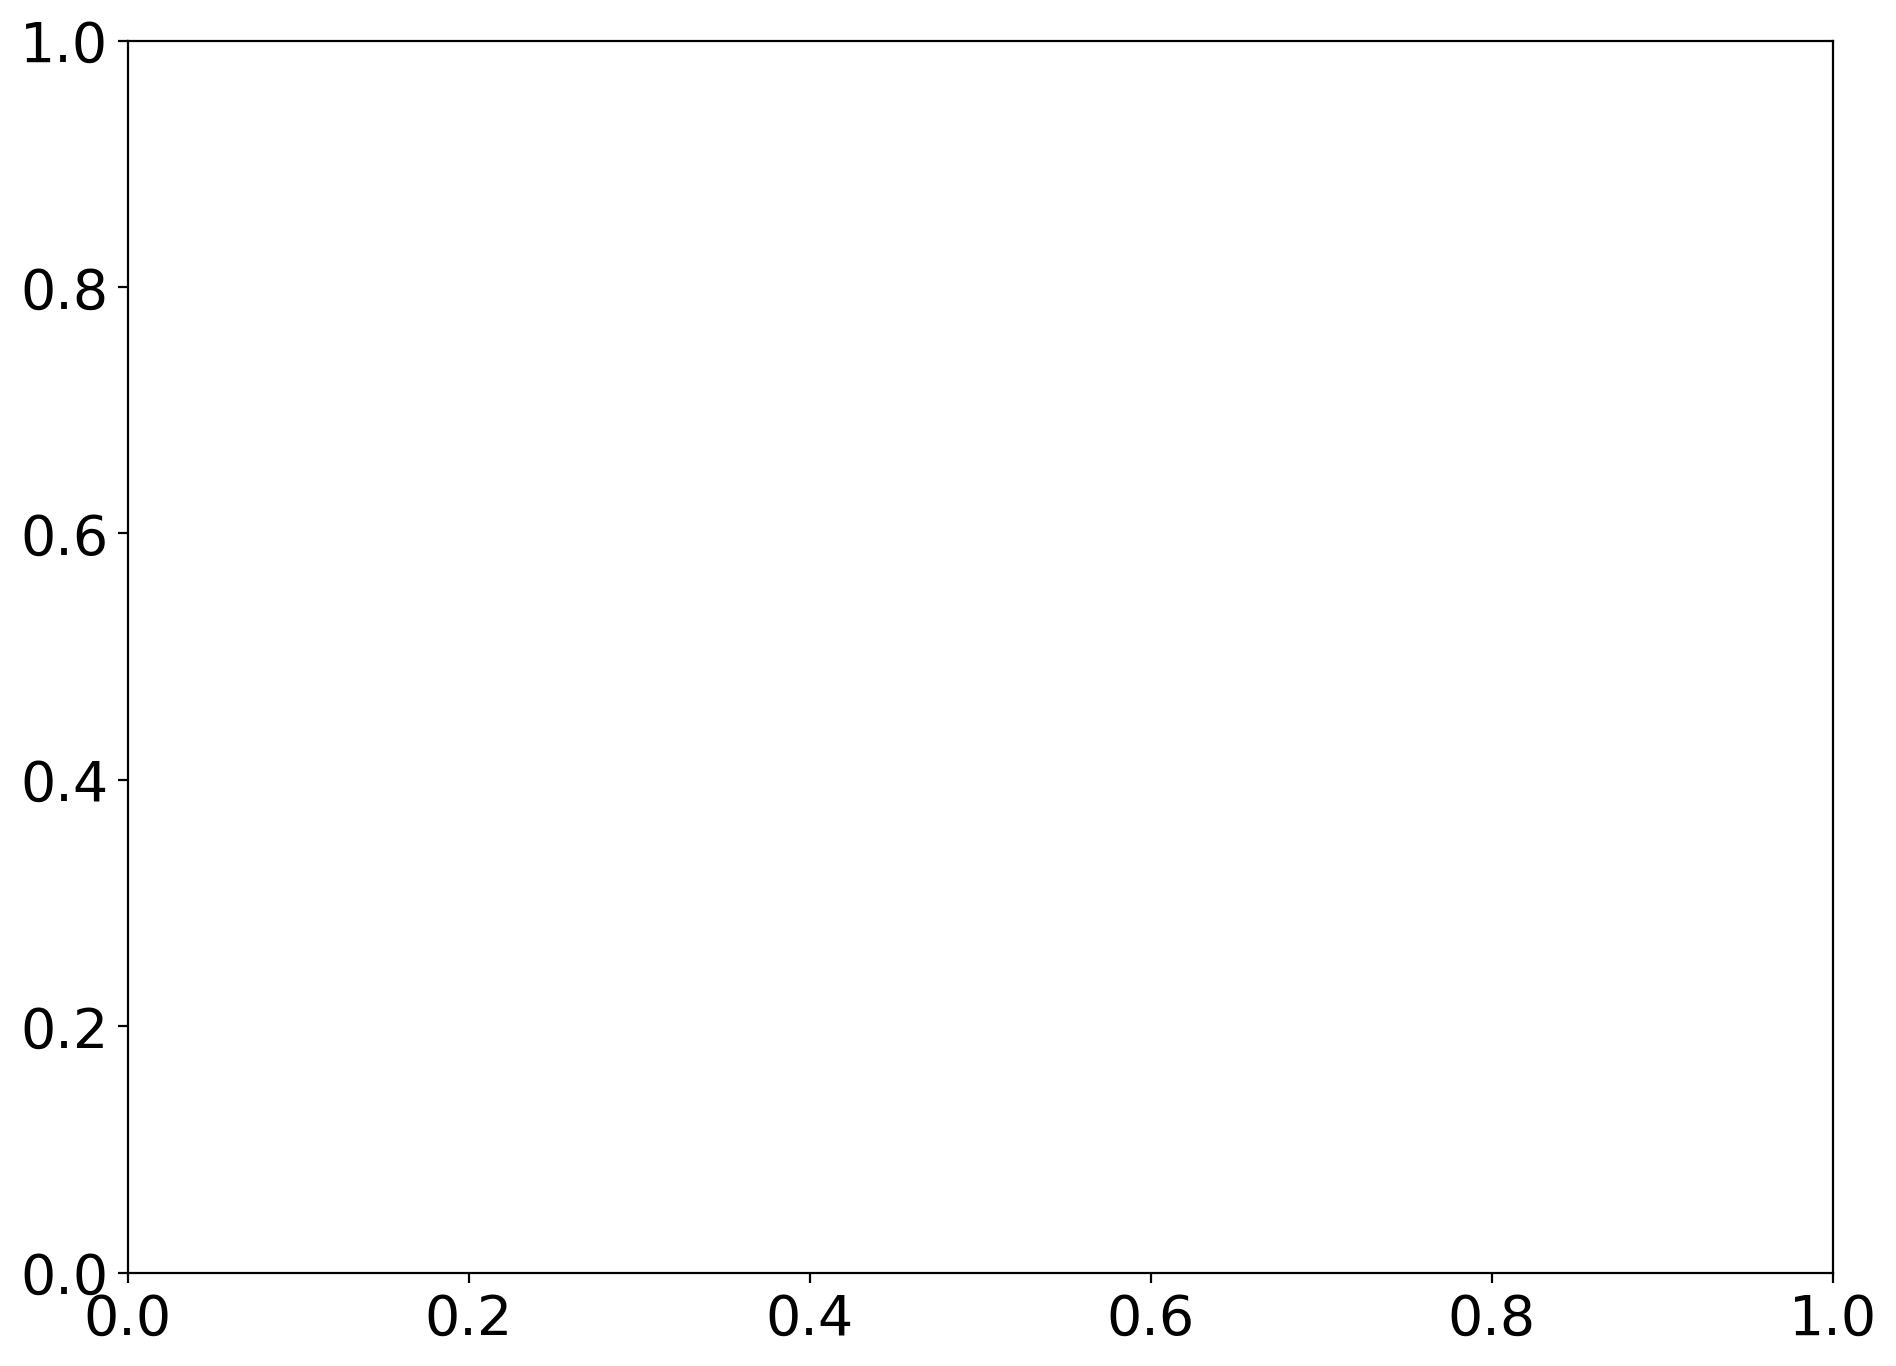

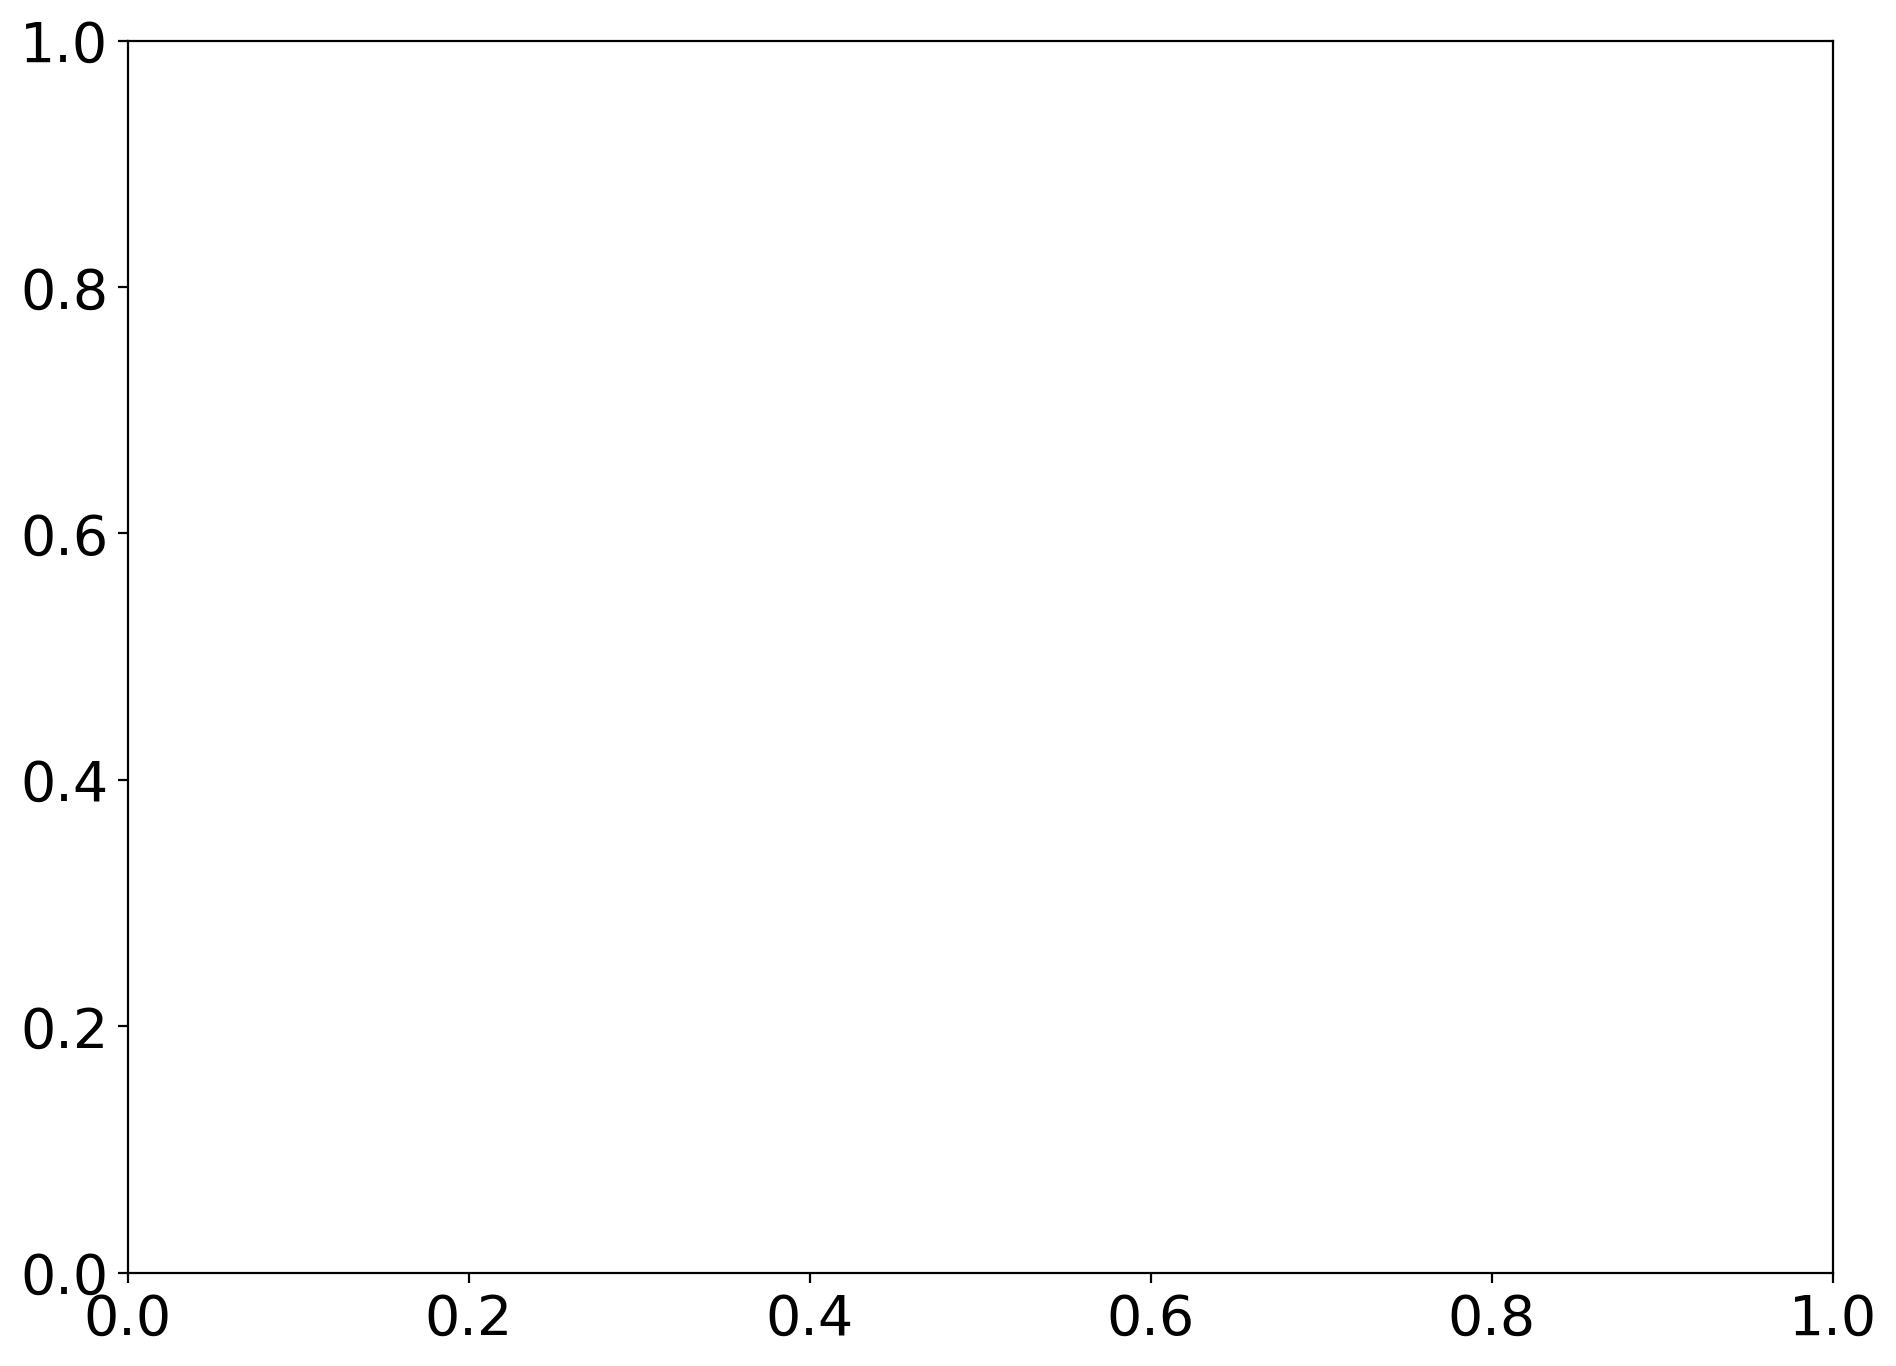

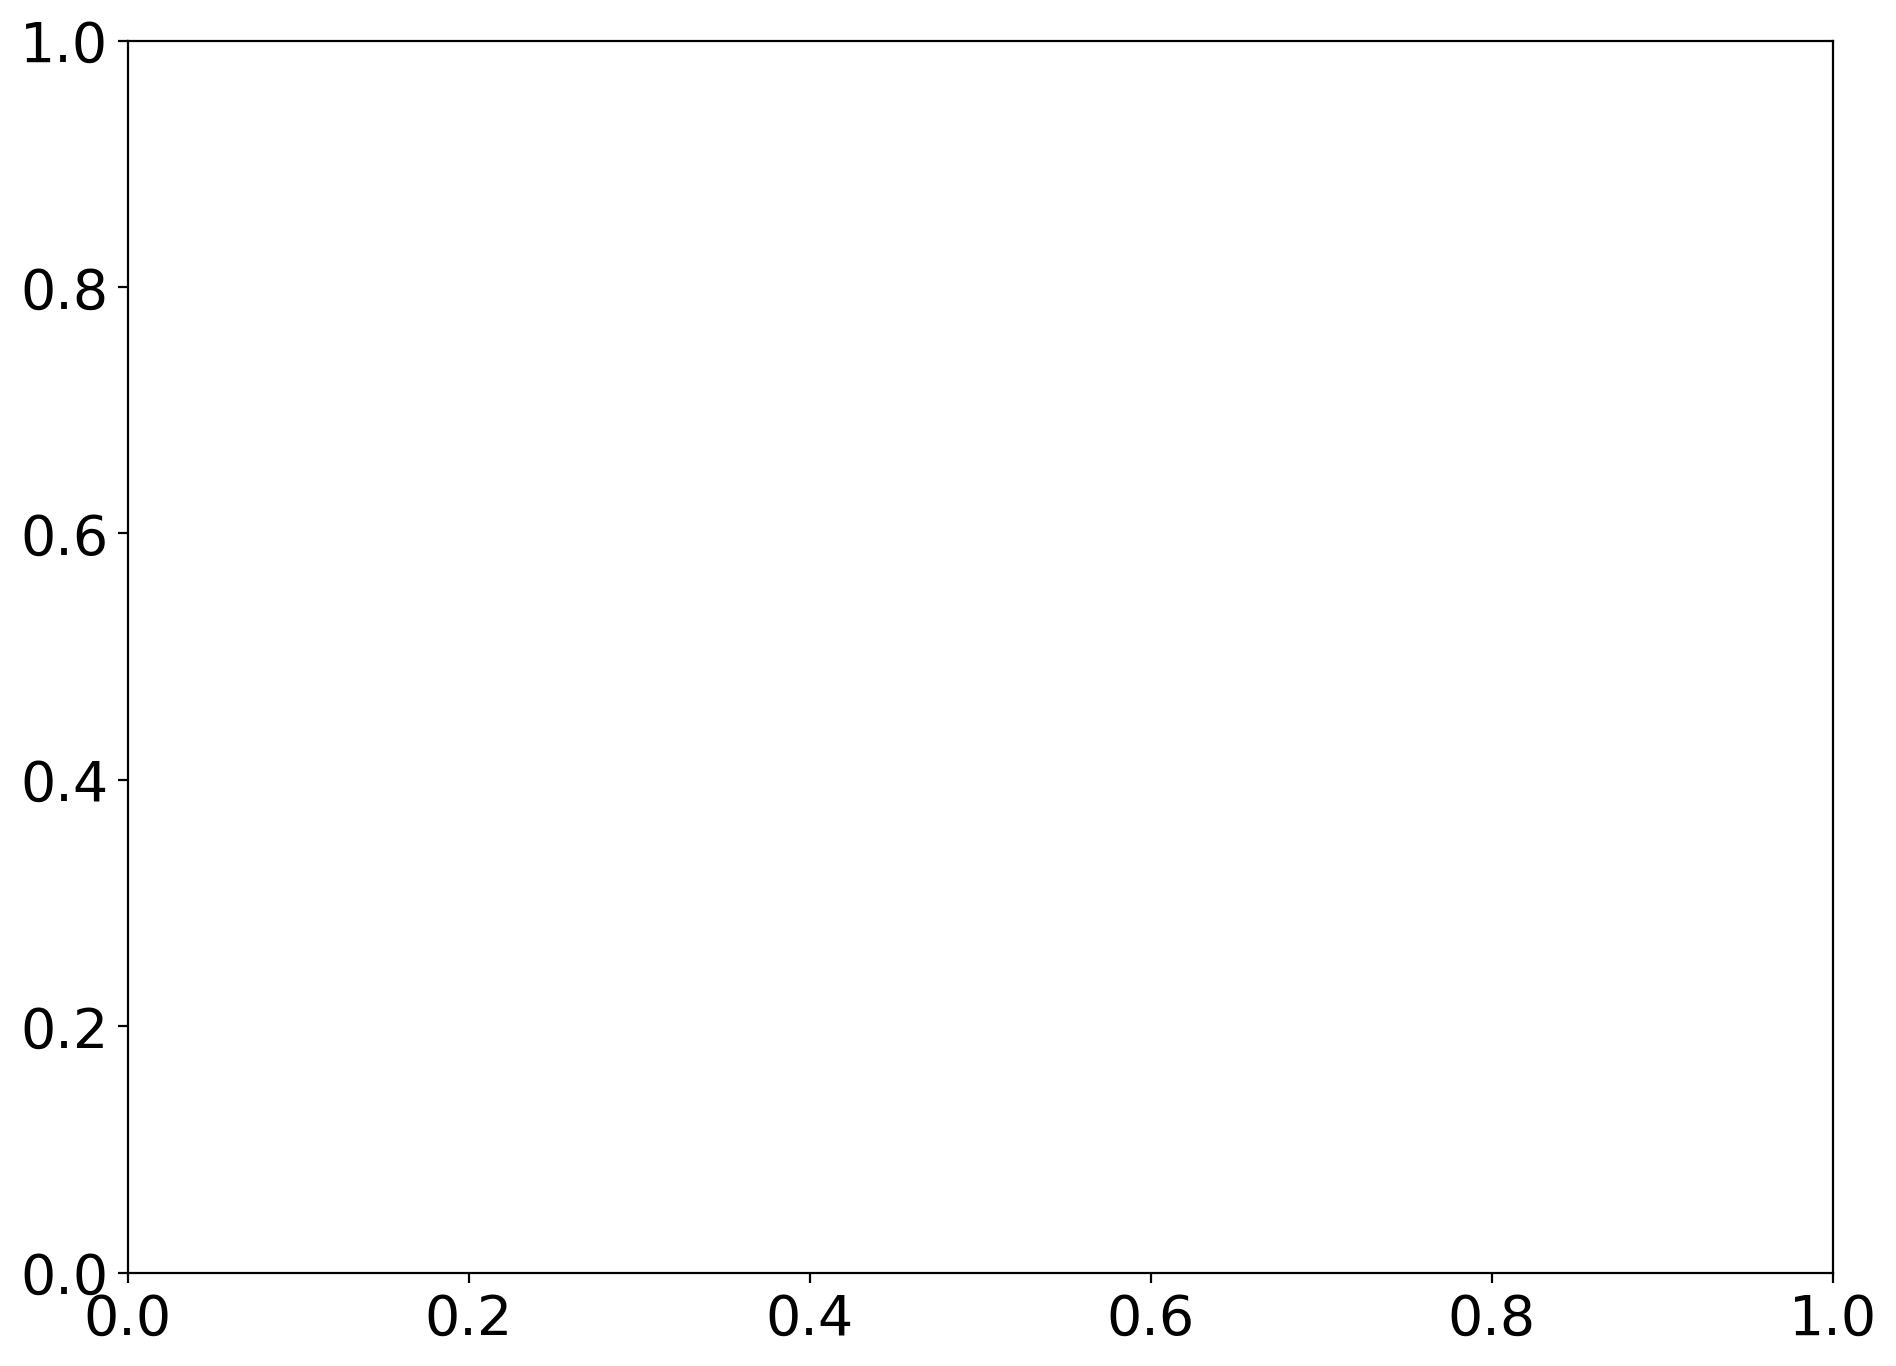

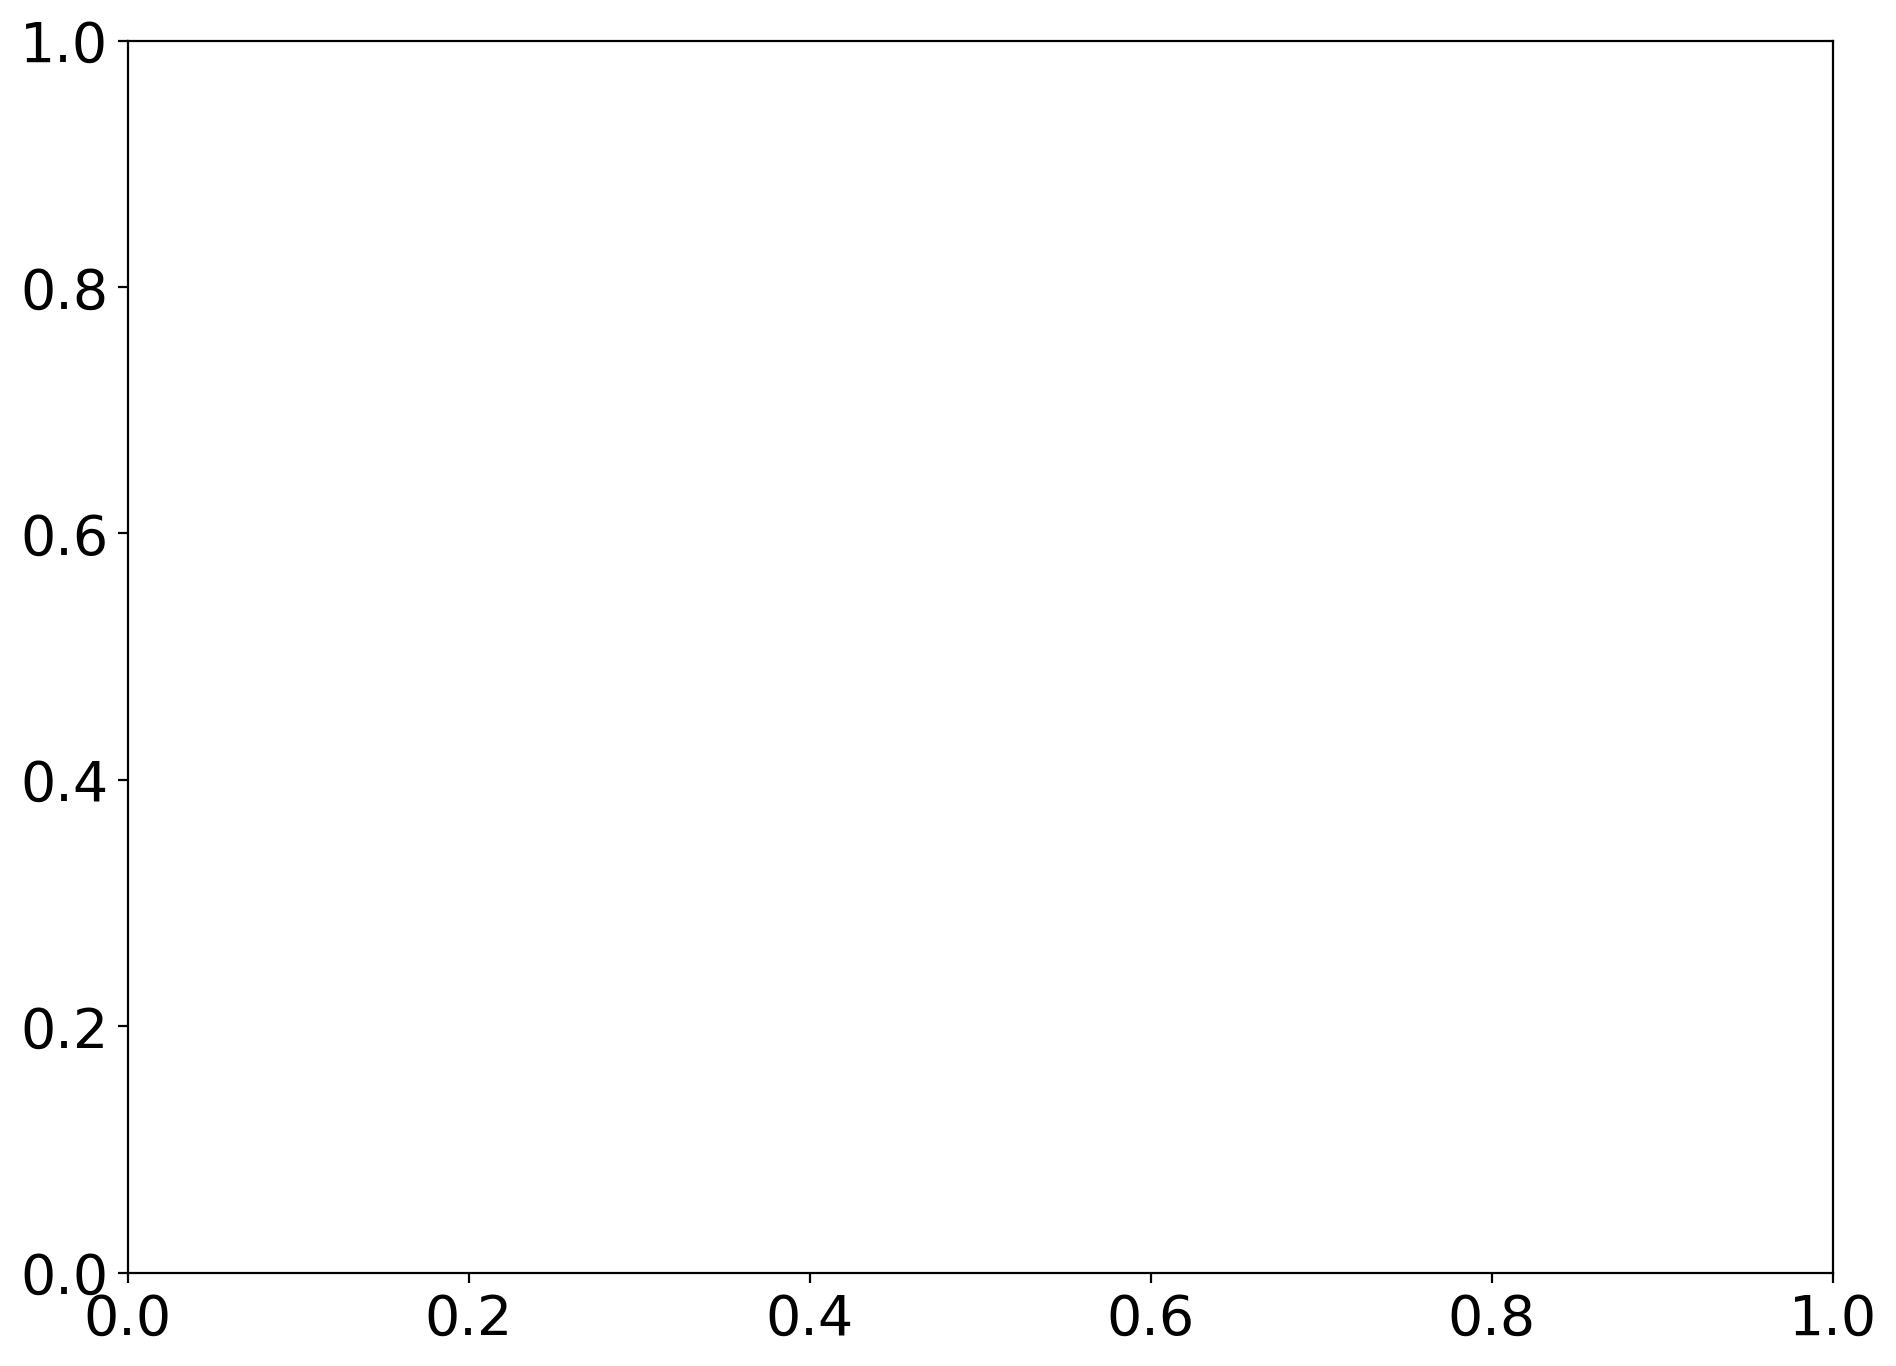

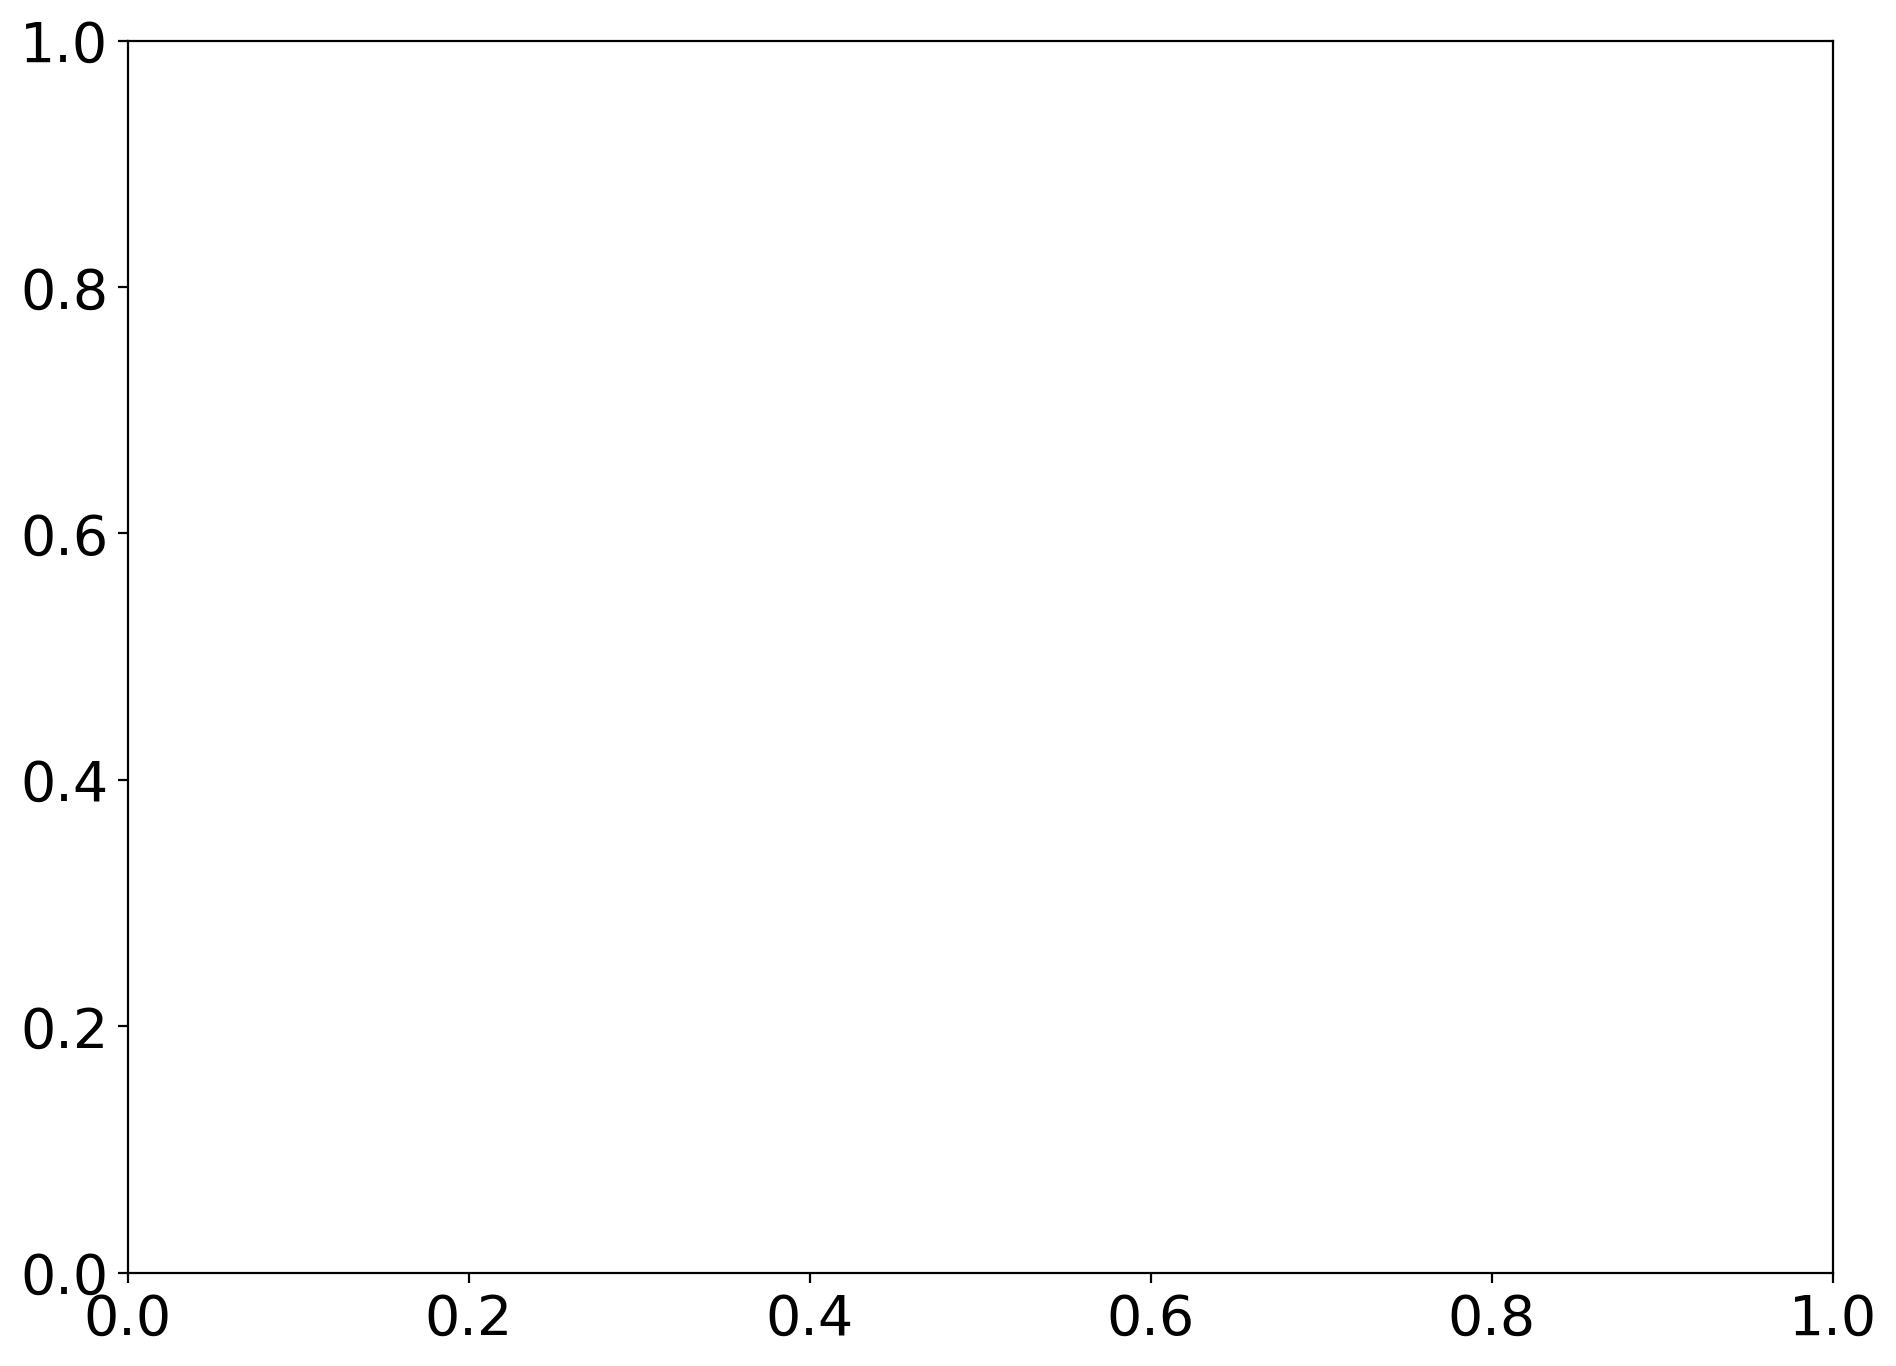

In [24]:

# pdf = PdfPages('../plots/all_rainier.pdf')
# associated_volcano = "Mt_Rainier"
dff=[] 
for nn in range(len(evt_id)):
    n = len(evt_id)-nn-1
    associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
    if associated_volcano!="Mt_Rainier":continue
    event_ID = str(evt_id[n])
    otime = UTCDateTime(start_time[n])
    associated_volcano="Mt_Rainier"


    #get info for stations within 50km of volcano that event ocurred at
    stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
    networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
    latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
    longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
    elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()


    #################### WAVEFORM DOWNLOAD #######################
    #Download all waveforms for that event based on stations and times
    bulk = [] 
    for m in range(0, len(networks)):
        bulk.append([networks[m], stations[m], '*', '*Z', otime-t_before_raw, otime+t_before_raw])
    try:
        st = client2.get_waveforms_bulk(bulk)
        st = resample(st,fs)  #resampling the data to 40Hz for each trace
        evt_data = obspy.Stream()
        snr=[]
        stas=[]
        nets=[]
        lats=[]
        lons=[]
        els=[]
        centroid_time = []
        data_env_dict = {}
        duration = []
        max_time = []

        # #Keeping all traces for one event with channel z, SNR>10, and bandpassed between 2-12Hz
        # ,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}
        for i,ii in enumerate(st):
            ii.detrend(type = 'demean')
            ii.filter('bandpass',freqmin=low_cut,freqmax=high_cut,corners=2,zerophase=True)
            # trim the data and noise window to exactly 6000 points
            signal_window = ii.copy()
            noise_window = ii.copy()
            signal_window.trim(otime - t_before, otime - t_before + window) # trim the signal at the first pick time of the PNSN data, with loose 40s before
            noise_window.trim(otime - window -t_before, otime - t_before) # noise window of the same length
            if  len(signal_window.data)<=10 or  len(noise_window.data)<=10: continue # skip if no data
            # if not np.percentile(np.abs(signal_window.data),pr):continue # skip if max amplitude is zero
            snr1 = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                            / np.percentile(np.abs(noise_window.data),pr))/np.log(10))
            if snr1<thr: # and 100<max_amp_time<200:
                st.remove(ii)
                continue

        ################# ENVELOPE, CENTROID, DURATION #######################
            # enveloping the data 
            data_envelope = obspy.signal.filter.envelope(signal_window.data)
            data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)

            data_env_dict[ii.stats.network+'.'+ii.stats.station]= data_envelope/max(np.abs(data_envelope))


            # max time
            # finding the time of max amplitude of each event
            # signal_window is windowed at otime-t_v before the PNSN pick time
            crap = np.argmax(np.abs(data_envelope[:(t_before+40)*fs])) # time of max amplitude relative to otime
            max_time.append(crap/fs)

            # centroid time
            tcrap = signal_window.times()
            it = np.where(tcrap>0)[0]
            centroid_time.append(np.sum(data_envelope*tcrap)/np.sum(data_envelope))

            # find duration as data starting with the "origin time" and ending when the envelope falls below the mean noise
            noise_envelope = obspy.signal.filter.envelope(noise_window.data)
            data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)
            mean_noise = np.mean(noise_envelope)
            
            mmax = np.max(np.cumsum(data_envelope**4))
            crap = np.where( np.cumsum(data_envelope**4) <= 0.999*mmax)[0][-1]
            duration.append(crap/fs)


            stas.append(ii.stats.station)
            nets.append(ii.stats.network)
            ista=stations.index(ii.stats.station)
            lats.append(latitudes[ista])
            lons.append(longitudes[ista])
            els.append(elevations[ista])
            snr.append(snr1)
            evt_data.append(signal_window)

            t = evt_data.select(station=stas[-1])[0].times()
            

        centroid_time = np.asarray(centroid_time)
        centroid_time -= t_before
        max_time = np.asarray(max_time)
        max_time -= t_before
        duration = np.asarray(duration)
        duration -= t_before

        ################### ELEP #######################

            # test the new function
        smb_peak= apply_elep(evt_data, stas, \
                list_models, MBF_paras, paras_semblance, t_before)
        smb_peak -= t_before


        ############## PEAK FREQUENCY MEASUREMENTS ############
        # Given the approximate measurement of duration, window the signal windows around that
        # then measure peak frequency so that there is less noise in it.
        # perform this on the Z component only.

        char_freq, sharp_weight= [],[]
        fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
        for ii,i in enumerate(evt_data):
            data = np.zeros(200*fs)
            crap=i.copy()
            otime1 = crap.stats.starttime + smb_peak[ii] # pick time
            crap.trim(otime1  - 10, otime1 + 2*duration[ii] + 10) # window the data around the pick time
            crap.taper(max_percentage=0.01,max_length=20)

            data[:len(crap.data)] = crap.data #*100
            f,psd=scipy.signal.welch(data,fs=fs,nperseg=81,noverlap=4)
            #just get the frequencies within the filter band
            above_low_cut = [f>low_cut]
            below_high_cut = [f<high_cut]
            in_band = np.logical_and(above_low_cut,below_high_cut)[0]
            f = f[in_band]
            psd = psd[in_band]

            # calculate characteristic frequency and report
            char_freq_max = f[np.argmax(psd)]
            char_freq_mean= np.sum(psd*f)/np.sum(psd)
            psd_cumsum = np.cumsum(psd)
            psd_sum = np.sum(psd)
            char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]
            char_freq.append(char_freq_mean)

        #             # weighting the data by the spikiness of the PSD vs frequency graphs
            ratio = (np.mean(psd)/np.max(psd))
            sharp_weight.append(int(1/(ratio**2)*20))



        ##################### get amplitude and energy ###########
        MaxD=[];MaxEnv=[];Er=[]
        for ii,i in enumerate(evt_data):
            data = np.zeros(200*fs)
            crap=i.copy()

            # get response
            inv = client2.get_stations(network=crap.stats.network, station=crap.stats.station,
                                location=crap.stats.location, channel=crap.stats.channel,
                                level="response", starttime=crap.stats.starttime, endtime=crap.stats.endtime)
            
            # The instrument sensitivity (gain) is stored in the response object
            channel = inv[0][0][0]
            response = channel.response
            gain = response.instrument_sensitivity.value 
            # remove response
            crap.remove_response(inventory=inv,output="DISP")
            otime1 = crap.stats.starttime + smb_peak[ii] # pick time
            crap.trim(otime1  - 10, otime1 + 1.5*duration[ii] + 10) # window the data around the pick time
            crap.taper(max_percentage=0.01,max_length=20)


            data_envelope = obspy.signal.filter.envelope(crap.data)
            data_envelope = obspy.signal.util.smooth(crap, smooth_length)

            MaxD.append(np.max(np.abs(crap.data)))
            MaxEnv.append(np.max(np.abs(data_envelope)))


            ## get energy
            crap=i.copy()
            crap.remove_response(inventory=inv,output="VEL")
            otime1 = crap.stats.starttime + smb_peak[ii] # pick time
            crap.trim(otime1  - 10, otime1 + 1.5*duration[ii] + 10) # window the data around the pick time
            crap.taper(max_percentage=0.01,max_length=20)
            Er.append(np.sum(crap.data**2)*crap.stats.sampling_rate)


            ############# KEEP DATA #######################

        #         if not max(smb_peak.shape):continue
        ddict = {'otime':otime, 'nets':nets, 'stas':stas,  'snr':snr, 'smb_peak': smb_peak, 'max_time':max_time, 'centroid_time': centroid_time , \
                'lats':lats, 'lons':lons, 'elevs':els, 'char_freq':char_freq, 'duration':duration, \
                    'sharp_weight':sharp_weight, 'volcano':associated_volcano, 'event_ID':event_ID, \
                        'MaxD':MaxD,'MaxEnv':MaxEnv,'ER':Er}
        if not np.any(dff):
            dff = pd.DataFrame.from_dict(ddict)
        else:
            dff=pd.concat([dff,pd.DataFrame.from_dict(ddict)],ignore_index=True)
        dff.tail()
    except:
        pass
    dff.to_csv("../data/events/catalog_all_rainier.csv")

## Event location

### Volcano data



In [ ]:

associated_volcano == 'Mt_Rainier'
        
#get info for stations within 50km of volcano that event ocurred at
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

############ LOCATION ############################
# input necessary data for grid search
arrivals = dff['smb_peak'].values
# arrivals = dff[dff['event_ID']==event_ID]['smb_peak'].values
sta_lats = dff['lats'].values
sta_lons = dff['lons'].values


In [ ]:
import pyproj


# Define the projection: UTM zone 11 for Washington state
proj = pyproj.Proj(proj='utm', zone=10, ellps='WGS84')

# Convert lat/long to Cartesian in meters
xsta, ysta = proj(sta_lons, sta_lats)
new_xsta =( xsta - np.min(xsta))/1E3
new_ysta = (ysta - np.min(ysta))/1E3

# cmap = plt.get_cmap('hot_r')
# ista=np.where(arrivals>0)[0]
# imin = np.argmin(arrivals[ista])
# for i in ista:
#     tt = arrivals[i]-np.min(arrivals[ista])
#     nmax=np.max(arrivals[ista])-np.min(arrivals[ista])
#     plt.plot(new_xsta[i],new_ysta[i],'o',color=cmap(tt/nmax),markersize=10,markeredgecolor='k')
#     plt.text(new_xsta[i],new_ysta[i],stas[i]+":"+str(np.ceil(tt*10)/10)+" s")
#     plt.axis('equal')
# plt.title("Travel time Relative to " + dff['stas'].values[ista[imin]])

Now we are confident that we can do the grid search. let's check the other fields

Add the rows to the entire data frame

Number of picks total

In [ ]:
npicks = dff.shape[0]

In [ ]:
dff['x_best']=np.zeros(npicks)
dff['y_best']=np.zeros(npicks)
dff['lat_best']=np.zeros(npicks)
dff['lon_best']=np.zeros(npicks)
dff['dist']=np.zeros(npicks)

## Locate all of the events!


In [ ]:


xxbest=[]
yybest=[]
llatbest=[]
llonbest=[]

df=[]
for nn in range(len(evt_id)):
  n = len(evt_id)-nn
  arrivals = dff[dff['event_ID']==evt_id[n]]['smb_peak'].values
  ista =np.where(arrivals>-t_before+0.1)[0]

  # location
  rss_mat,t_best,lon_best,lat_best,x_best,y_best,idx_best = gridsearch(lat_start,lon_start,\
                                                lat_end,lon_end,\
                                                sta_lats[ista],sta_lons[ista],arrivals[ista],vs=vs)

  
  # distances
  dist=[]
  for ista in range(len(xsta)):
      crap=np.sqrt( (xsta[ista] - x_best)**2 + (ysta[ista] - y_best)**2)
      dist.append(crap[0])


  # doppler effects

## calculate azimuth

  # Calculate the azimuth between the stations and the source location
  dff['azimuth'] =  #dff.apply(calculate_azimuth, axis=1)


  crap = np.zeros(len(xsta))
  crap2 = np.zeros(len(xsta))
  for ista in range(len(xsta)):
      A = dff[dff['event_ID']==evt_id[n]]['MaxD'].values[ista]*1E6
      A2 = dff[dff['event_ID']==evt_id[n]]['MaxEnv'].values[ista]*1E6
      d = dff[dff['event_ID']==evt_id[n]]['dist'].values[ista]/1E3
      crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
      crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44

  dff[dff['event_ID']==evt_id[n]]['Lm_sta_D']=crap
  dff[dff['event_ID']==evt_id[n]]['Lm_evt_D'] = np.median(crap)
  dff[dff['event_ID']==evt_id[n]]['Lm_sta_Env']=crap2
  dff[dff['event_ID']==evt_id[n]]['Lm_evt_Env'] = np.median(crap2)



  #         if not max(smb_peak.shape):continue
  dff[dff['event_ID']==evt_id[n]]['x_best']=x_best
  dff[dff['event_ID']==evt_id[n]]['y_best']=y_best
  dff[dff['event_ID']==evt_id[n]]['lat_best']=lat_best
  dff[dff['event_ID']==evt_id[n]]['lon_best']=lon_best
  dff[dff['event_ID']==evt_id[n]]['dist']=dist

  dff.tail()



dff.to_csv("../data/events/catalog_all_rainier.csv",index=False)

  # dff['xsta']=xsta
  # dff['ysta']=ysta
  # dff['xbest']=x_best*np.ones(len(xsta))
  # dff['ybest']=y_best*np.ones(len(xsta))

  # evlon,evlat = proj(x_best,y_best,inverse=True)
  # dff['evlat']=evlat*np.ones(len(xsta))
  # dff['evlon']=evlon*np.ones(len(xsta))

  # dist=[]
  # for ista in range(len(xsta)):
  #     crap=np.sqrt( (xsta[ista] - x_best)**2 + (ysta[ista] - y_best)**2)
  #     dist.append(crap[0])

  # dff['dist']=dist
print(t_best,lon_best,lat_best,x_best,y_best)

## Doppler effects?

In [ ]:


## Fit a doppler function
# Prepare data
x_data = np.radians(dff['azimuth'].values[ista])
y_data = dff['char_freq'].values[ista]

# Initial guess for the parameters
initial_guess = [0, 2*np.pi,  0]

# Fit the function to the data
params, params_covariance = curve_fit(doppler_func, x_data, y_data, p0=initial_guess)

print(params)

az=np.linspace(-np.pi,np.pi,100)
dop = doppler_func(az,params[0],params[1],params[2])

# Plot the characteristic frequency as a function of azimuth
plt.figure(figsize=(10, 6))
for station in dff['stas'].unique():
    station_data = dff[dff['stas'] == station]
    plt.plot(station_data['azimuth'], station_data['char_freq'],'o',markersize=14, label=station)
plt.plot(np.degrees(az),dop,label='l2')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Characteristic Frequency (Hz)')
plt.legend(loc='upper right',fontsize=10)
plt.grid(True)
plt.show()

In [ ]:
len(dff['snr'].values[ista])

In [ ]:
from scipy.optimize import least_squares

# Define the residuals function
def residuals_func(params, x_data, y_data,weight):
    return (y_data - doppler_func(x_data, *params))*weight

# Initial guess for the parameters
initial_guess = [0, 2*np.pi,  0]

# Fit the function to the data using L1 norm minimization
result = least_squares(residuals_func, initial_guess, args=(x_data, y_data,1/dff['snr'].values[ista]), loss='soft_l1')

# The optimized parameters are stored in result.x
params = result.x

print(params)

az=np.linspace(-np.pi,np.pi,100)
dop = doppler_func(az,params[0],params[1],params[2])


# Fit the function to the data
params, params_covariance = curve_fit(doppler_func, x_data, y_data, p0=initial_guess,sigma=dff['snr'].values[ista])
dop2 = doppler_func(az,params[0],params[1],params[2])

# Plot the characteristic frequency as a function of azimuth
plt.figure(figsize=(10, 6))
for station in dff['stas'].unique():
    station_data = dff[dff['stas'] == station]
    plt.plot(station_data['azimuth'], station_data['char_freq'],'o',markersize=14, label=station)
plt.plot(np.degrees(az),dop,label='l2')
plt.plot(np.degrees(az),dop2,label='l1')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Characteristic Frequency (Hz)')
plt.legend(loc='upper right',fontsize=10)
plt.grid(True)
plt.show()

In [ ]:
if params[0]<0:
    direction = params[1]+np.pi 
else:
    direction = params[1]   
fmax = max(dop)
fmin = min(dop)
v = vs*((fmax-fmin)/(fmax+fmin))
print(direction,v)


In [ ]:
dff['flow_dir'] = direction
dff['flow_speed'] = v

## Measure magnitude and radiated energy


We may need to figure out the wave types using polarization.

We will assume a body wave magnitude because the wavespeeds are quite high.

## Get magnitude

Follow the relation from Lin et al, 2015:
$ Lm = \log(A)+0.55 \log(dist) + 2.44$

where $A$ is in micrometers (1E-6 meters) and $dist$ is in km.

In [ ]:
crap = np.zeros(len(xsta))
crap2 = np.zeros(len(xsta))
for ista in range(len(xsta)):
    A = dff['MaxD'].values[ista]*1E6
    A2 = dff['MaxEnv'].values[ista]*1E6
    d = dff['dist'].values[ista]/1E3
    crap[ista]=  np.log(A) + 0.55*np.log(d)+2.44
    crap2[ista]=  np.log(A2) + 0.55*np.log(d)+2.44

dff['Lm_sta_D']=crap
dff['Lm_evt_D'] = np.median(crap)
dff['Lm_sta_Env']=crap2
dff['Lm_evt_Env'] = np.median(crap2)



dff.to_csv("../data/events/new_catalog.csv",index=False)

In [ ]:
dff